In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

np.random.seed(42)

In [ ]:
class Init:
    def __init__(self, l=10, k=200, d=1, num_events=10000):
        self.l = l
        self.k = k
        self.d = d
        self.num_events = num_events
        self.customers, self.sites, self.true_click_probs, self.customer_payments, self.customer_budgets, self.lambdas = self.initialization()
        self.visit_order = self.sim_visits()

    def gen_unit_vectors(self, num_vec):
        vecs = np.random.normal(0, 1, (num_vec, self.d))
        norms = np.linalg.norm(vecs, axis=1, keepdims=True)
        vecs = vecs / norms

        u = np.random.uniform(0, 1, (num_vec, 1))
        r = u ** (1 / self.d)

        vecs = vecs * r

        return vecs

    def initialization(self):
        customers = self.gen_unit_vectors(num_vec=self.k)
        sites = self.gen_unit_vectors(num_vec=self.l)
        true_click_probs = np.abs(np.dot(customers, sites.T))
        customer_payments = np.random.randint(1, 11, self.k)
        customer_budgets = np.random.randint(400, 500, self.k)
        lambdas = np.random.randint(1e3, 1e6, self.l)
        return customers, sites, true_click_probs, customer_payments, customer_budgets, lambdas

    def sim_visits(self):
        next_visit_times = np.random.exponential(1.0 / np.array(self.lambdas))

        visit_order = []

        for _ in range(self.num_events):
            next_site = np.argmin(next_visit_times)
            visit_order.append(next_site)
            next_visit_times[next_site] += np.random.exponential(1.0 / self.lambdas[next_site])

        return visit_order


In [ ]:
class BaseAdPolicy:
    def __init__(self, init_data):
        self.k = init_data.k  # Number of customers
        self.l = init_data.l  # Number of sites
        self.customer_payments = init_data.customer_payments
        self.customer_budgets = init_data.customer_budgets.copy()
        self.visit_order = init_data.visit_order
        self.true_click_probs = init_data.true_click_probs
        self.customer_clicks = np.zeros((self.k, self.l))
        self.display_counts = np.zeros((self.k, self.l))
        self.customer_revenue = np.zeros((self.k, self.l))
        self.estimated_click_probs = np.ones((self.k, self.l)) * 0.5
        self.current_cumulative_revenue = 0.0
        self.all_budgets_exhausted = False
        self.cumulative_revenue = []

    def run_simulation(self):
        raise NotImplementedError("Subclasses must implement this method.")


    def get_available_customers(self):
        available_customers = np.where(self.customer_budgets >= self.customer_payments)[0]
        if available_customers.size == 0:
            print("All customers have exhausted their budgets.")
            self.all_budgets_exhausted = True
        return available_customers


    def process_click(self, customer_idx, site_idx, true_click_prob):
        click = np.random.rand() < true_click_prob
        self.display_counts[customer_idx, site_idx] += 1

        if click:
            payment = self.customer_payments[customer_idx]
            self.customer_budgets[customer_idx] -= payment
            self.customer_clicks[customer_idx, site_idx] += 1
            self.customer_revenue[customer_idx, site_idx] += payment
            self.current_cumulative_revenue += payment

        self.cumulative_revenue.append(self.current_cumulative_revenue)

        return click

    def get_results(self):
        return {
            "customer_clicks": self.customer_clicks,
            "customer_revenue": self.customer_revenue,
            "remaining_budgets": self.customer_budgets,
            "cumulative_revenue": np.array(self.cumulative_revenue, dtype=np.float32)
        }

    def draw_income(self):
        if not self.cumulative_revenue:
            print("No revenue data to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.plot(self.cumulative_revenue, label='Cumulative Revenue')
        plt.title(f"{self.__class__.__name__} Cumulative Revenue")
        plt.xlabel("Time Steps")
        plt.ylabel("Cumulative Revenue")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_clicks(self):
        total_clicks = self.customer_clicks.sum(axis=0)
        if total_clicks.size == 0:
            print("No click data to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.l), total_clicks, color='skyblue')
        plt.title(f"{self.__class__.__name__} Total Clicks per Site")
        plt.xlabel("Site Index")
        plt.ylabel("Total Clicks")
        plt.xticks(range(self.l))
        plt.grid(axis='y')
        plt.show()

    def draw_remaining_budget(self):
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.k), self.customer_budgets)
        plt.title(f"{self.__class__.__name__} Remaining Budget per Customer")
        plt.xlabel("Customer Index")
        plt.ylabel("Remaining Budget")
        plt.show()

    def draw_click_distribution(self):
        plt.figure(figsize=(10, 6))
        total_clicks = self.customer_clicks.sum(axis=1)
        plt.hist(total_clicks, bins=20)
        plt.title(f"{self.__class__.__name__} Distribution of Clicks per Customer")
        plt.ylabel("Number of Clicks")
        plt.xlabel("Number of Customers")
        plt.show()


In [ ]:
class OptimalPolicy(BaseAdPolicy):
    def __init__(self, init_data):
        super().__init__(init_data)

    def run_simulation(self):
        self.cumulative_revenue.append(self.current_cumulative_revenue)

        for site_idx in self.visit_order:

            available_customers = self.get_available_customers()
            if self.all_budgets_exhausted:
                break

            click_probs = self.true_click_probs[available_customers, site_idx]
            expected_rewards = click_probs * self.customer_payments[available_customers]

            max_idx = np.argmax(expected_rewards)
            customer_idx = available_customers[max_idx]
            true_click_prob = click_probs[max_idx]

            self.process_click(customer_idx, site_idx, true_click_prob)


In [ ]:
class EpsilonGreedyPolicy(BaseAdPolicy):
    def __init__(self, init_data, epsilon=0.1):
        super().__init__(init_data)
        self.epsilon = epsilon

    def run_simulation(self):
        self.cumulative_revenue.append(self.current_cumulative_revenue)

        for site_idx in self.visit_order:

            available_customers = self.get_available_customers()
            if self.all_budgets_exhausted:
                break

            # Exploration:
            if np.random.rand() < self.epsilon:
                customer_idx = np.random.choice(available_customers)
            # Exploitation:
            else:
                estimated_rewards = self.estimated_click_probs[available_customers, site_idx] * self.customer_payments[available_customers]
                customer_idx = available_customers[np.argmax(estimated_rewards)]

            true_click_prob = self.true_click_probs[customer_idx, site_idx]

            self.process_click(customer_idx, site_idx, true_click_prob)

            self.estimated_click_probs[customer_idx, site_idx] = (
                    self.customer_clicks[customer_idx, site_idx] / self.display_counts[customer_idx, site_idx]
                )

In [ ]:
class AdaptiveEpsilonGreedyPolicy(BaseAdPolicy):
    def __init__(self, init_data, initial_epsilon=1.0, min_epsilon=0.01, decay_rate=0.995):
        super().__init__(init_data)
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon = initial_epsilon
        self.t = 0

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.initial_epsilon * (self.decay_rate ** self.t))

    def run_simulation(self):
        self.cumulative_revenue.append(self.current_cumulative_revenue)

        for site_idx in self.visit_order:
            self.t += 1
            self.decay_epsilon()

            available_customers = self.get_available_customers()
            if self.all_budgets_exhausted:
                break

            if np.random.rand() < self.epsilon:
                customer_idx = np.random.choice(available_customers)
            else:
                estimated_rewards = self.estimated_click_probs[available_customers, site_idx] * self.customer_payments[available_customers]
                customer_idx = available_customers[np.argmax(estimated_rewards)]

            true_click_prob = self.true_click_probs[customer_idx, site_idx]

            self.process_click(customer_idx, site_idx, true_click_prob)

            self.estimated_click_probs[customer_idx, site_idx] = (
                self.customer_clicks[customer_idx, site_idx] / self.display_counts[customer_idx, site_idx]
            )

In [ ]:
class UCBPolicy(BaseAdPolicy):
    def __init__(self, init_data, confidence_level=2):
        super().__init__(init_data)
        self.confidence_level = confidence_level

    def run_simulation(self):
        self.cumulative_revenue.append(self.current_cumulative_revenue)

        for t in range(len(self.visit_order)):
            site_idx = self.visit_order[t]

            available_customers = self.get_available_customers()
            if self.all_budgets_exhausted:
                break

            total_displays = self.display_counts[available_customers, site_idx]
            estimated_probs = self.estimated_click_probs[available_customers, site_idx]

            ucb_values = estimated_probs + np.sqrt(
                (self.confidence_level * np.log(t + 1)) / total_displays
            )

            expected_rewards = ucb_values * self.customer_payments[available_customers]
            customer_idx = available_customers[np.argmax(expected_rewards)]


            true_click_prob = self.true_click_probs[customer_idx, site_idx]
            self.process_click(customer_idx, site_idx, true_click_prob)

            self.estimated_click_probs[customer_idx, site_idx] = (
                    self.customer_clicks[customer_idx, site_idx] / self.display_counts[customer_idx, site_idx]
            )

In [ ]:
class ThompsonSamplingPolicy(BaseAdPolicy):
    def __init__(self, init_data):
        super().__init__(init_data)

        self.alpha = np.ones((self.k, self.l))  # Prior successes (clicks)
        self.beta = np.ones((self.k, self.l))   # Prior failures (no clicks)

    def run_simulation(self):

        self.cumulative_revenue.append(self.current_cumulative_revenue)

        for site_idx in self.visit_order:

            available_customers = self.get_available_customers()
            if self.all_budgets_exhausted:
                break

            sampled_probs = np.random.beta(
                self.alpha[available_customers, site_idx],
                self.beta[available_customers, site_idx]
            )

            expected_rewards = sampled_probs * self.customer_payments[available_customers]
            customer_idx = available_customers[np.argmax(expected_rewards)]

            true_click_prob = self.true_click_probs[customer_idx, site_idx]
            click = self.process_click(customer_idx, site_idx, true_click_prob)

            if click:
                self.alpha[customer_idx, site_idx] += 1
            else:
                self.beta[customer_idx, site_idx] += 1


Running experiment with k=200, l=1, d=1


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


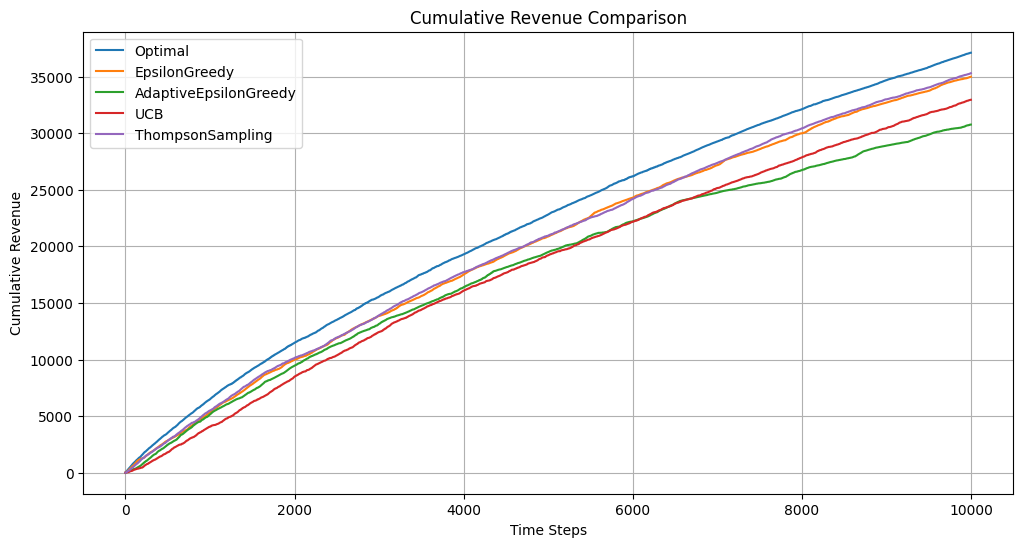

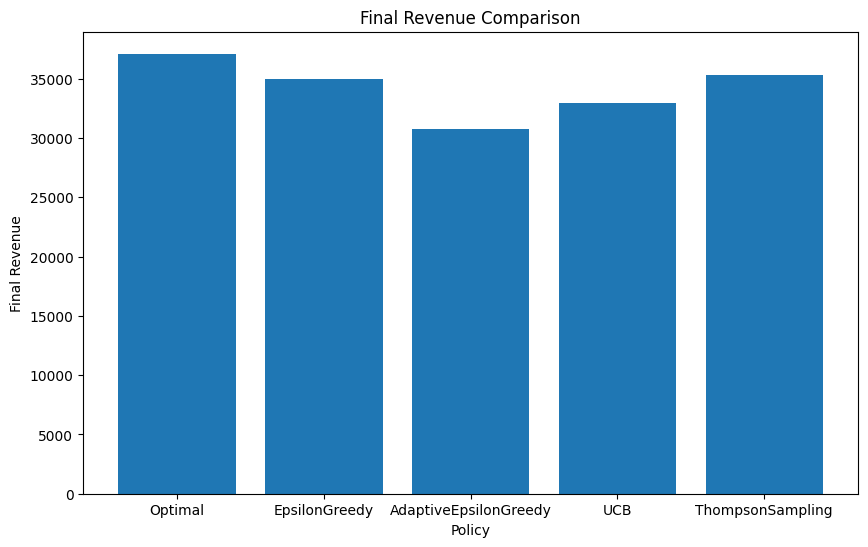

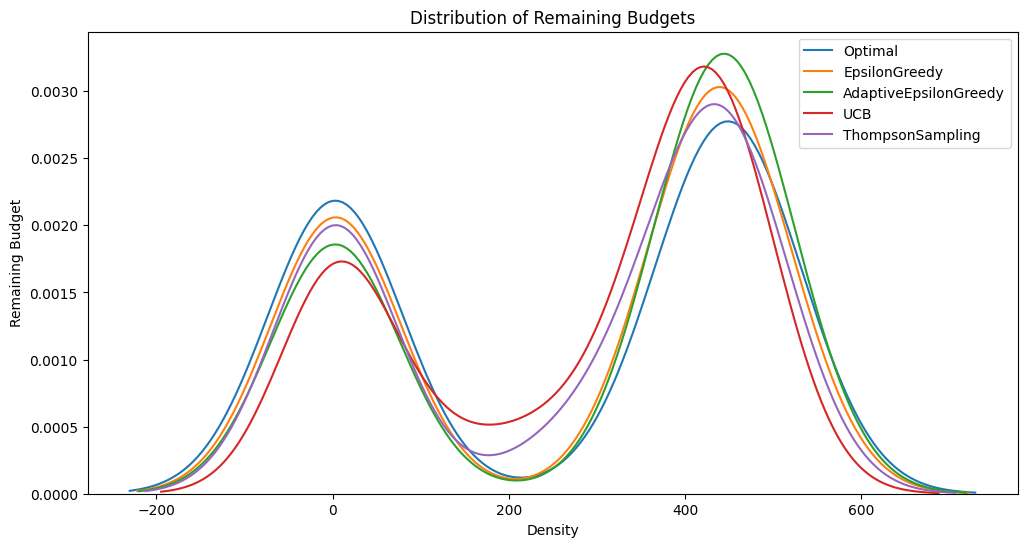

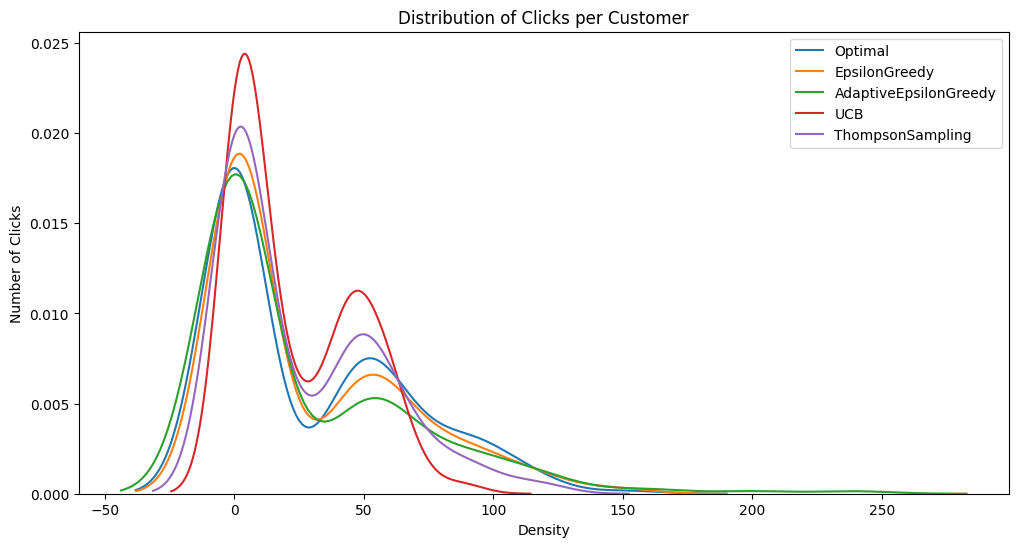

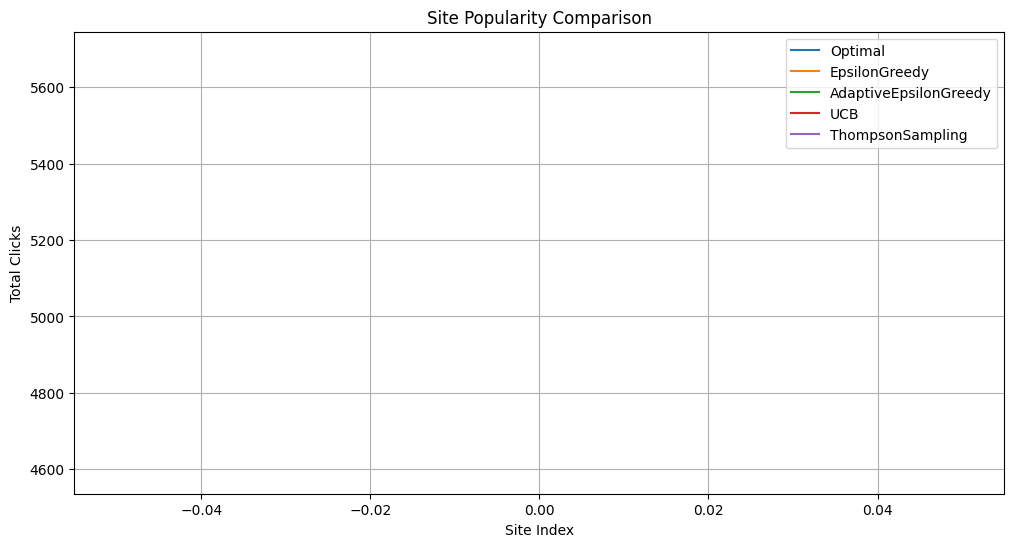


Results for Optimal:


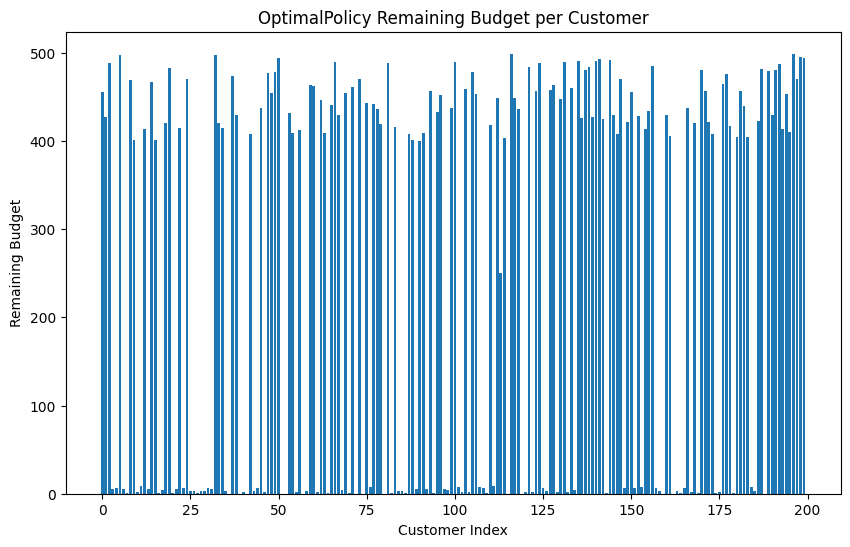

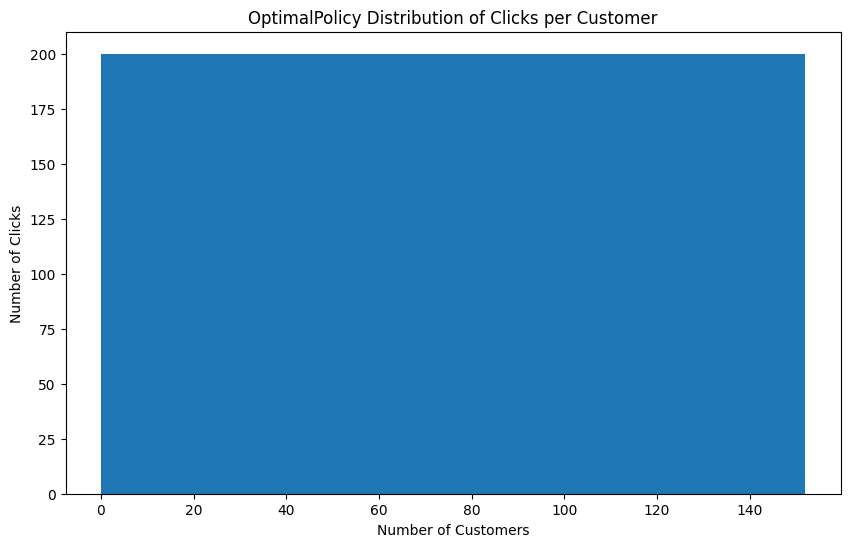


Results for EpsilonGreedy:


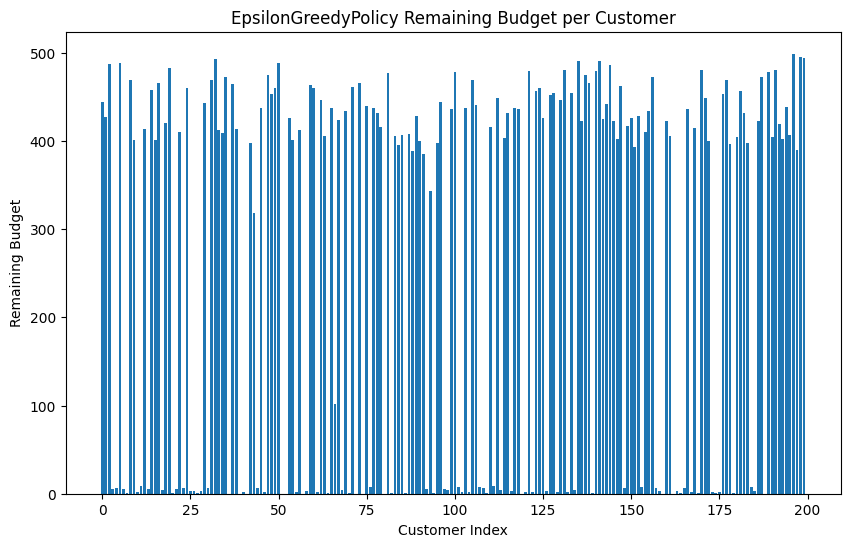

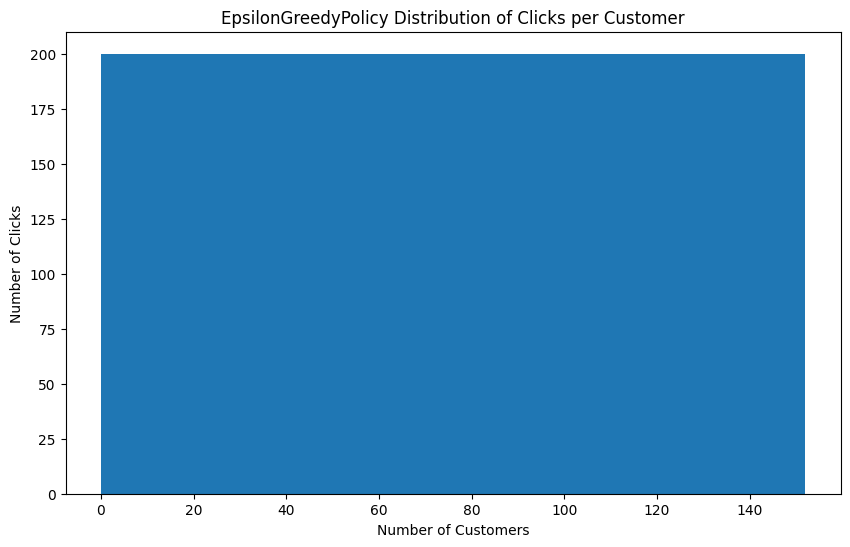


Results for AdaptiveEpsilonGreedy:


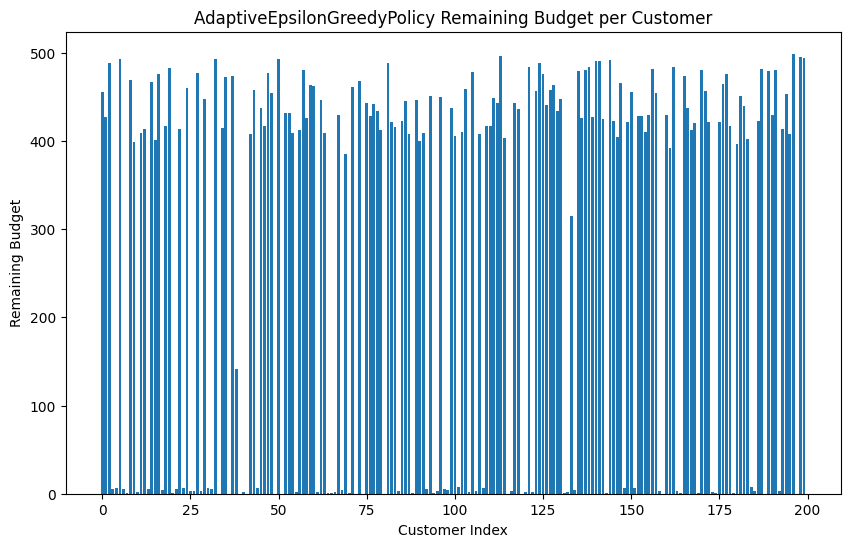

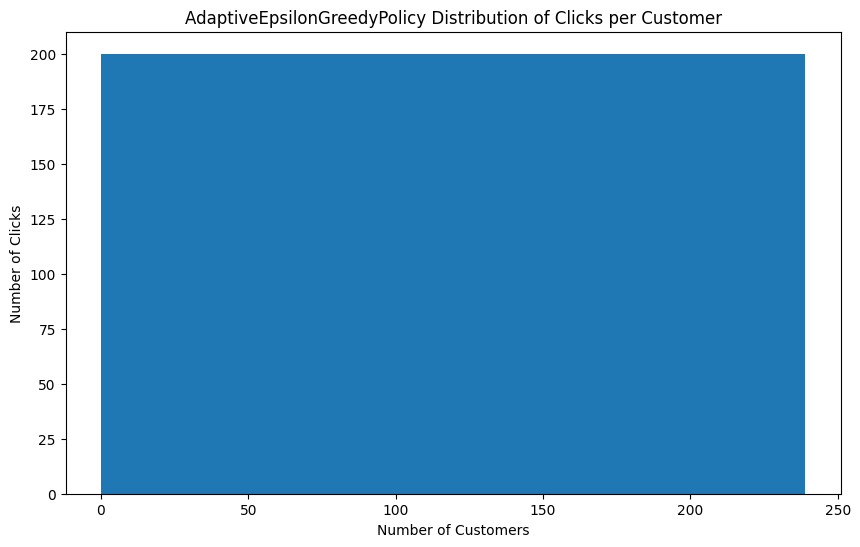


Results for UCB:


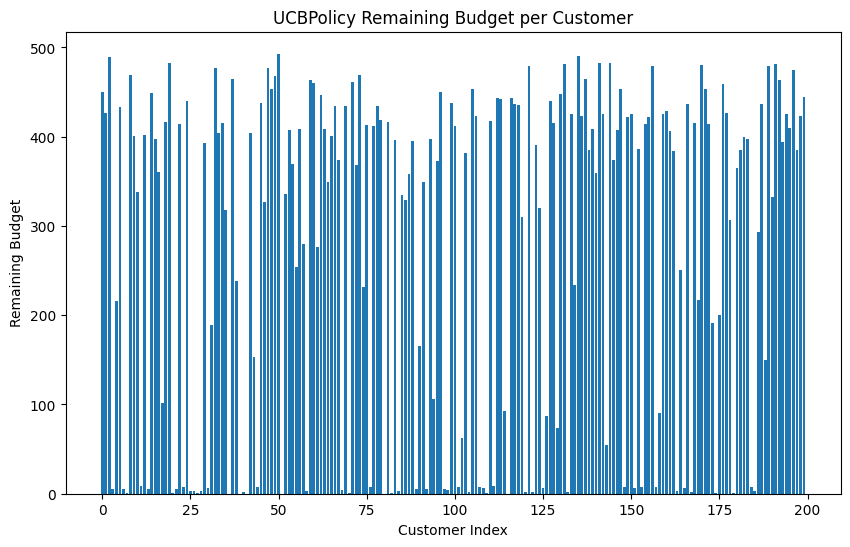

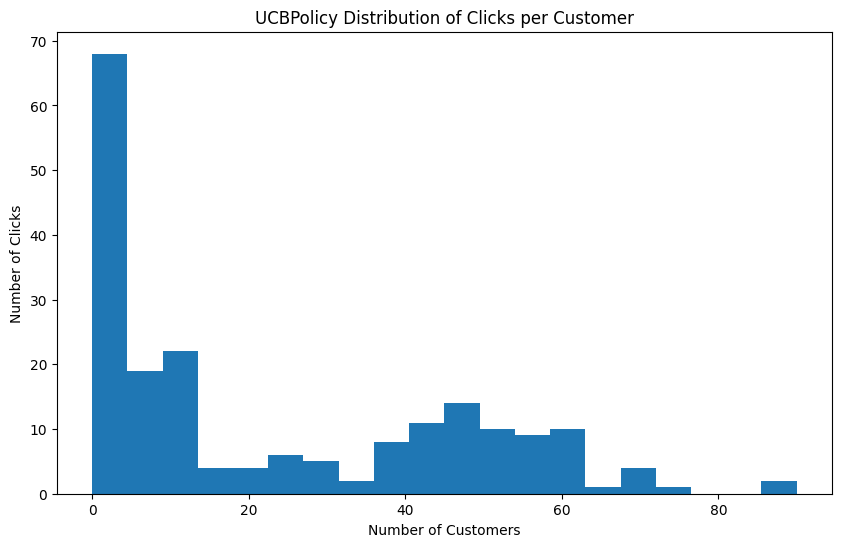


Results for ThompsonSampling:


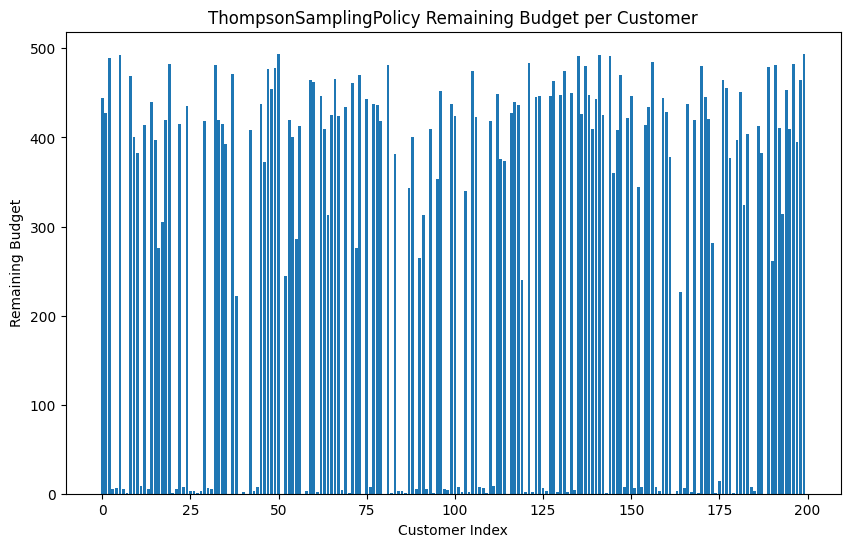

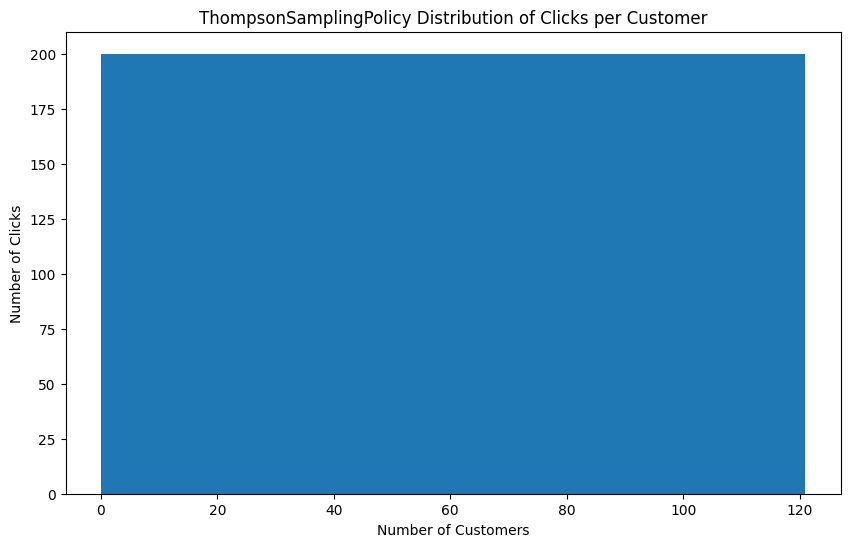


Running experiment with k=200, l=2, d=1


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


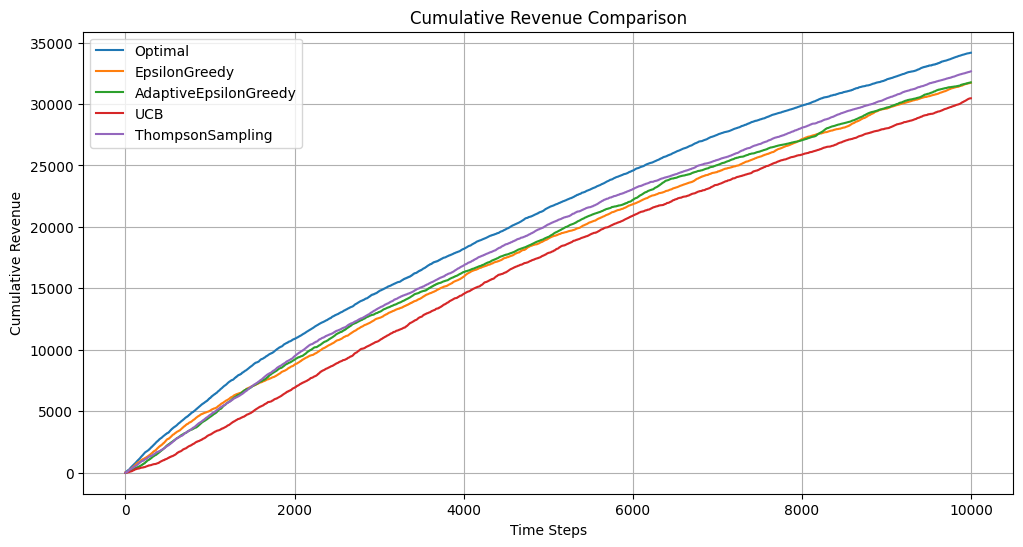

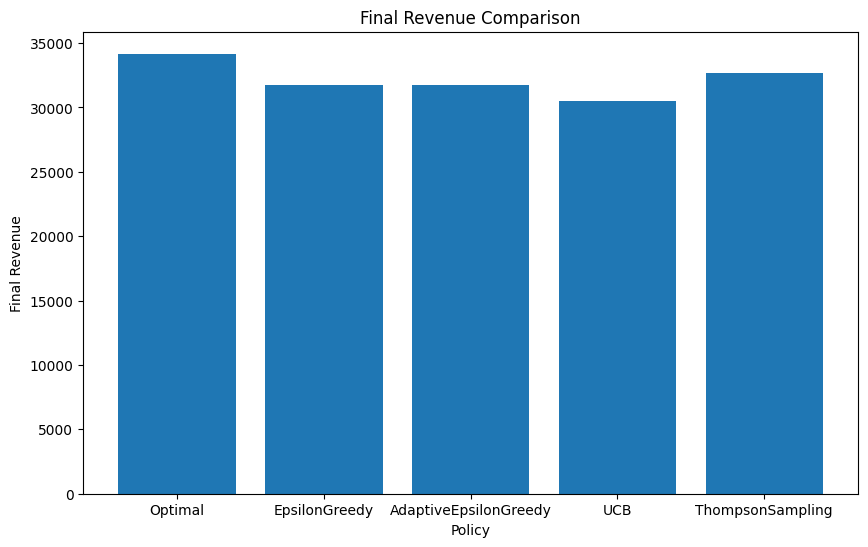

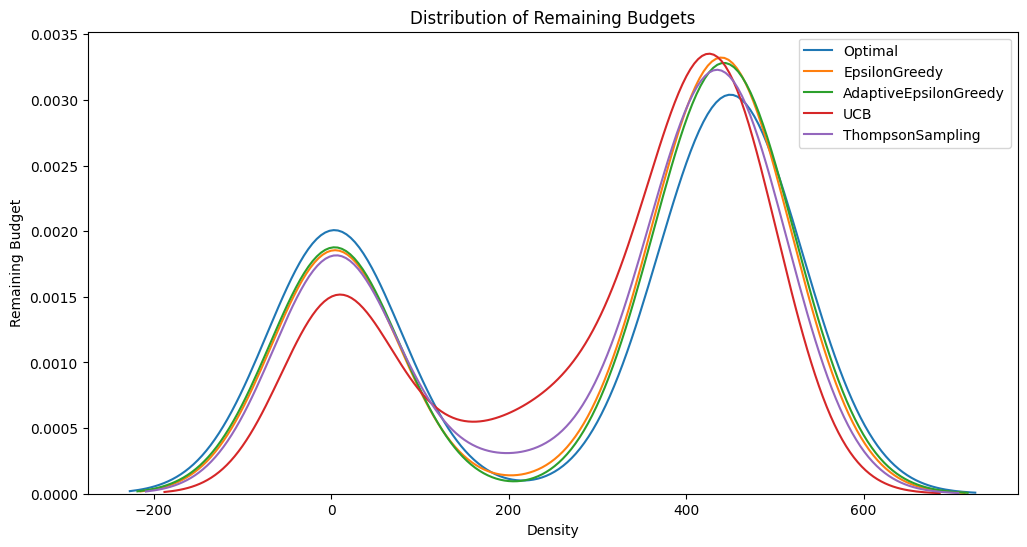

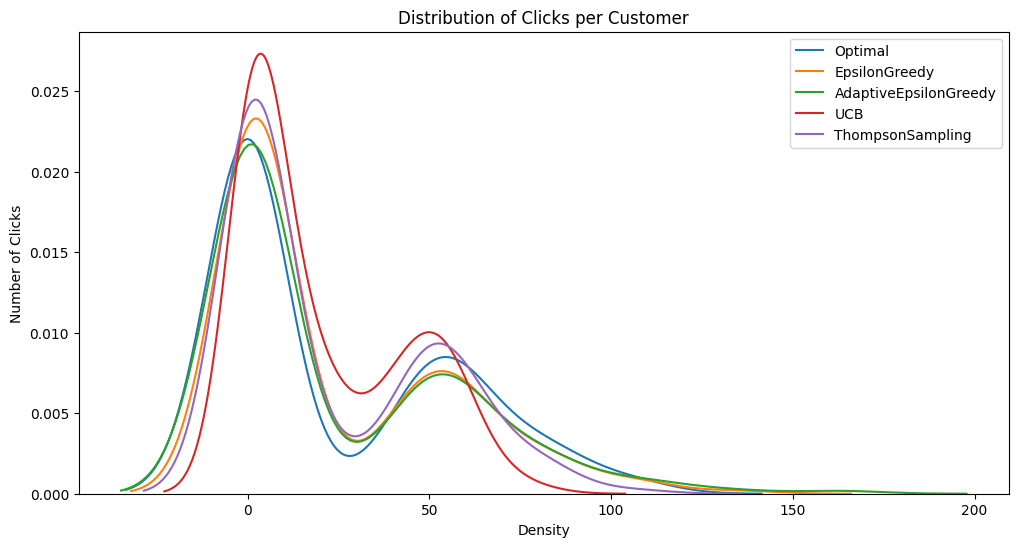

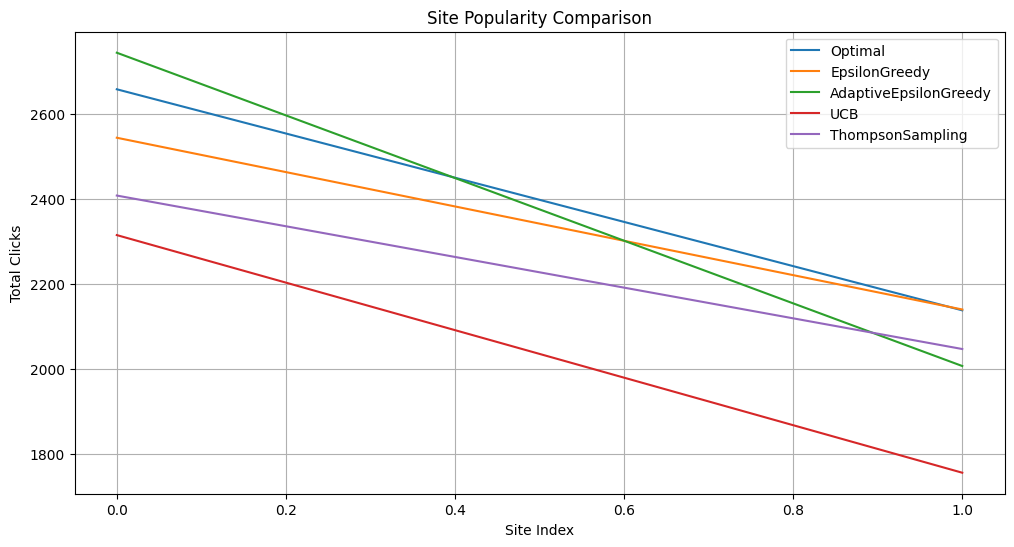


Results for Optimal:


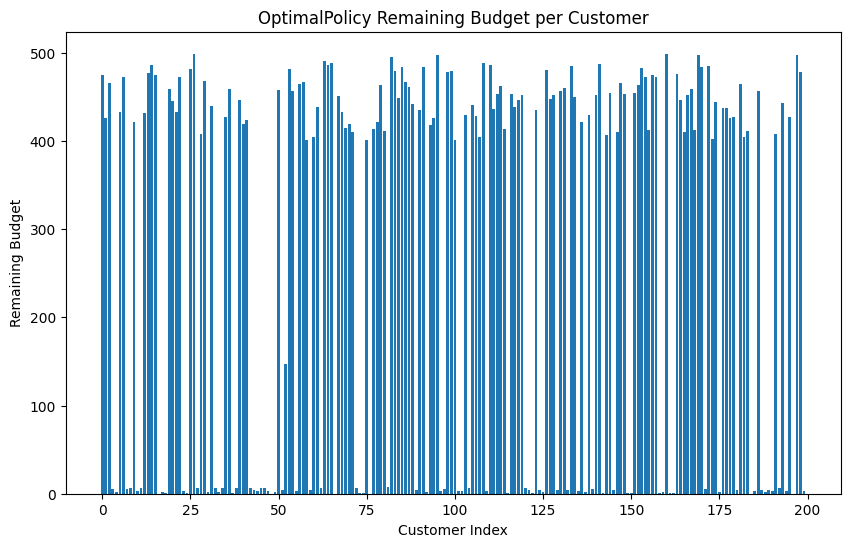

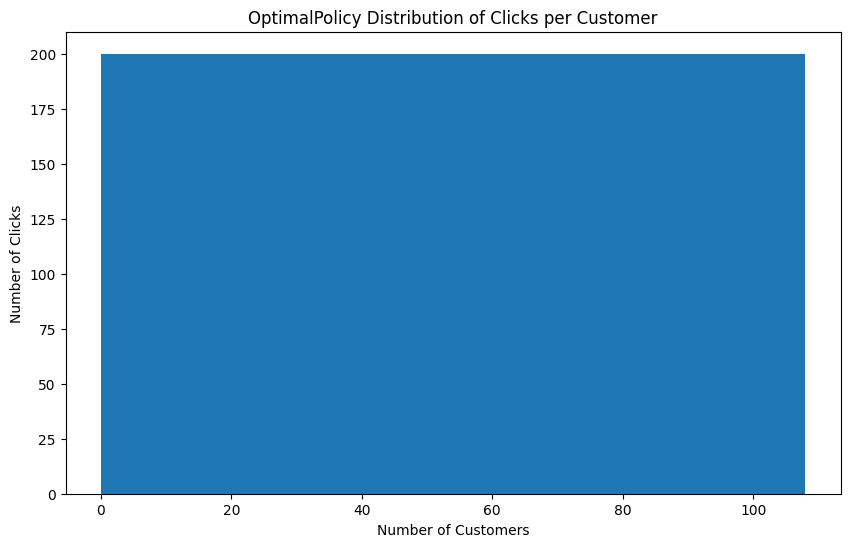


Results for EpsilonGreedy:


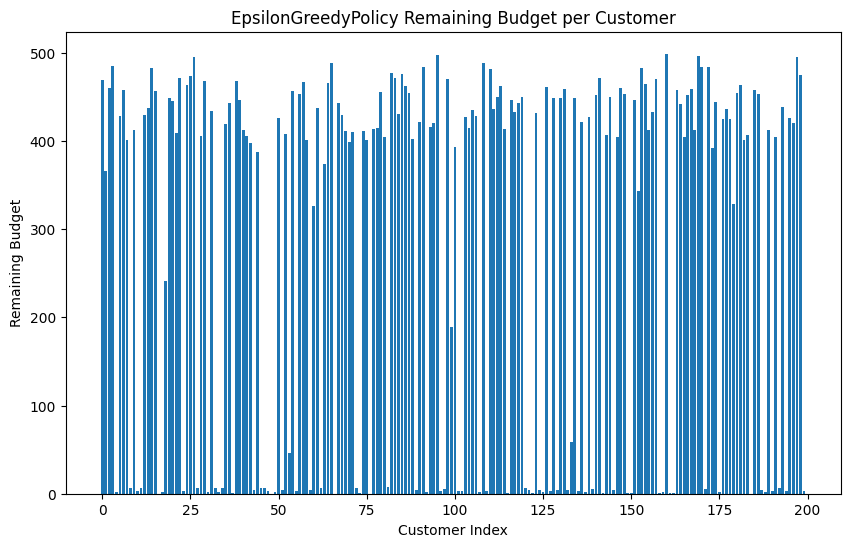

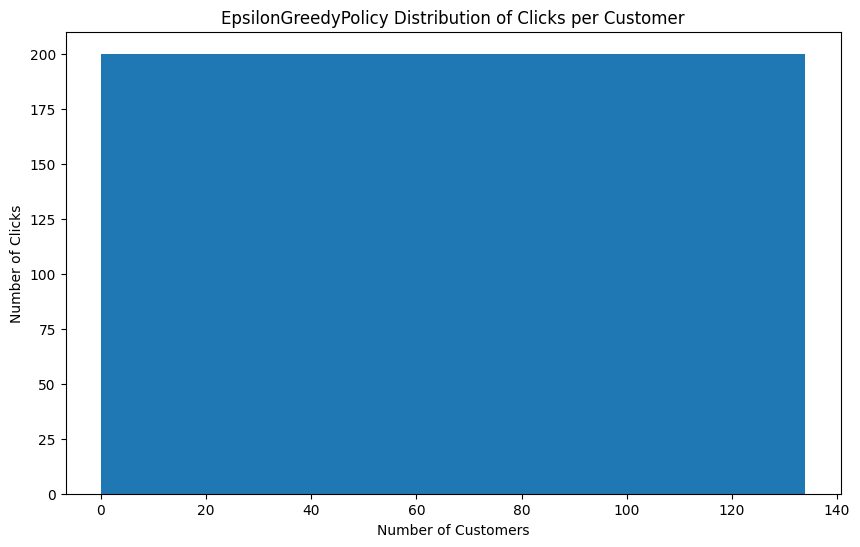


Results for AdaptiveEpsilonGreedy:


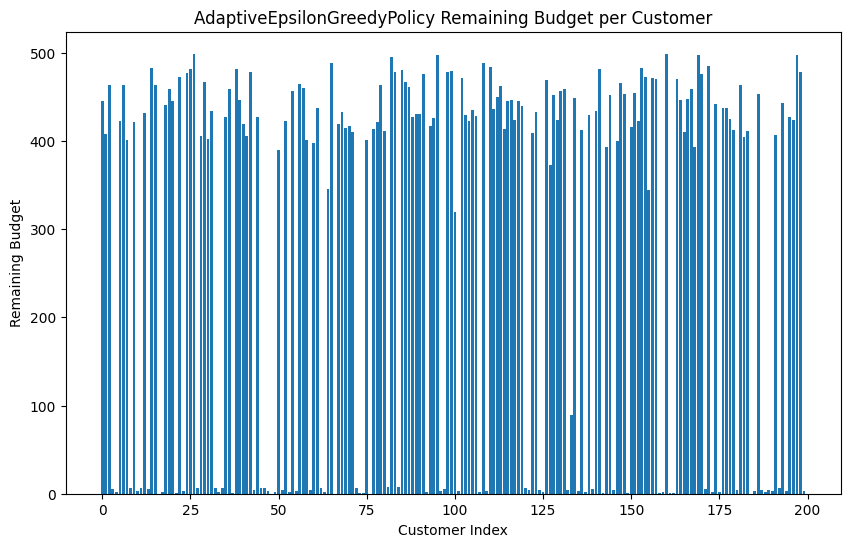

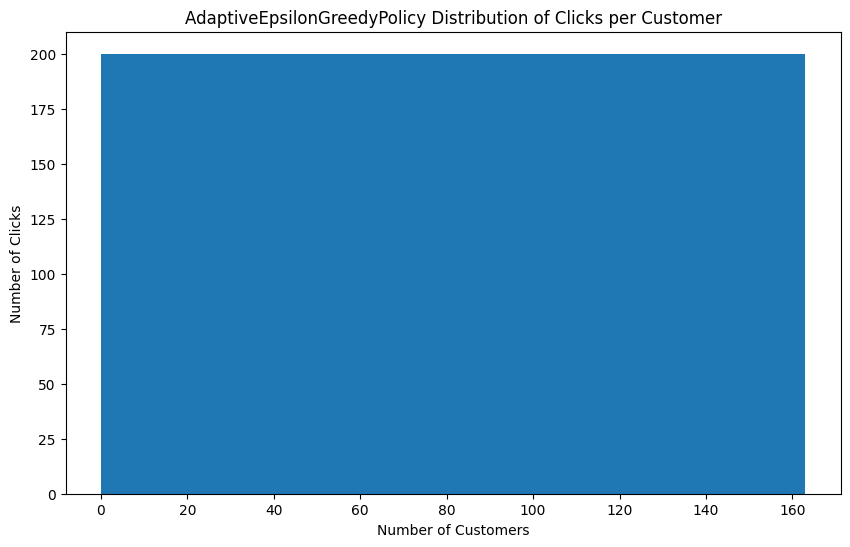


Results for UCB:


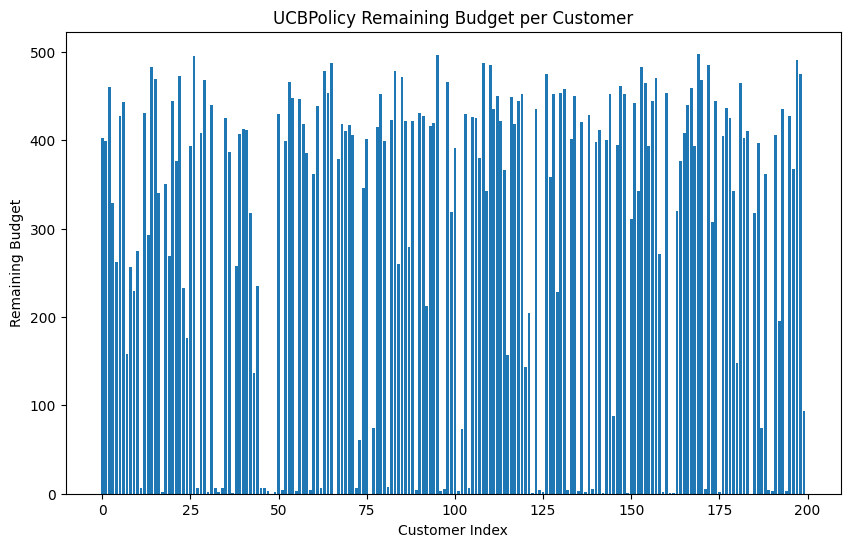

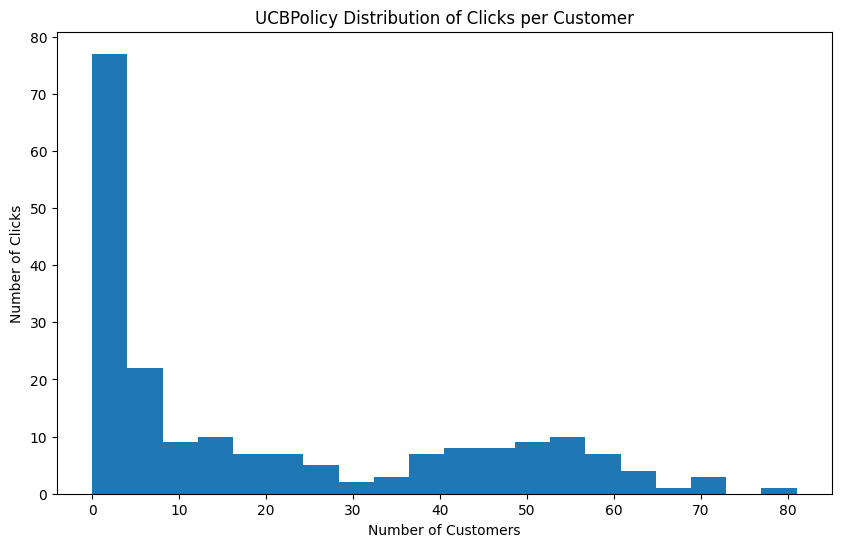


Results for ThompsonSampling:


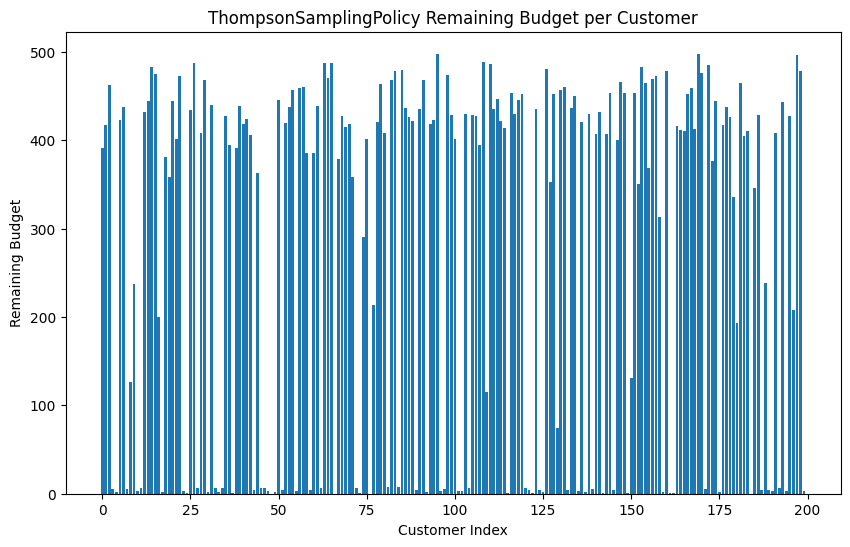

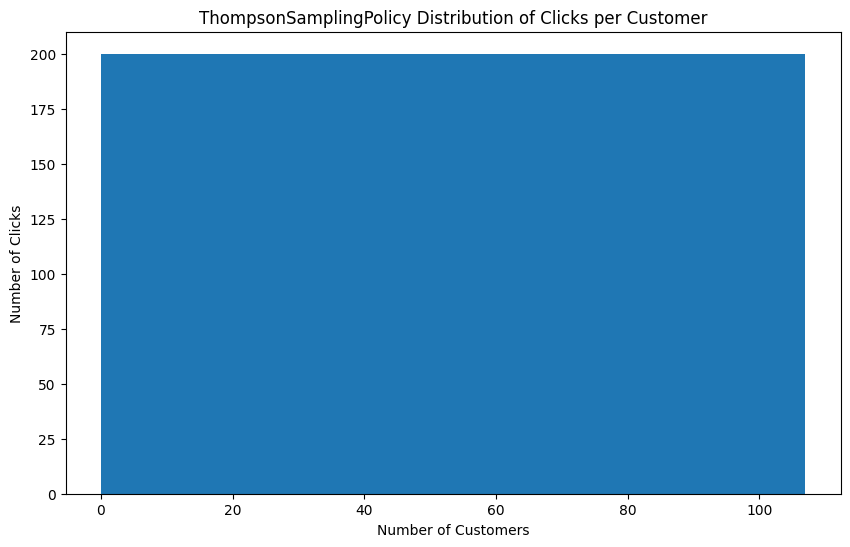


Running experiment with k=200, l=10, d=1


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


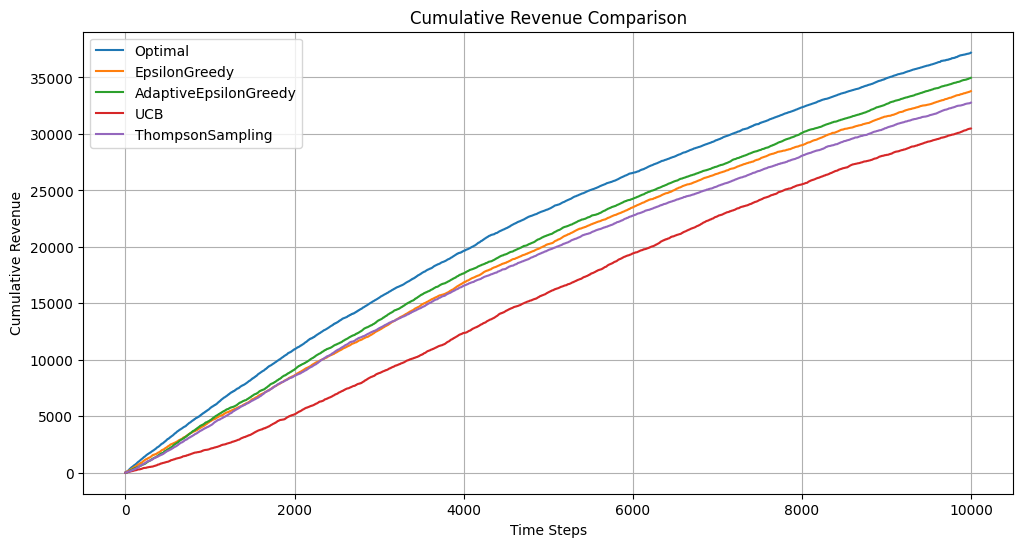

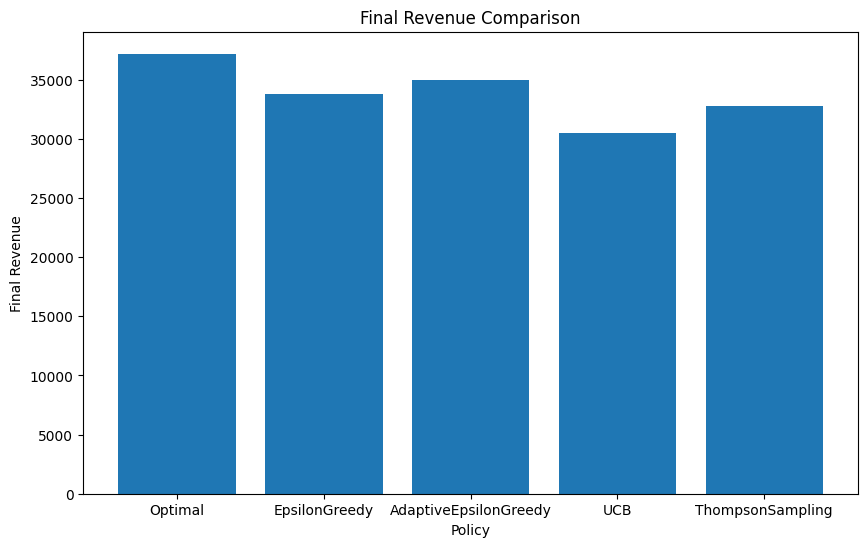

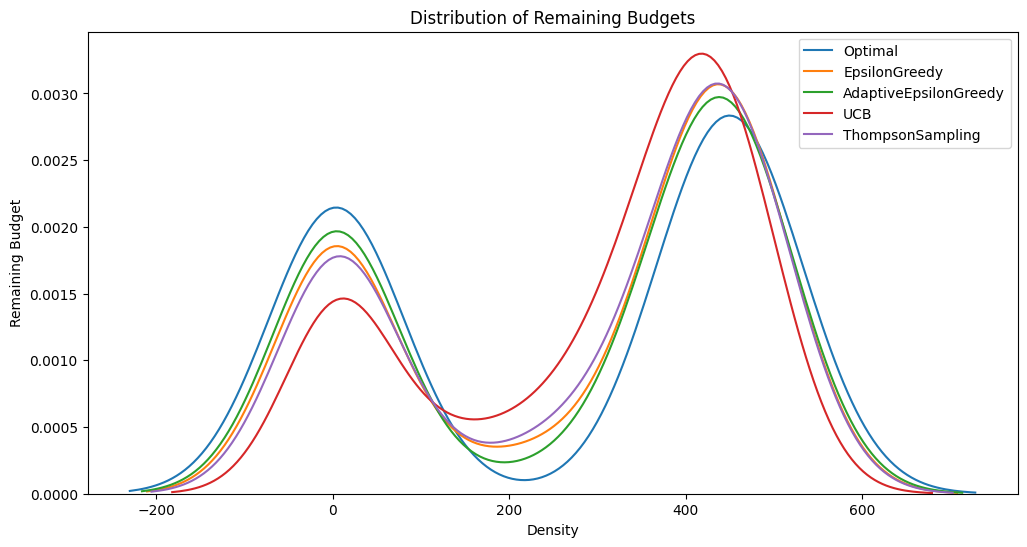

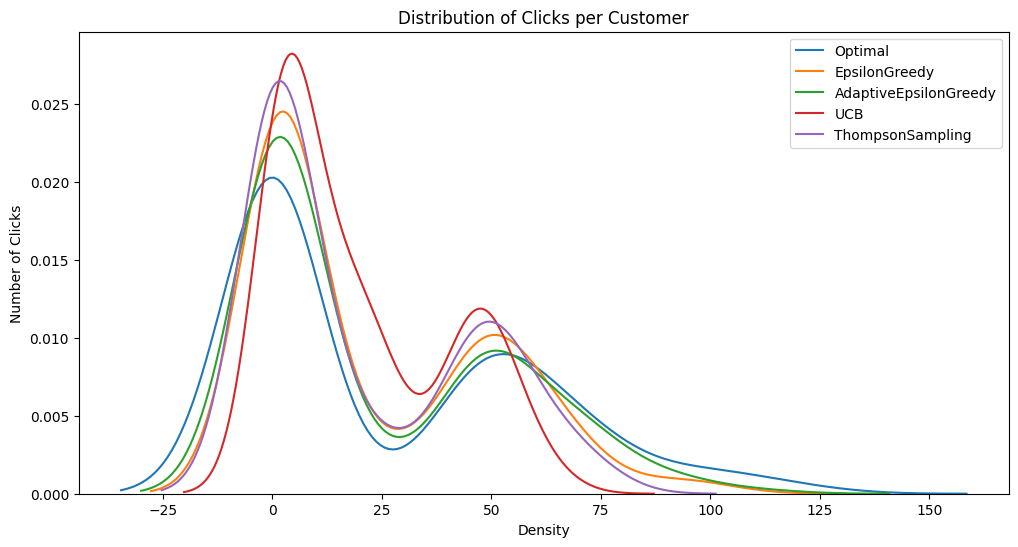

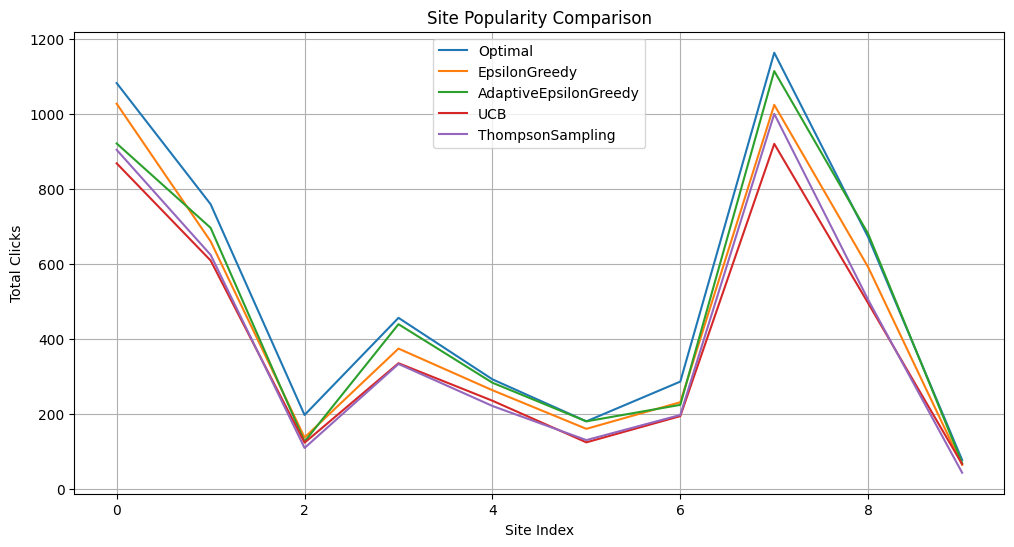


Results for Optimal:


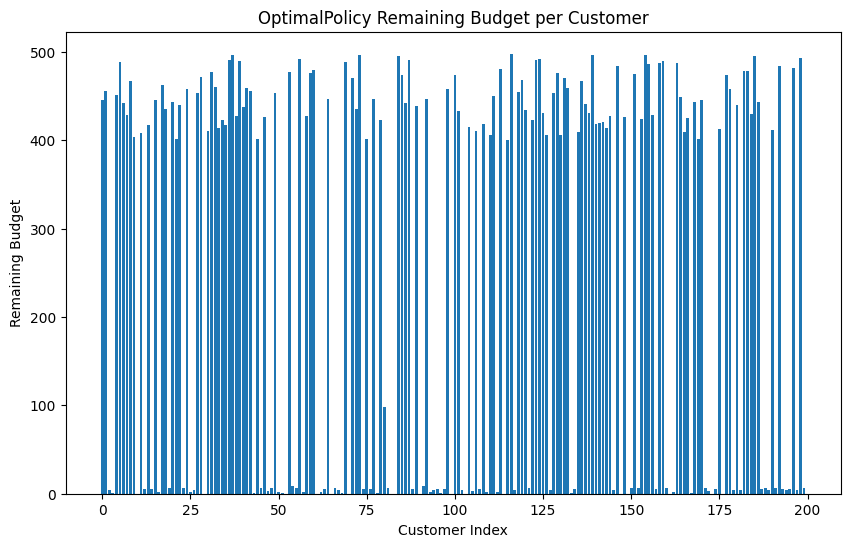

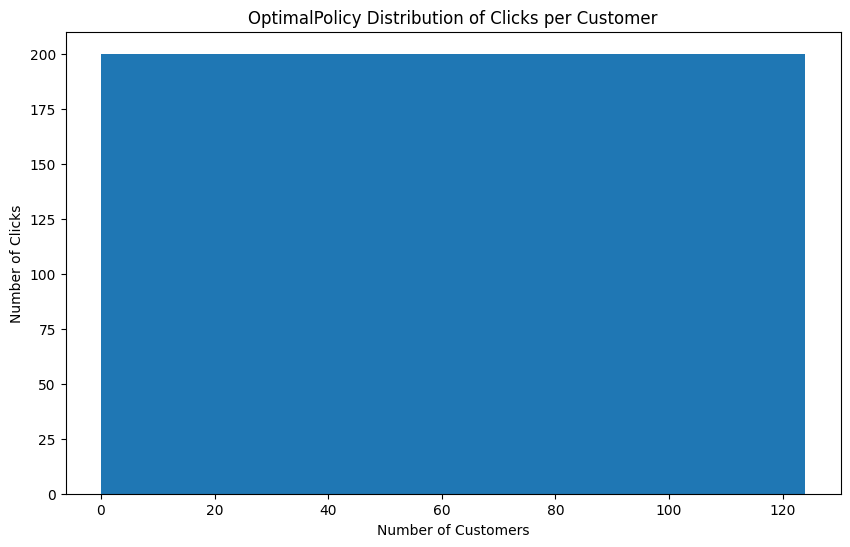


Results for EpsilonGreedy:


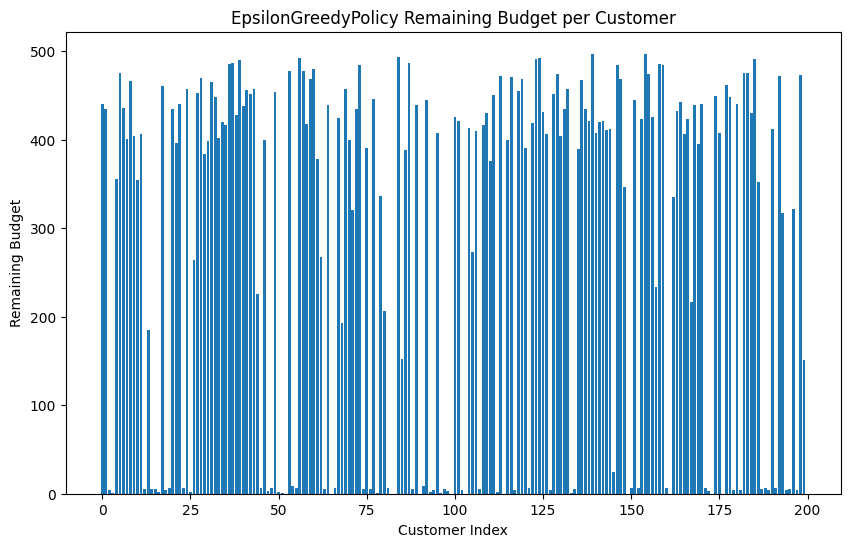

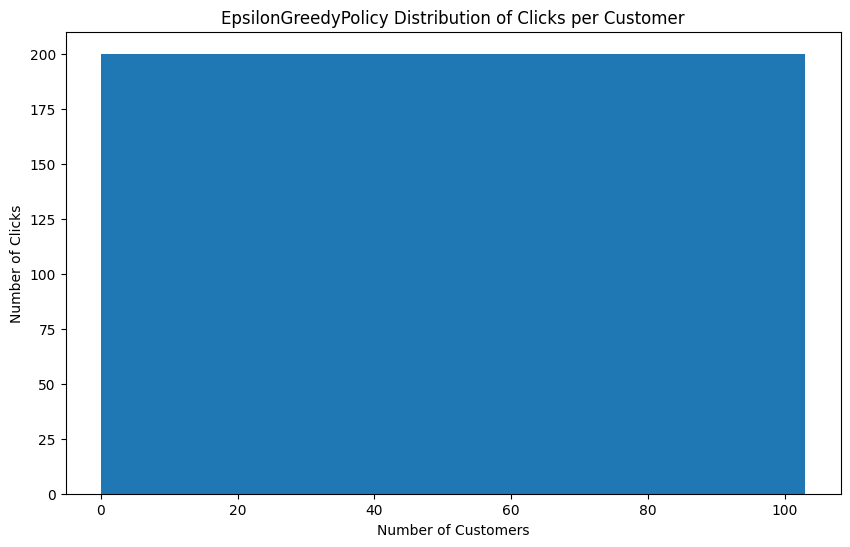


Results for AdaptiveEpsilonGreedy:


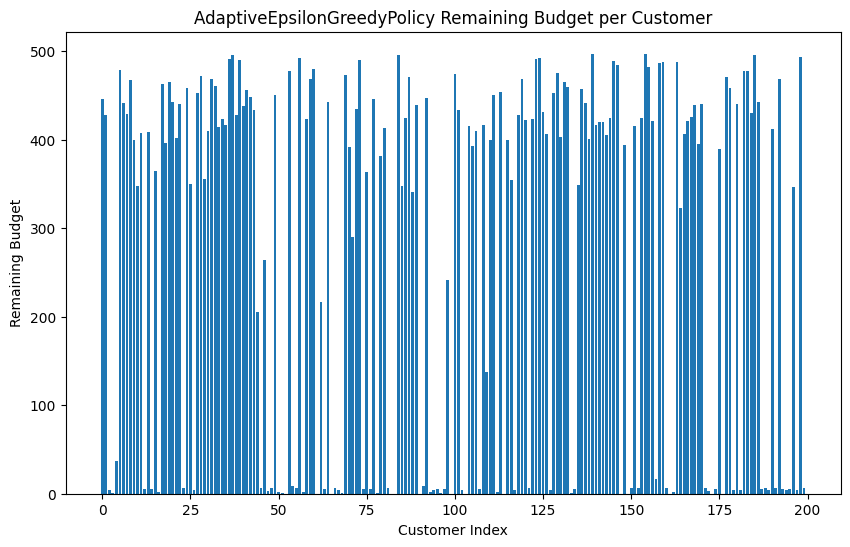

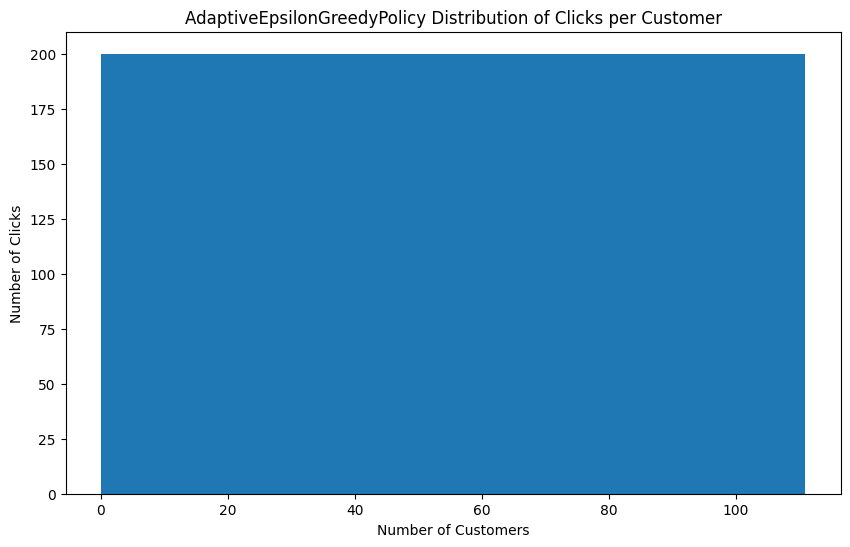


Results for UCB:


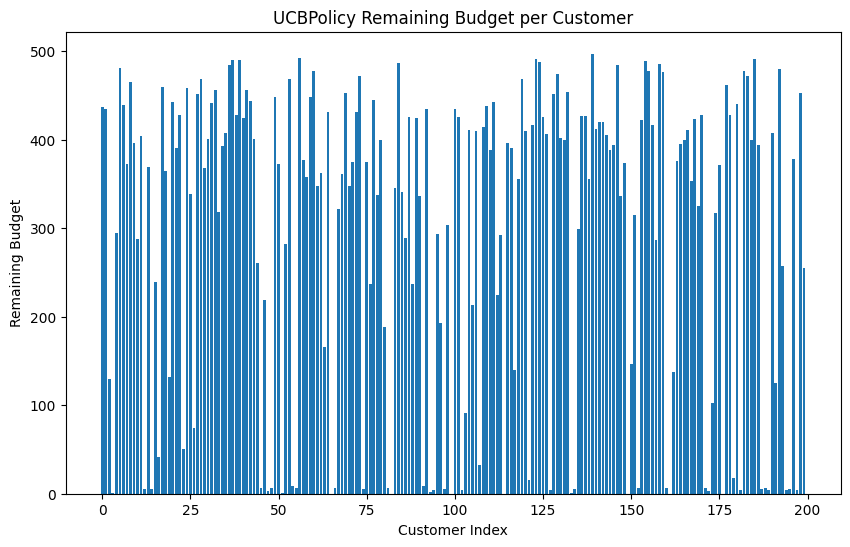

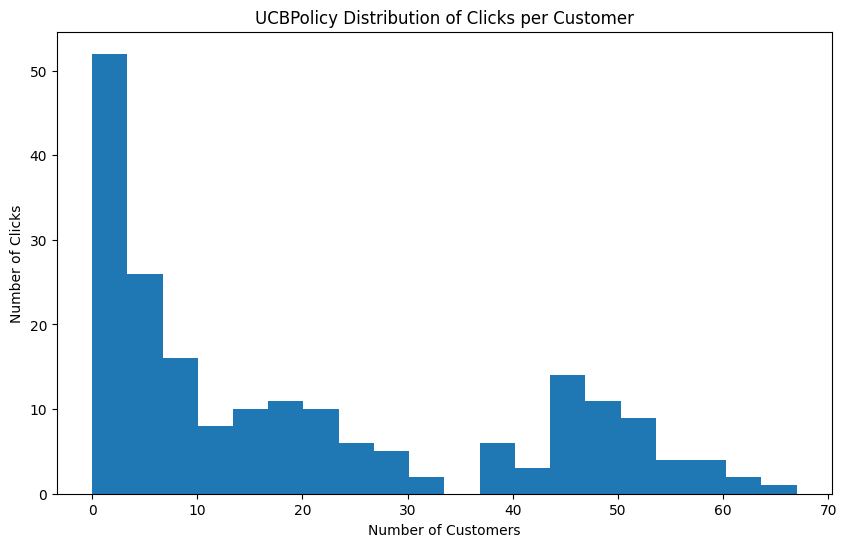


Results for ThompsonSampling:


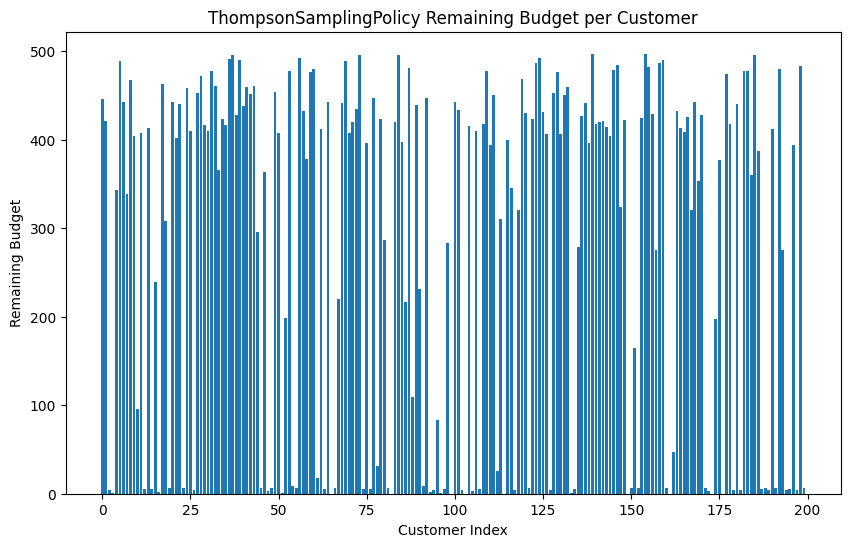

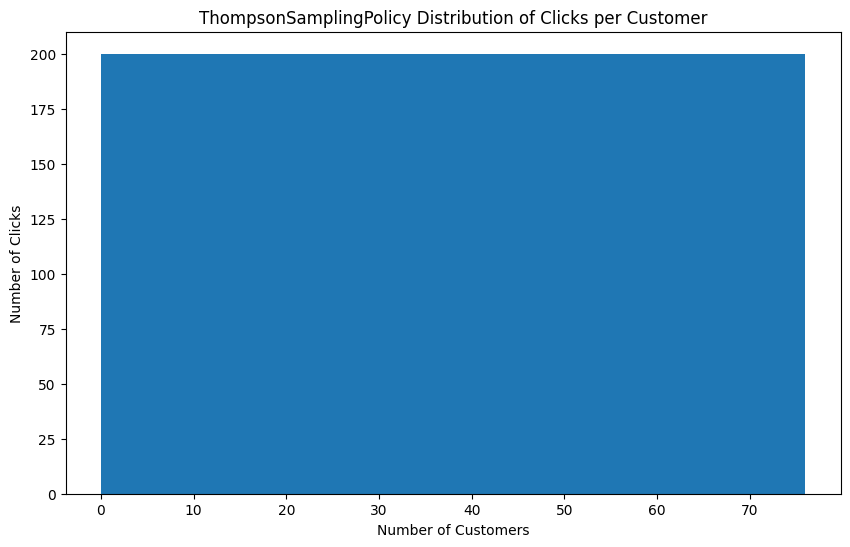


Running experiment with k=200, l=1, d=2


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


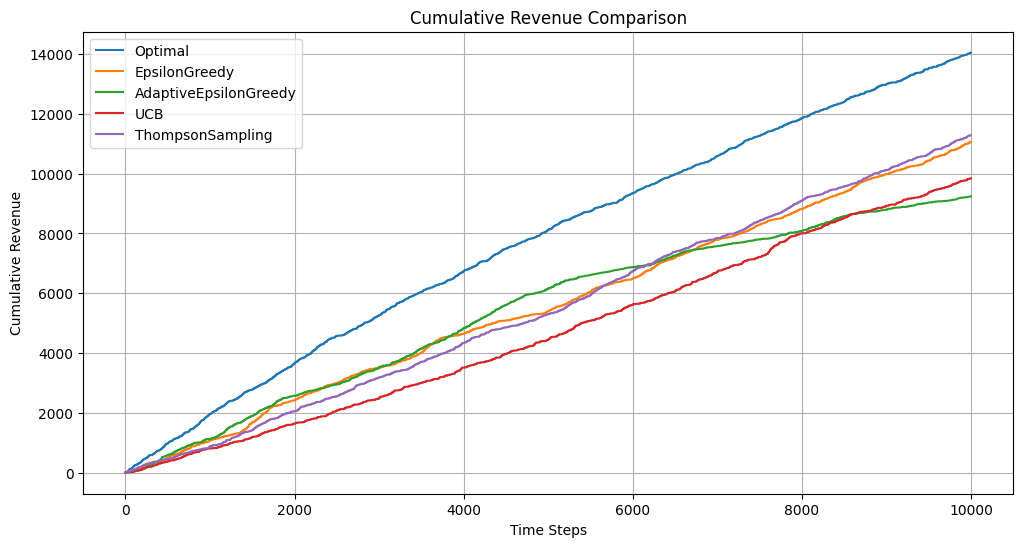

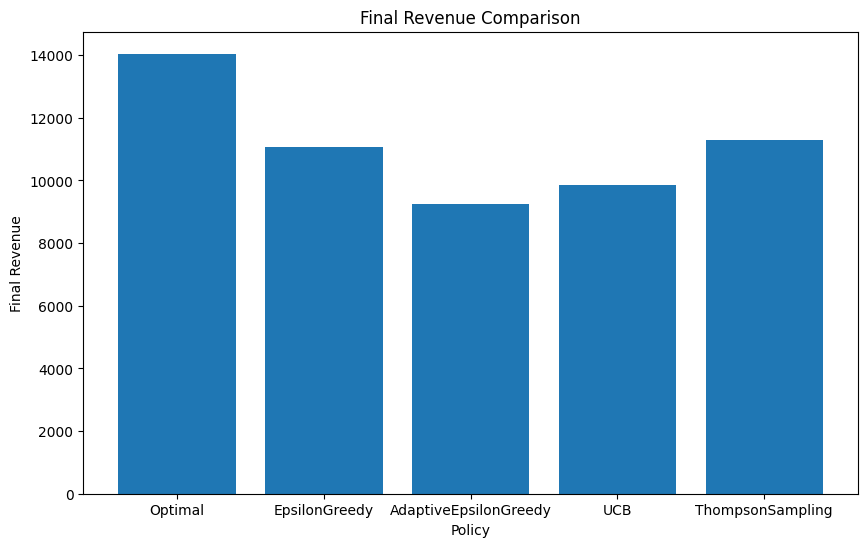

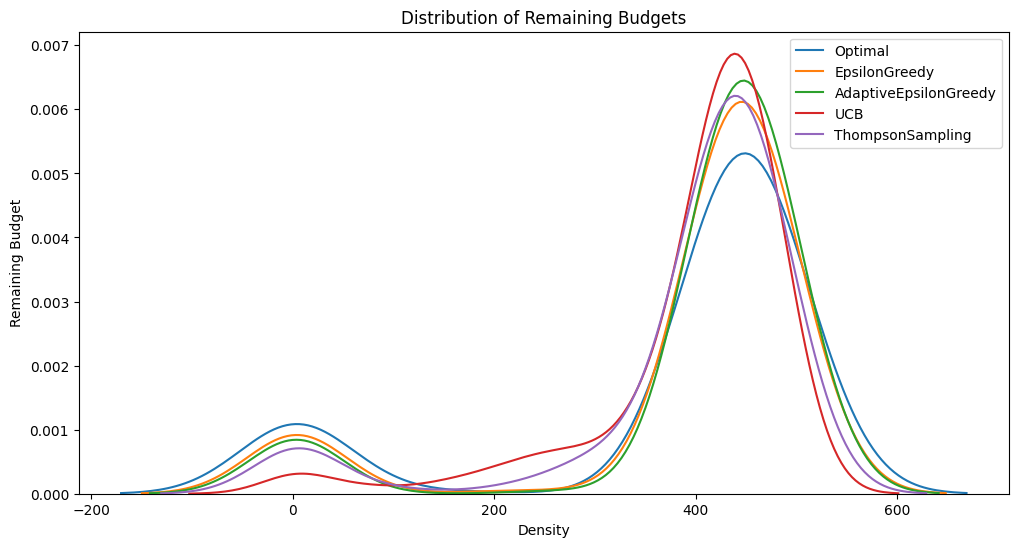

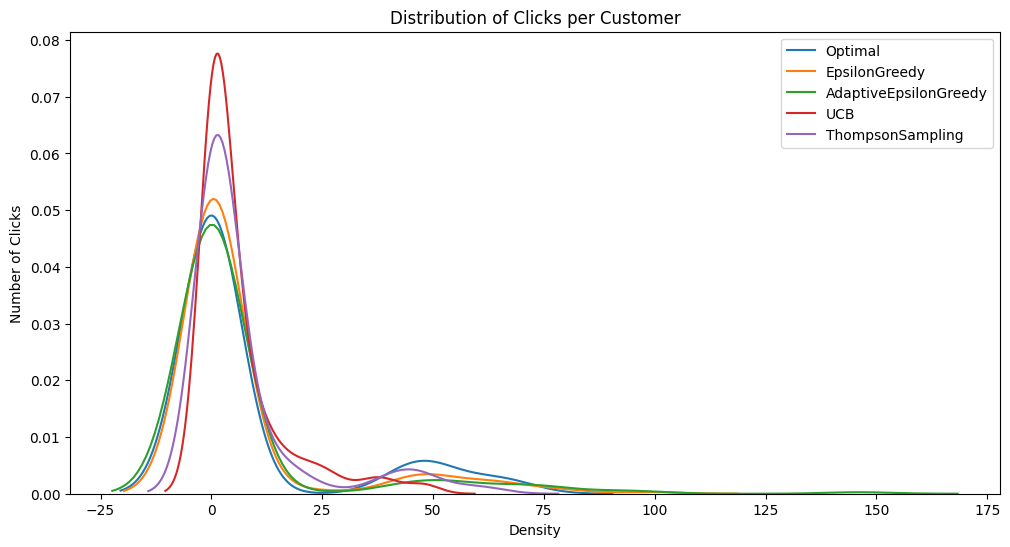

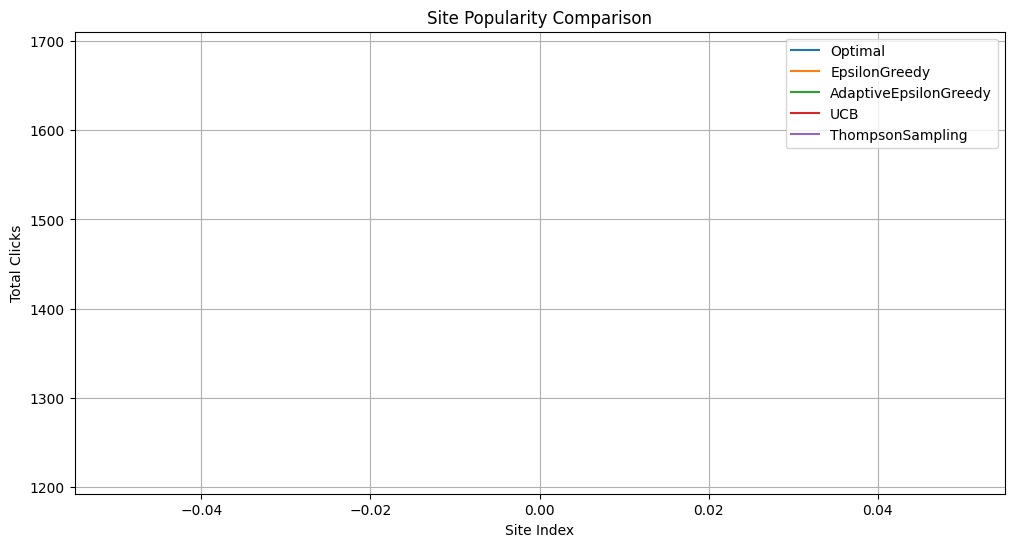


Results for Optimal:


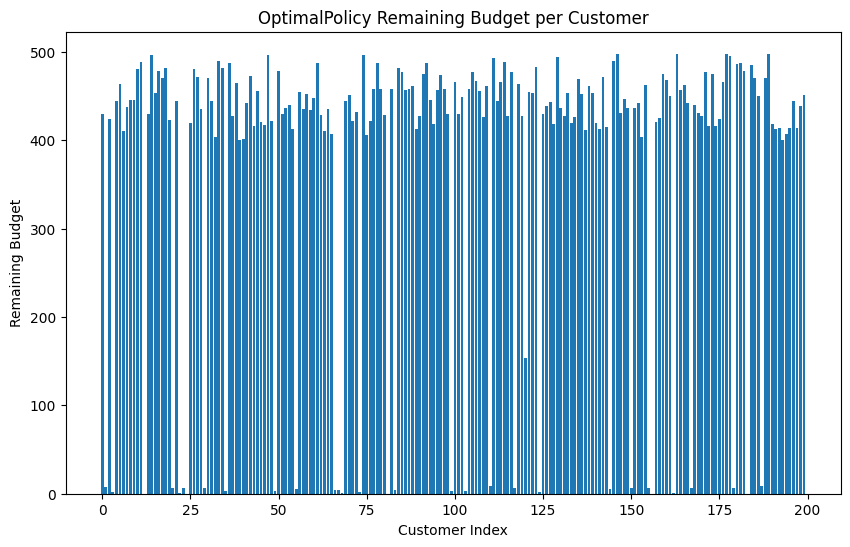

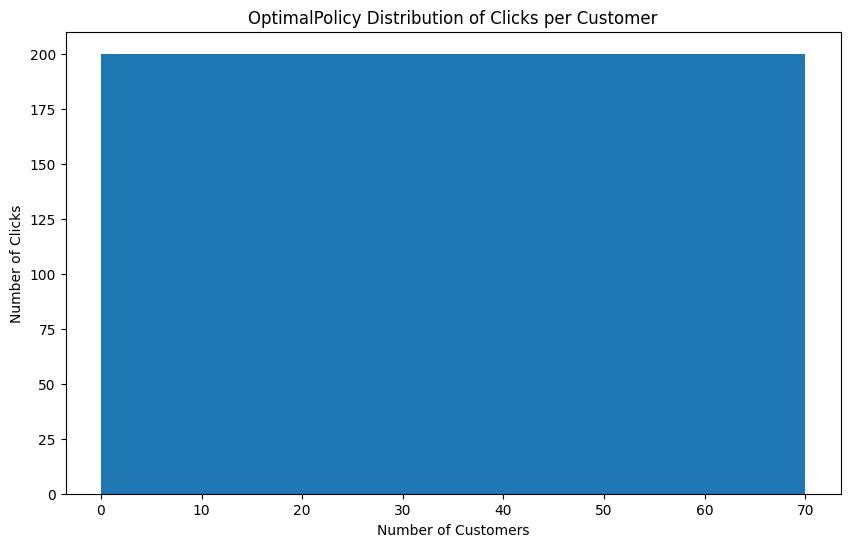


Results for EpsilonGreedy:


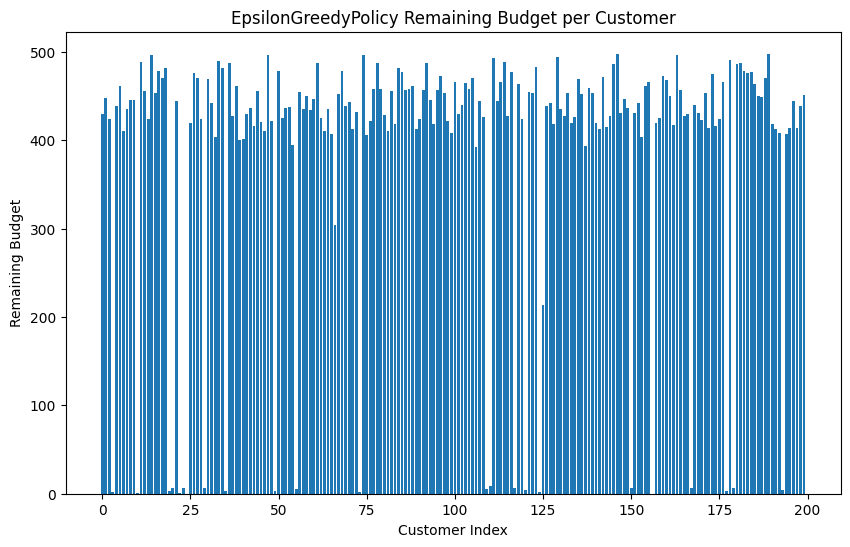

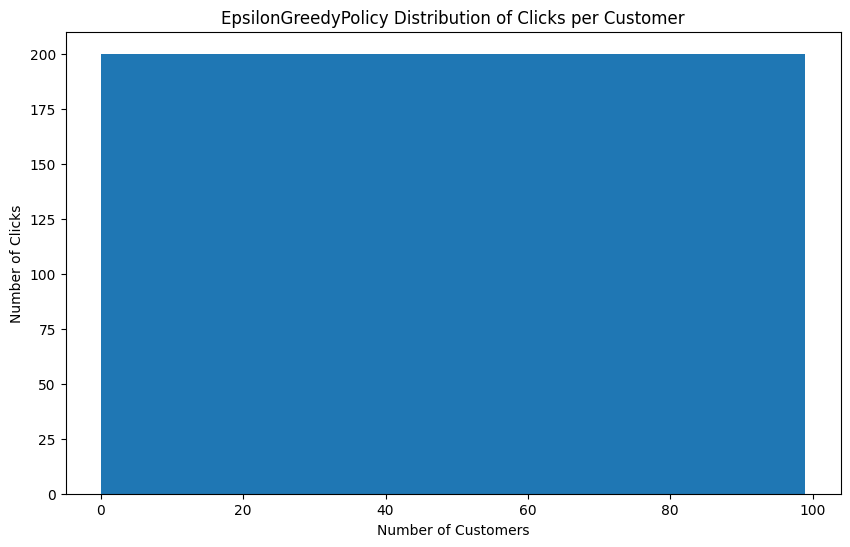


Results for AdaptiveEpsilonGreedy:


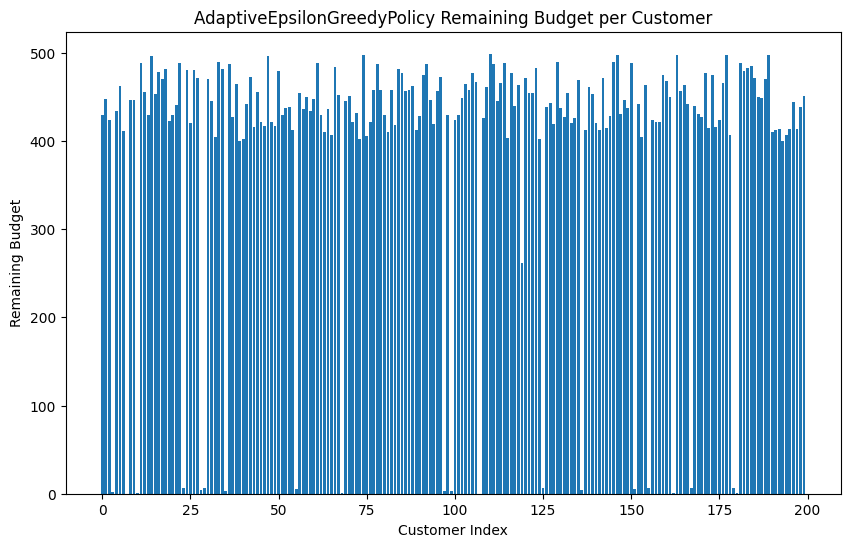

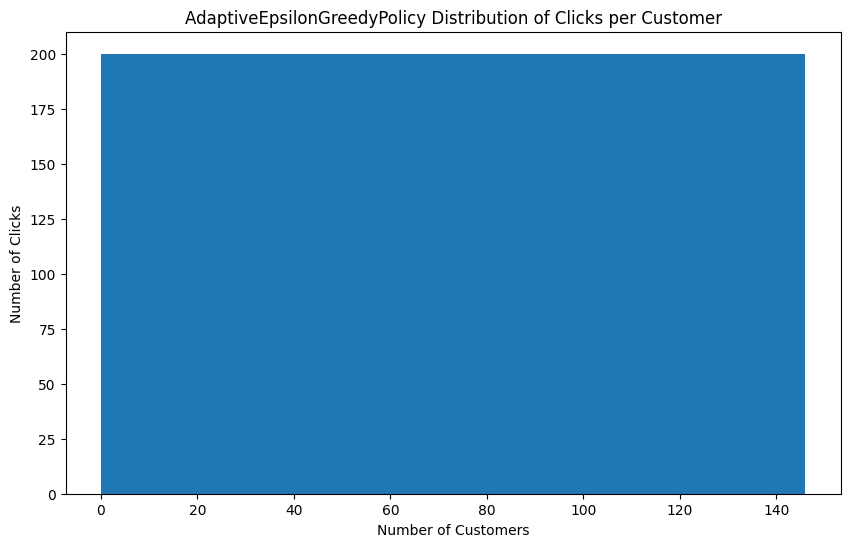


Results for UCB:


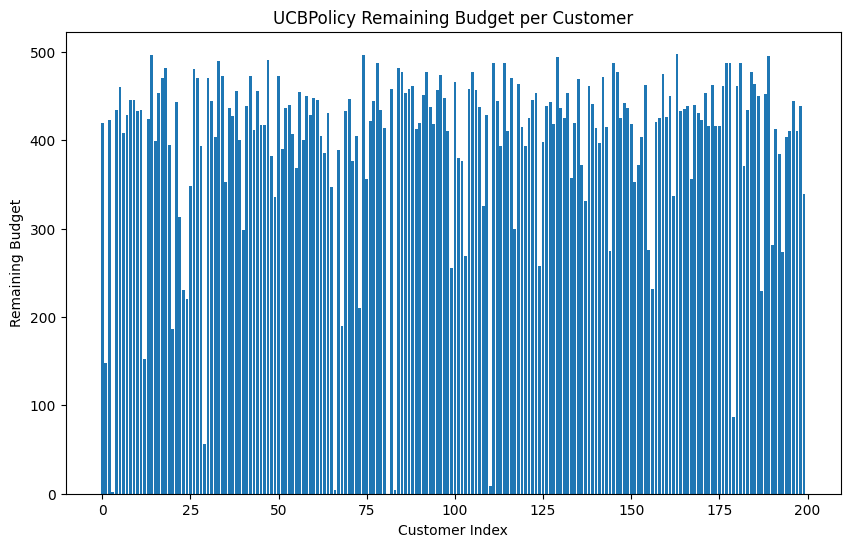

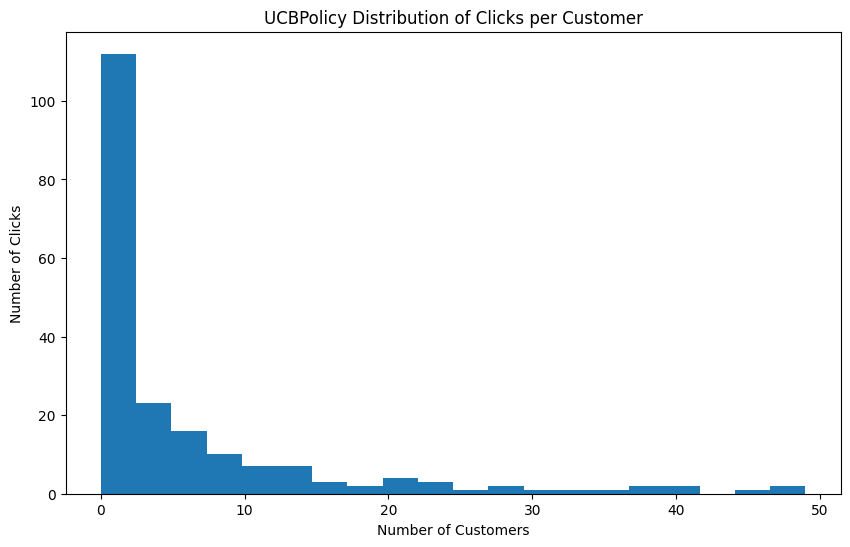


Results for ThompsonSampling:


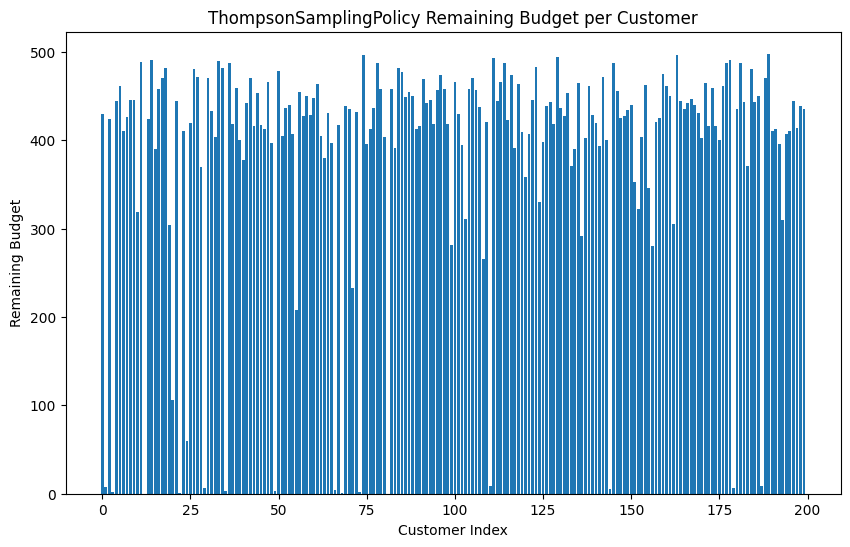

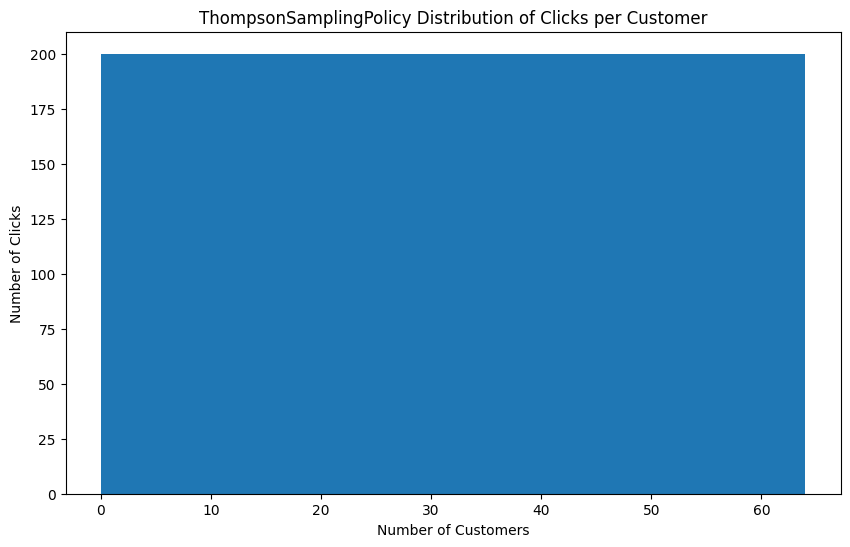


Running experiment with k=200, l=2, d=2


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


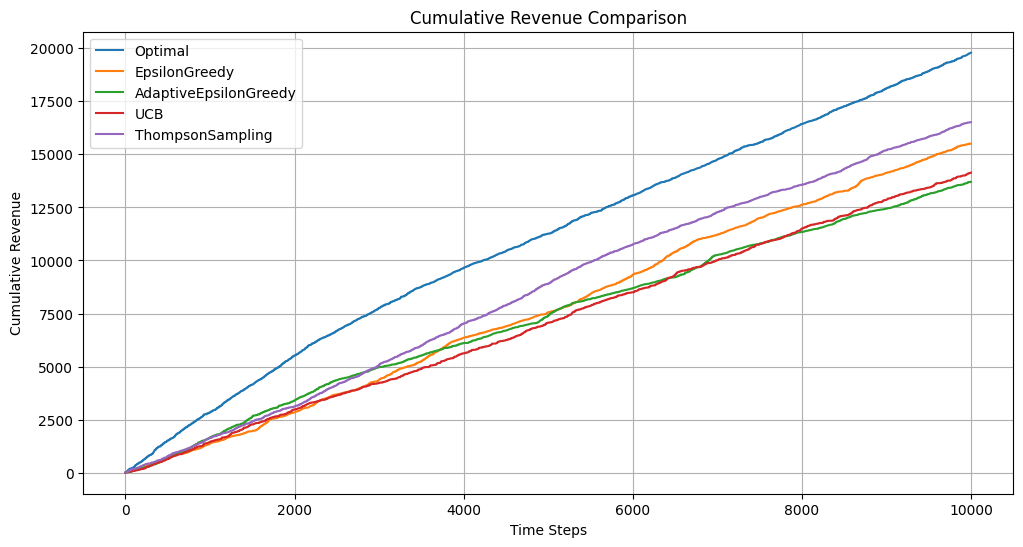

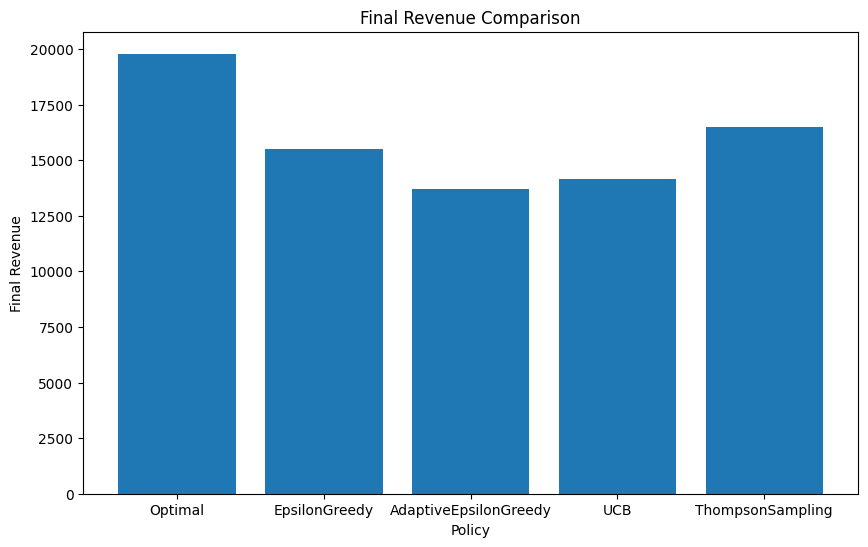

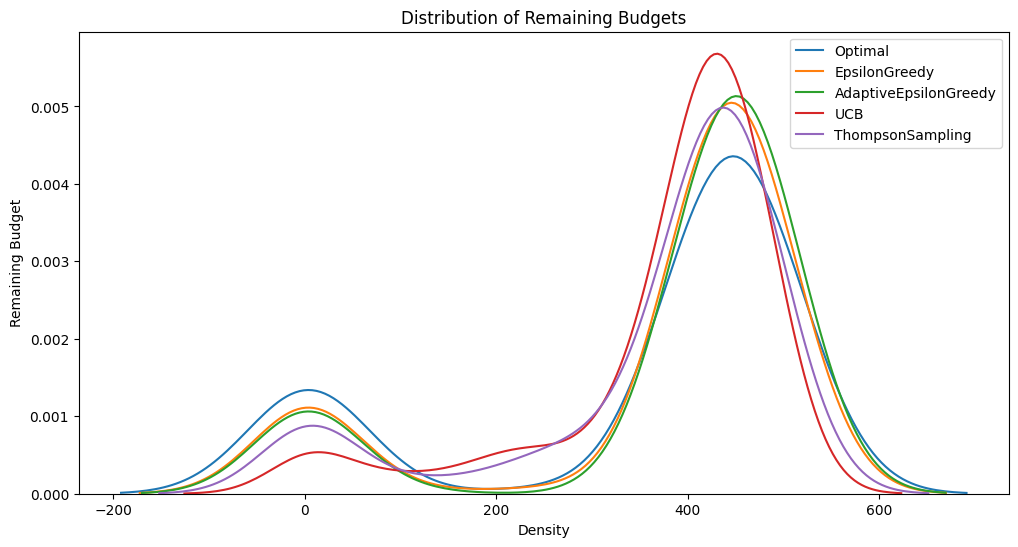

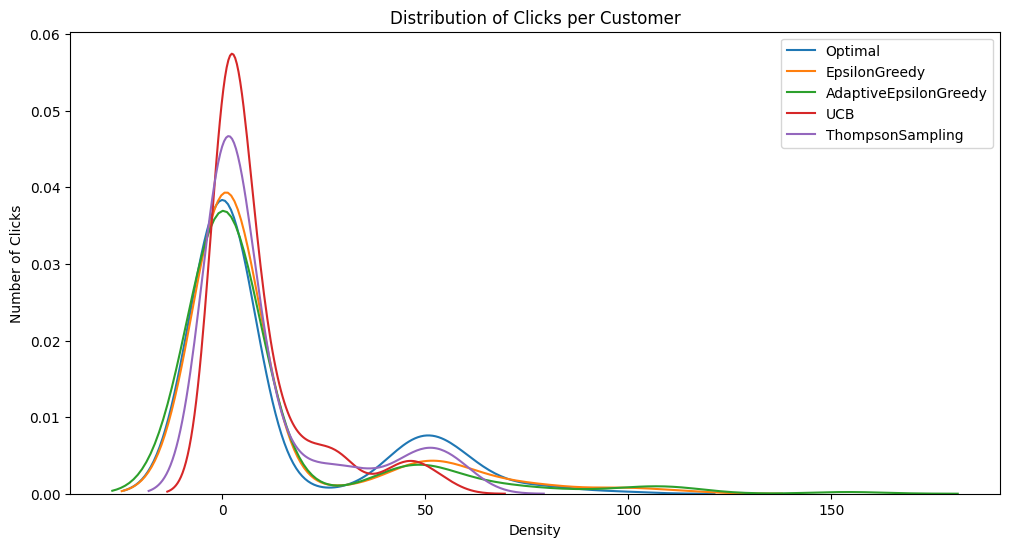

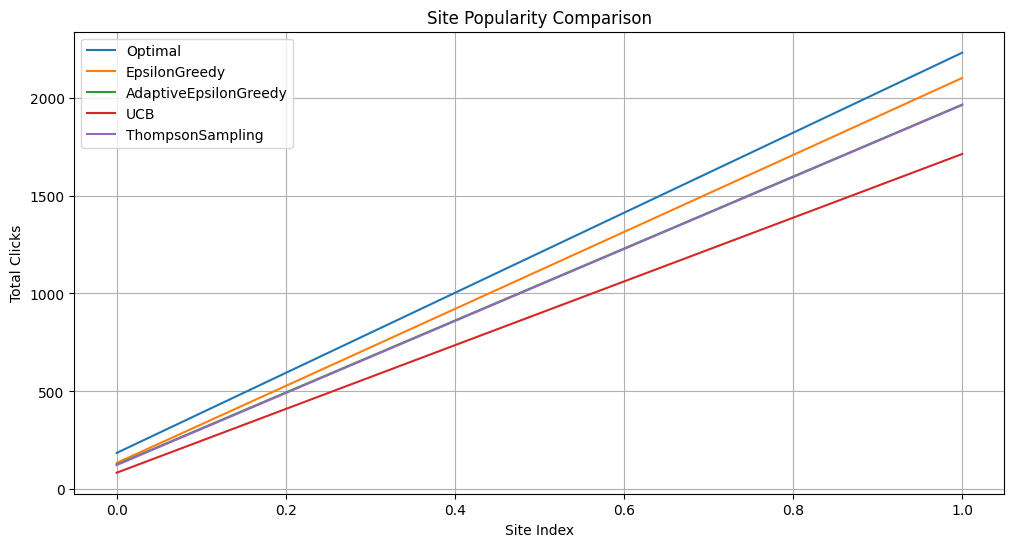


Results for Optimal:


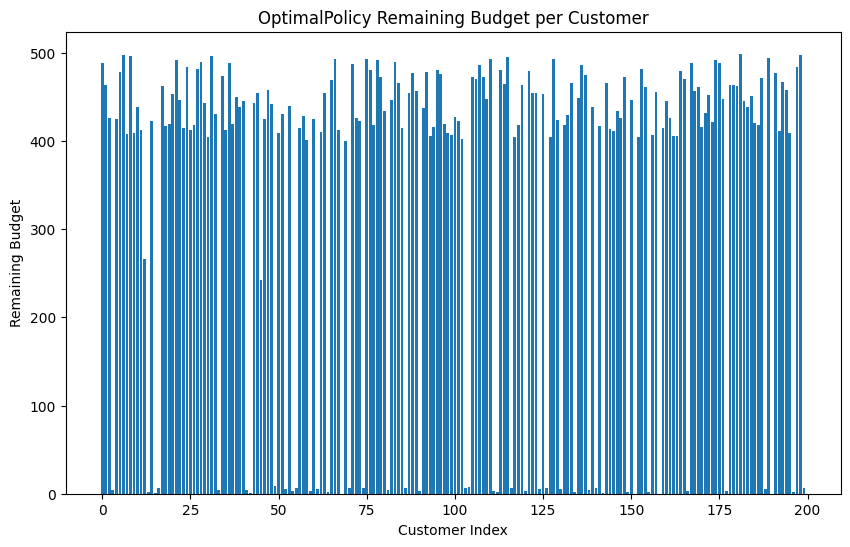

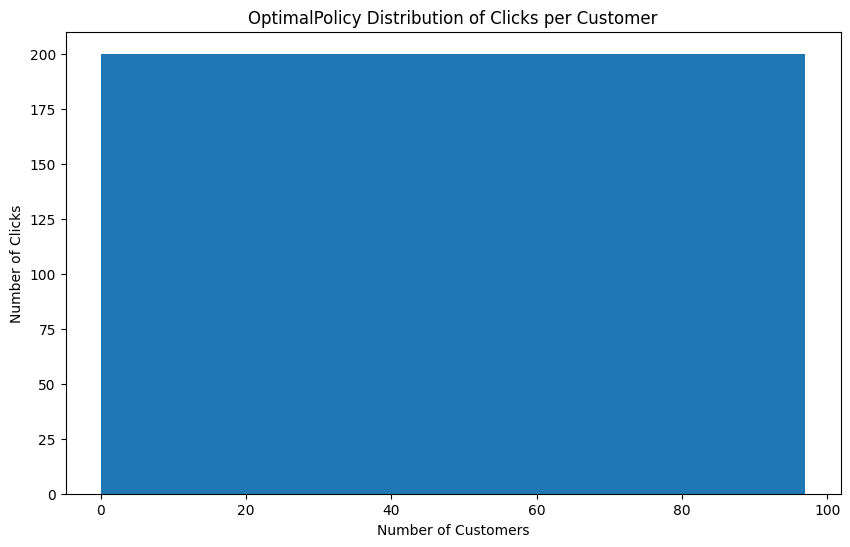


Results for EpsilonGreedy:


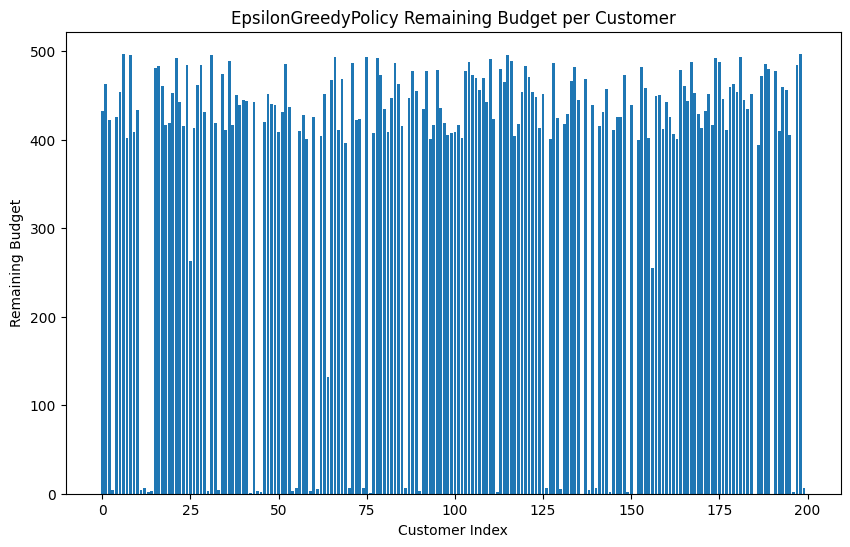

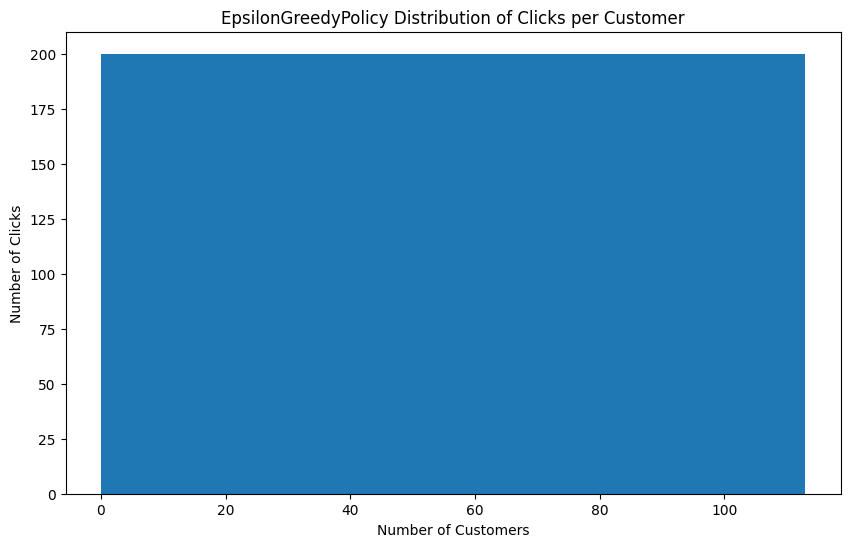


Results for AdaptiveEpsilonGreedy:


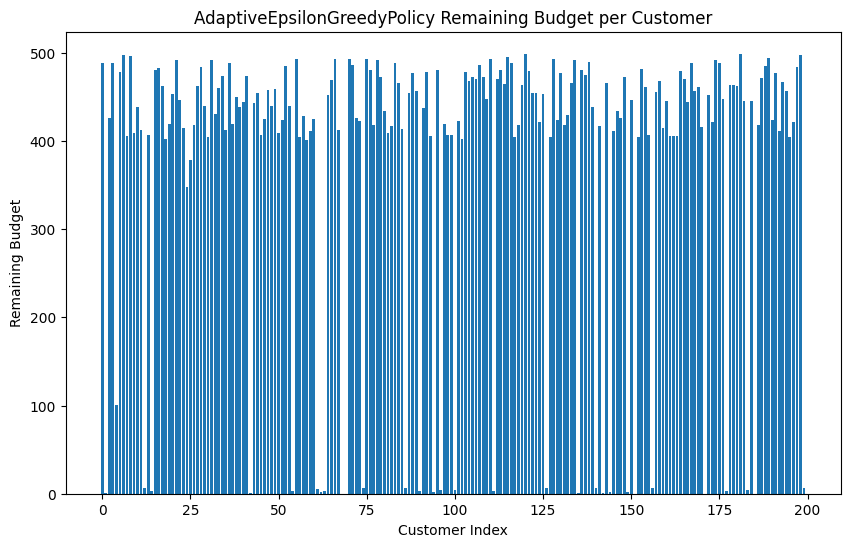

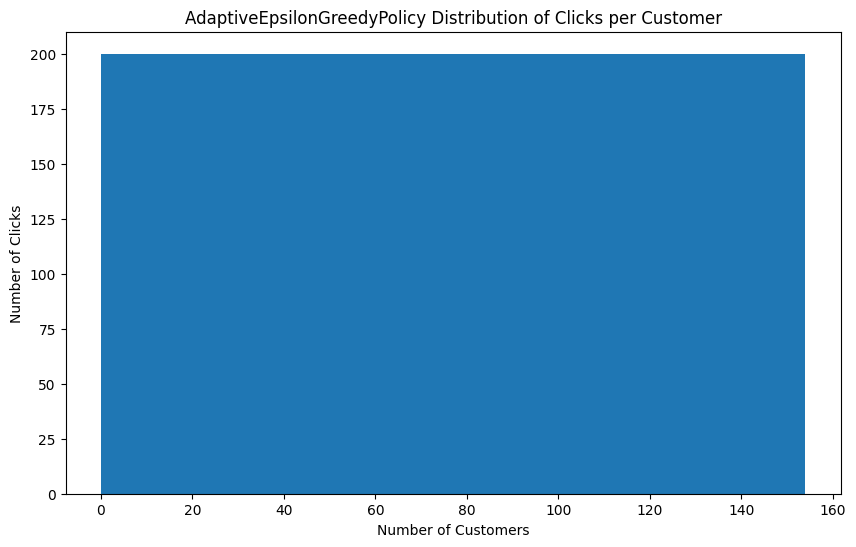


Results for UCB:


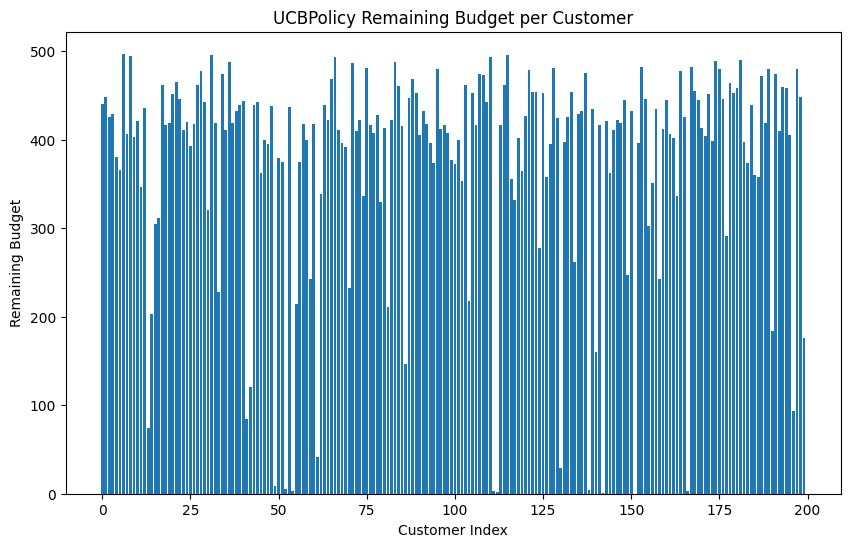

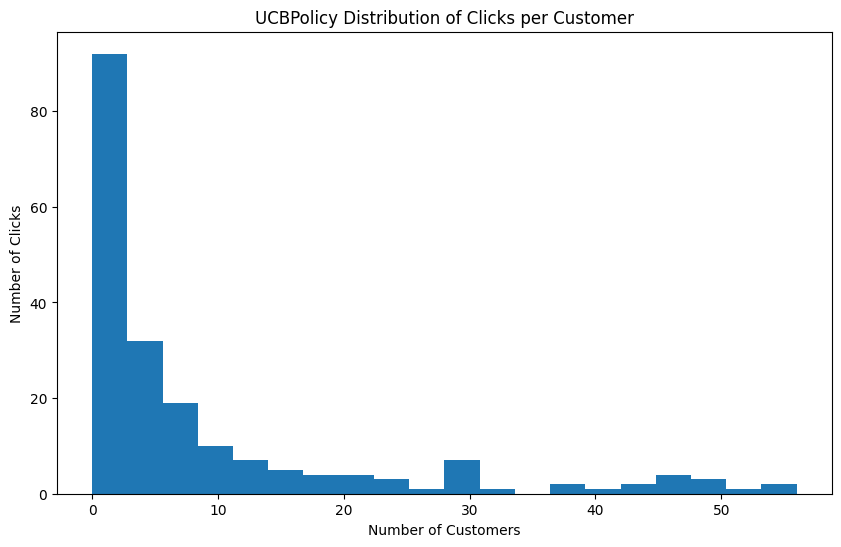


Results for ThompsonSampling:


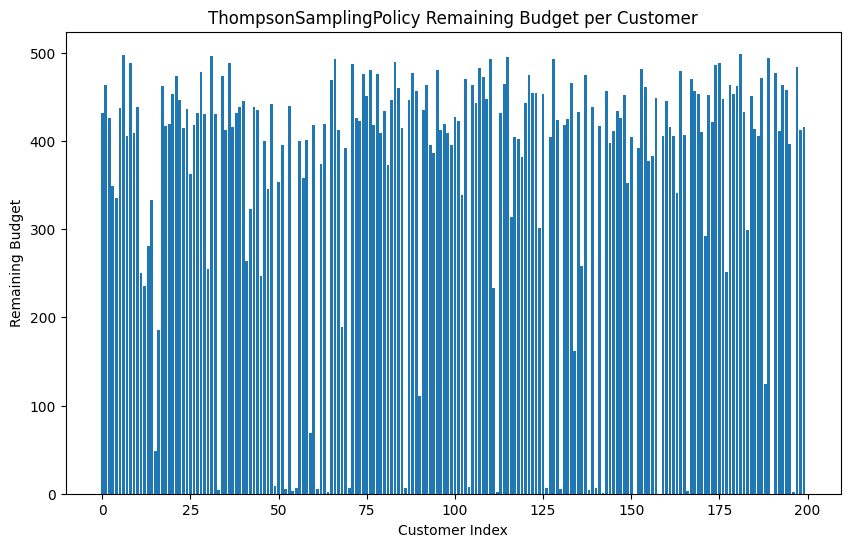

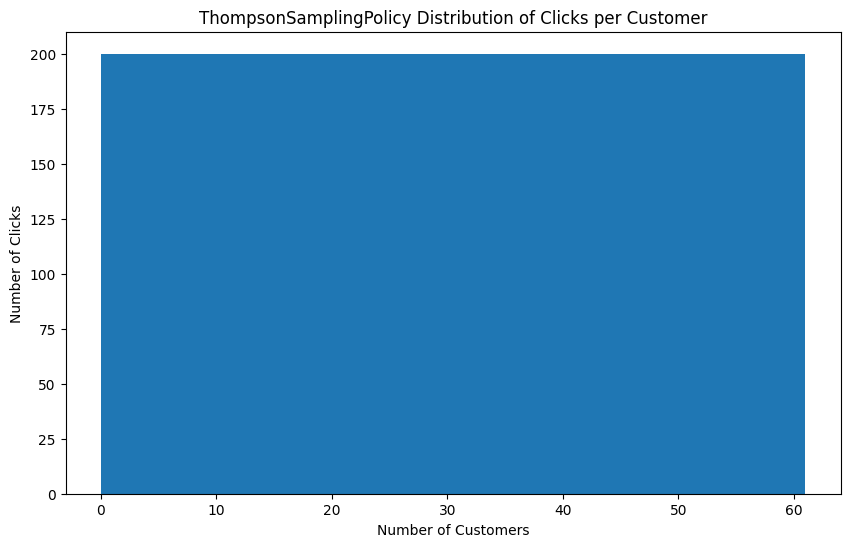


Running experiment with k=200, l=10, d=2


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


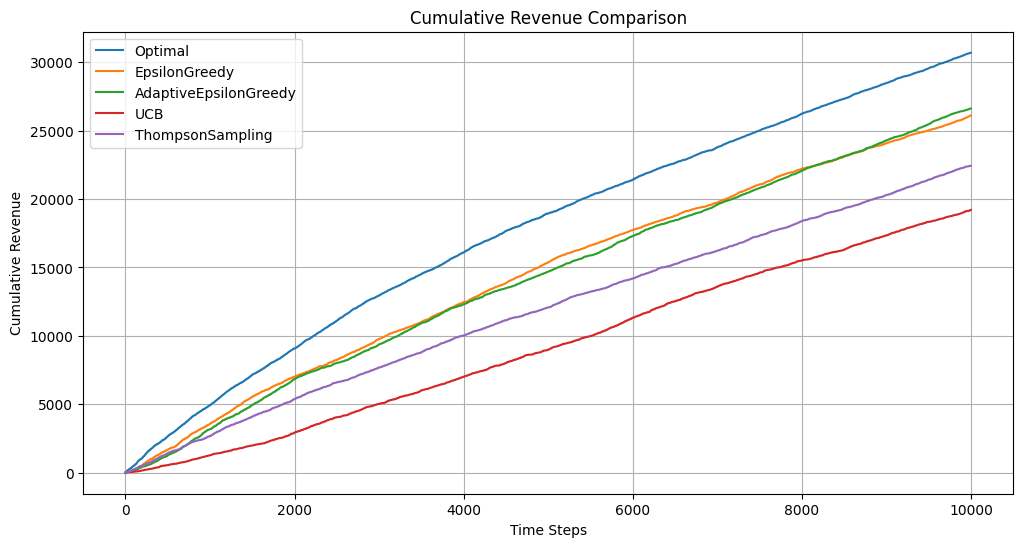

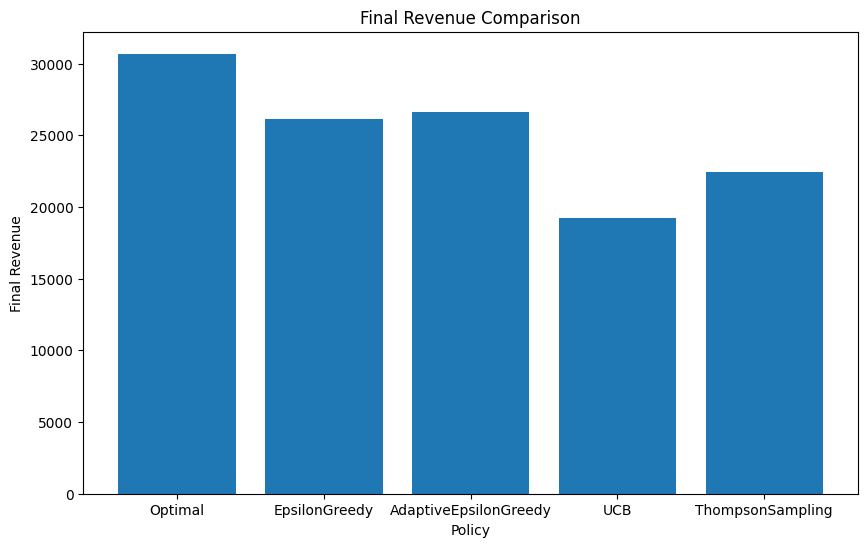

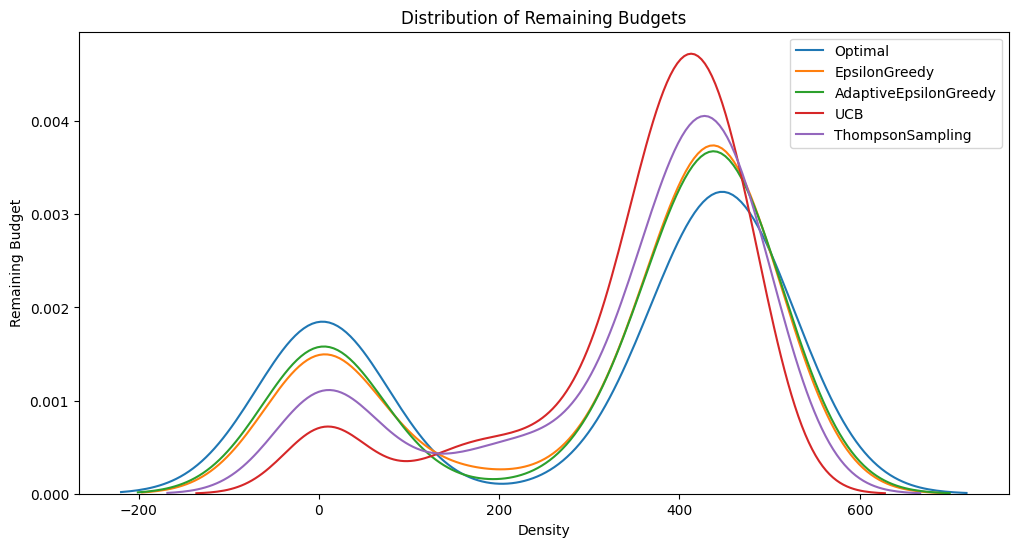

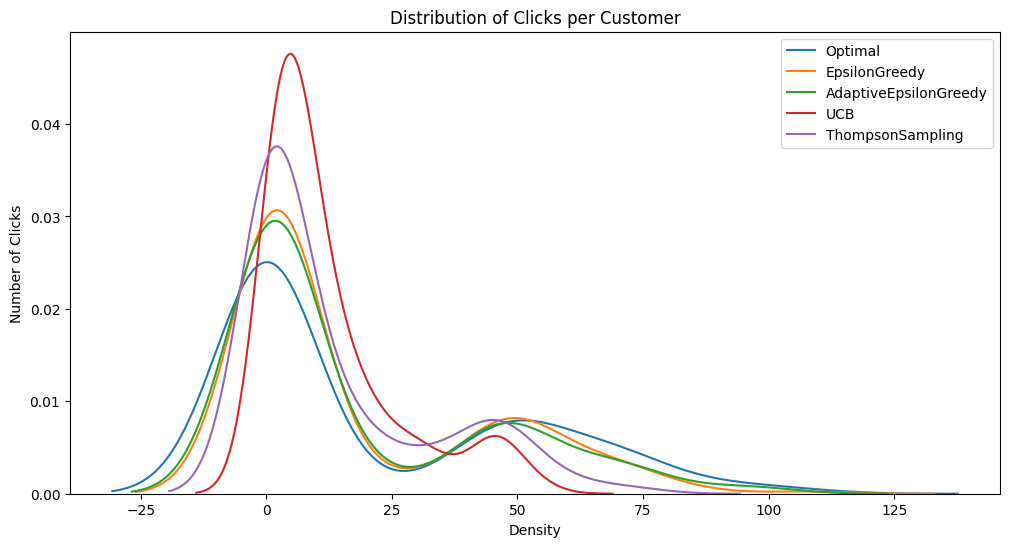

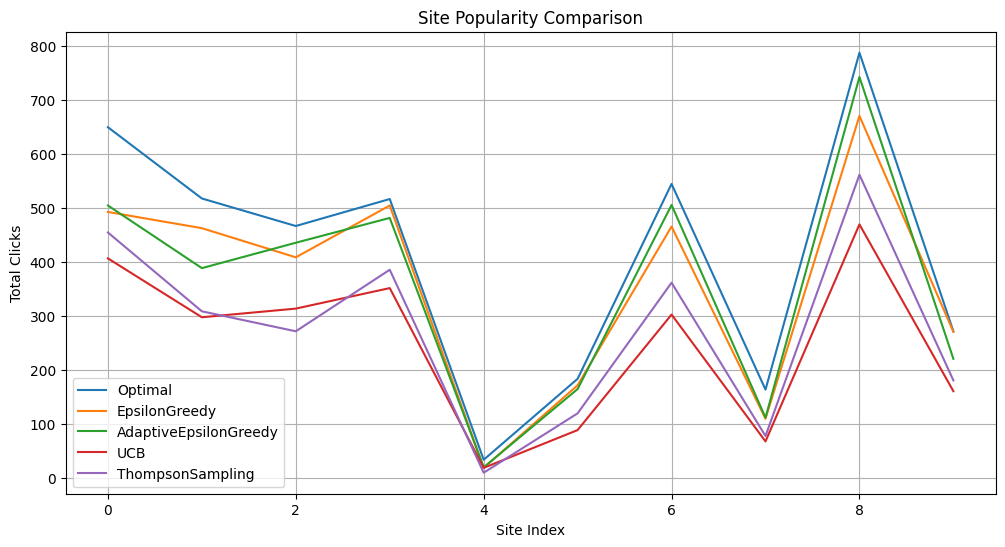


Results for Optimal:


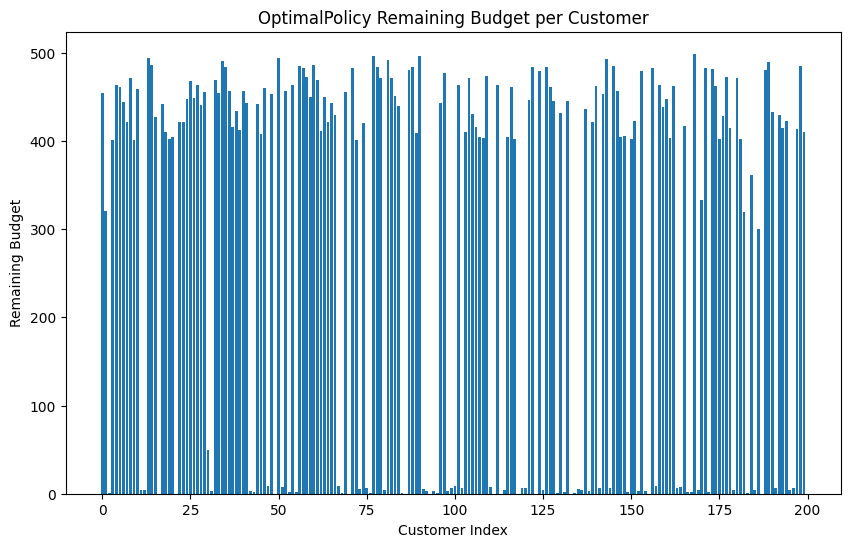

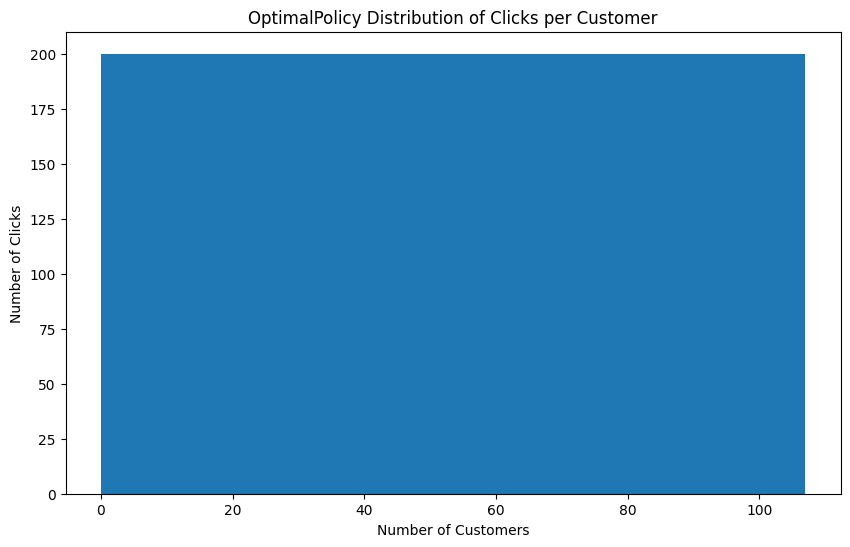


Results for EpsilonGreedy:


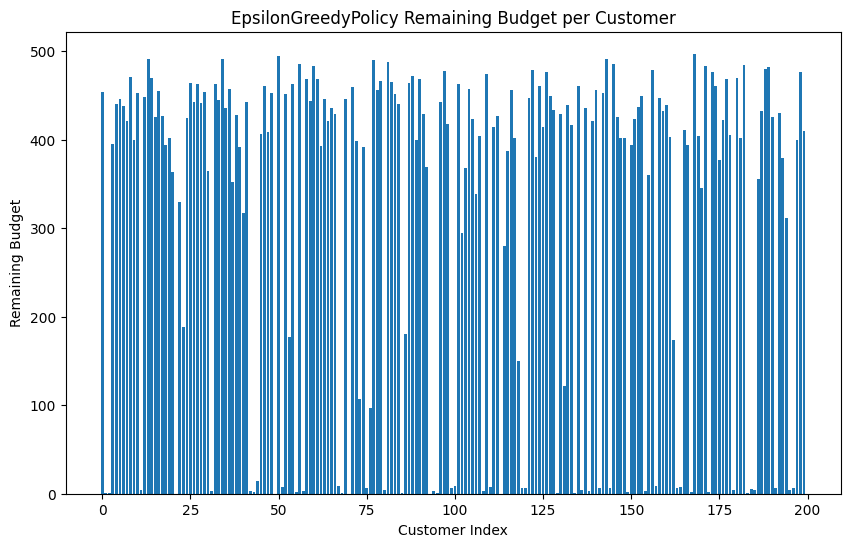

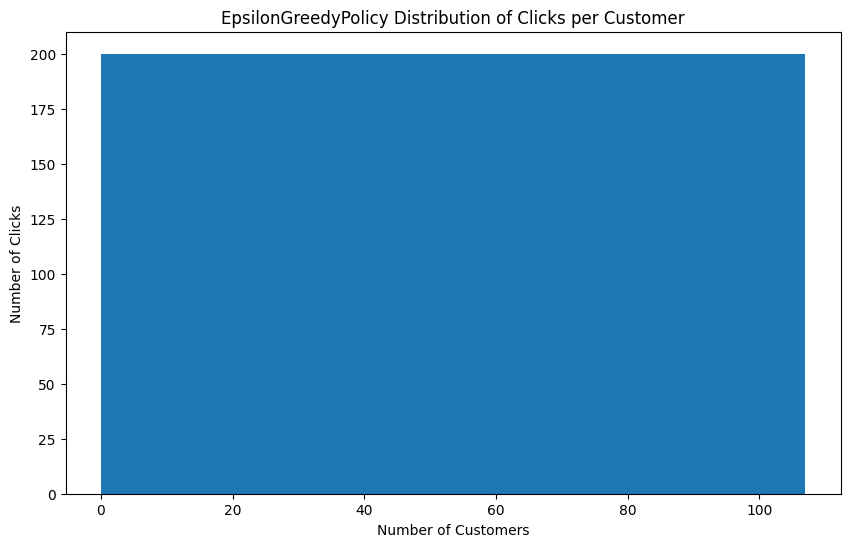


Results for AdaptiveEpsilonGreedy:


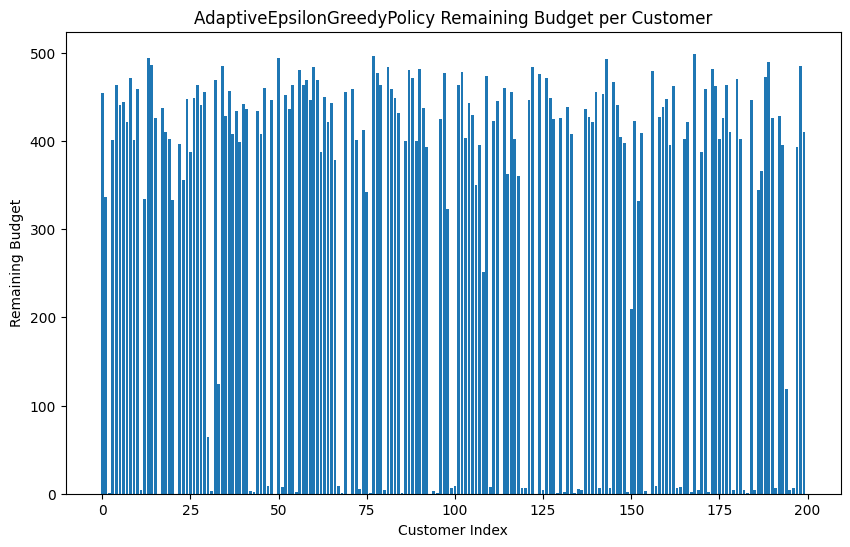

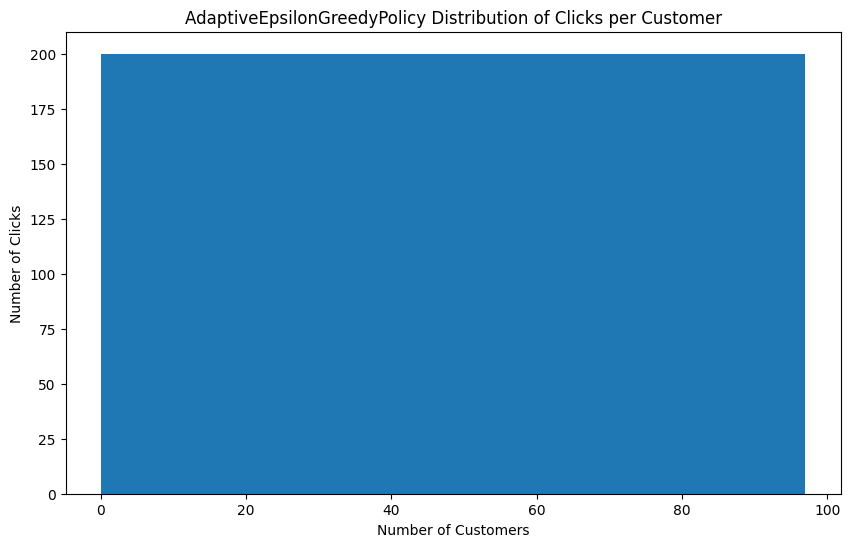


Results for UCB:


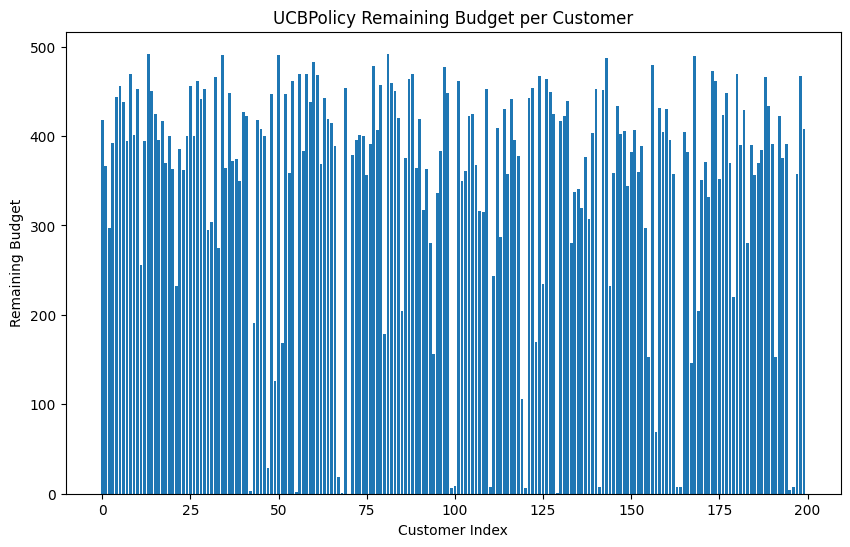

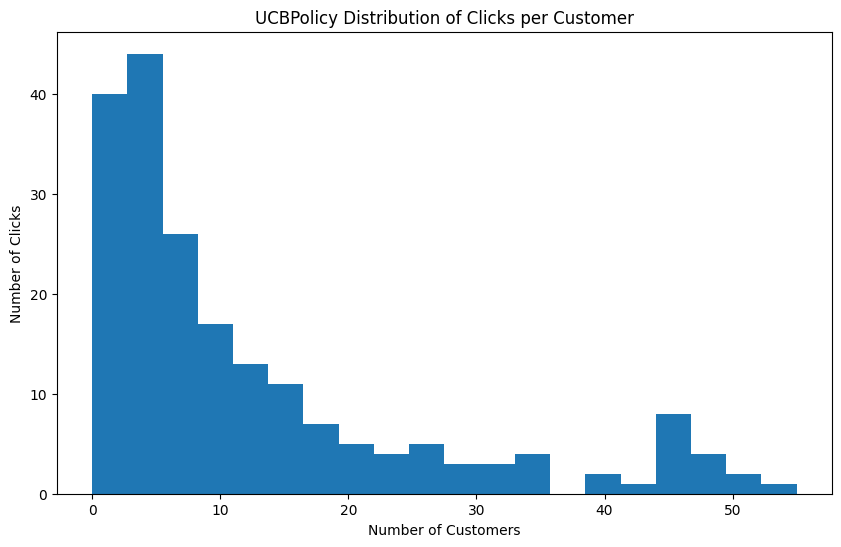


Results for ThompsonSampling:


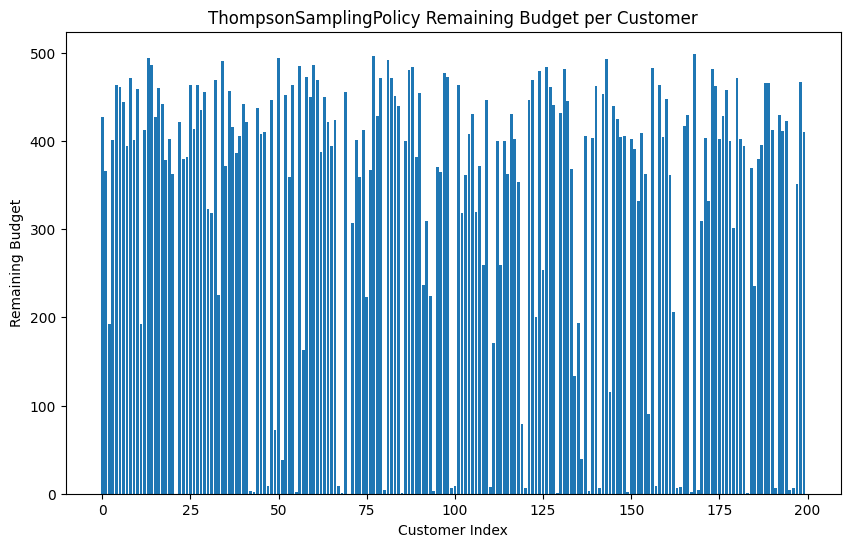

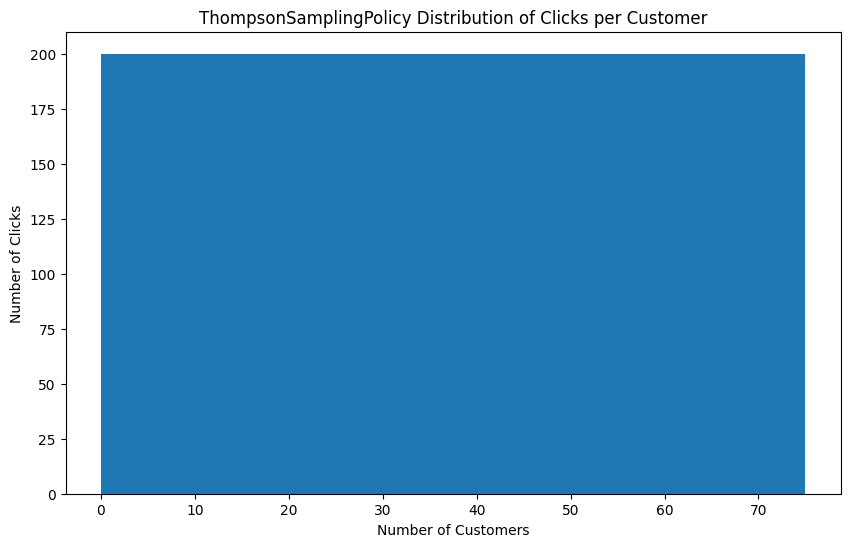


Running experiment with k=200, l=2, d=10


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


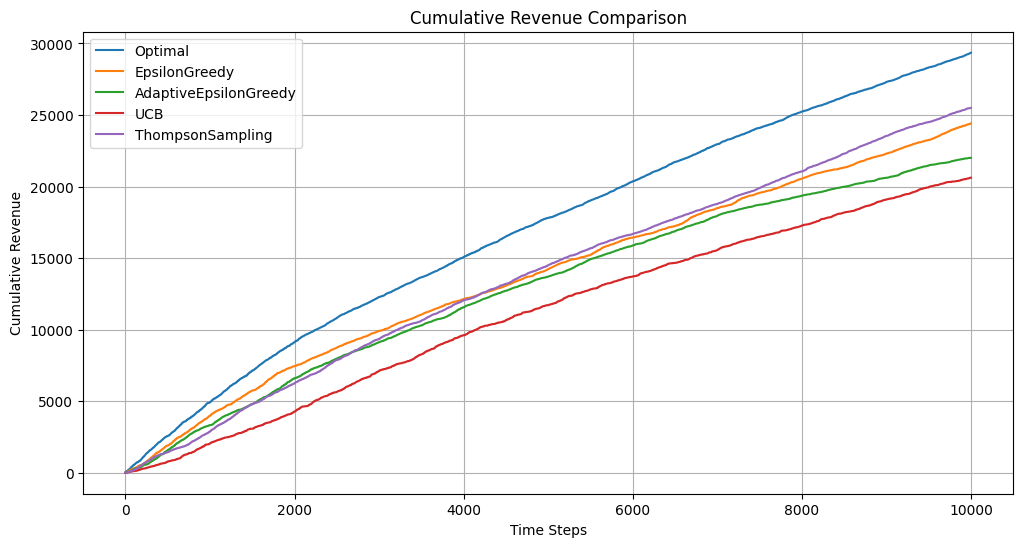

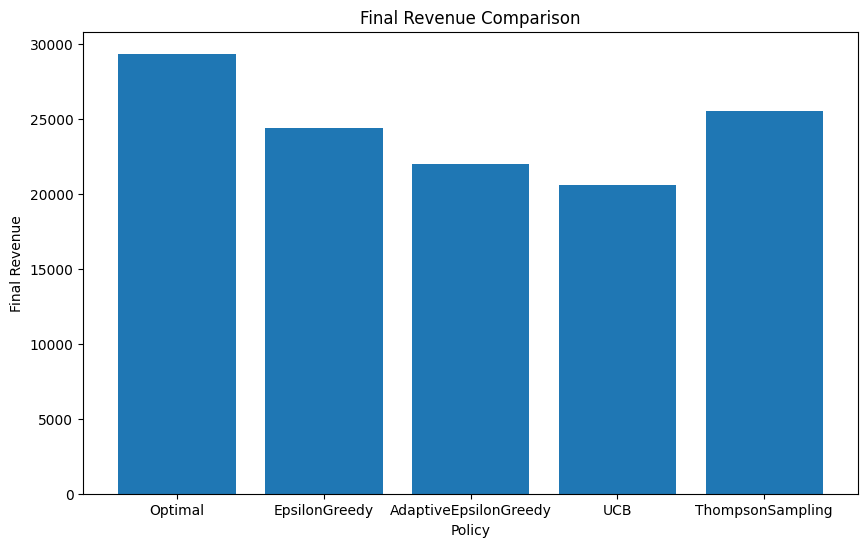

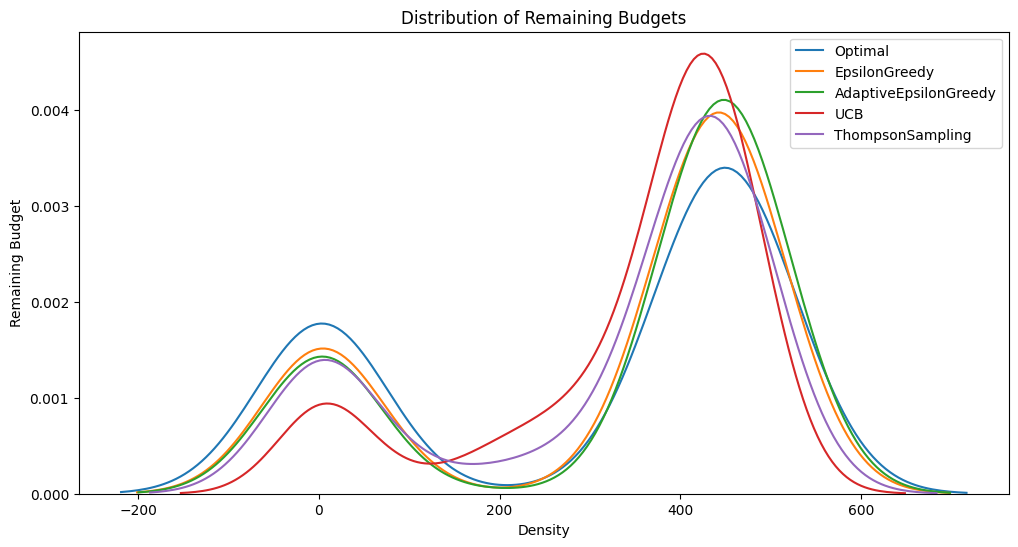

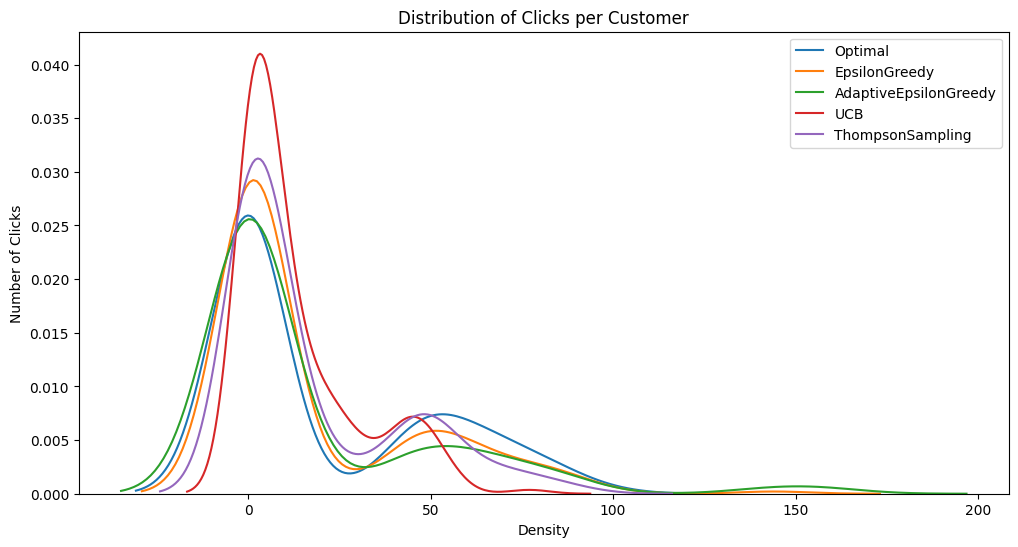

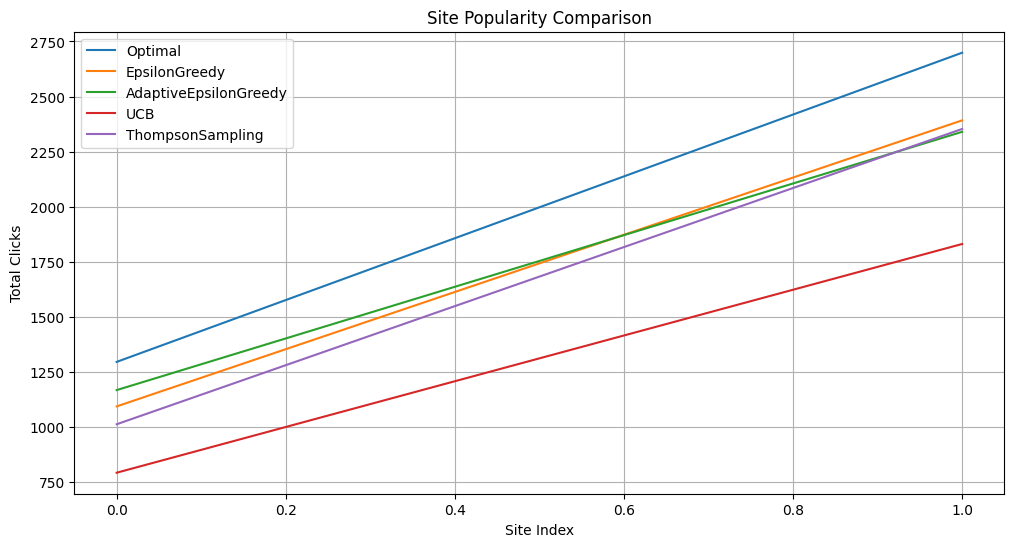


Results for Optimal:


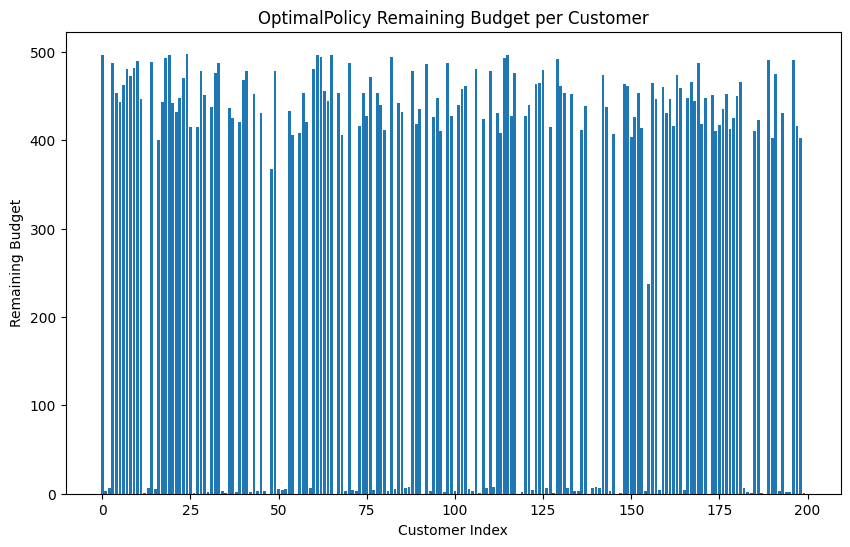

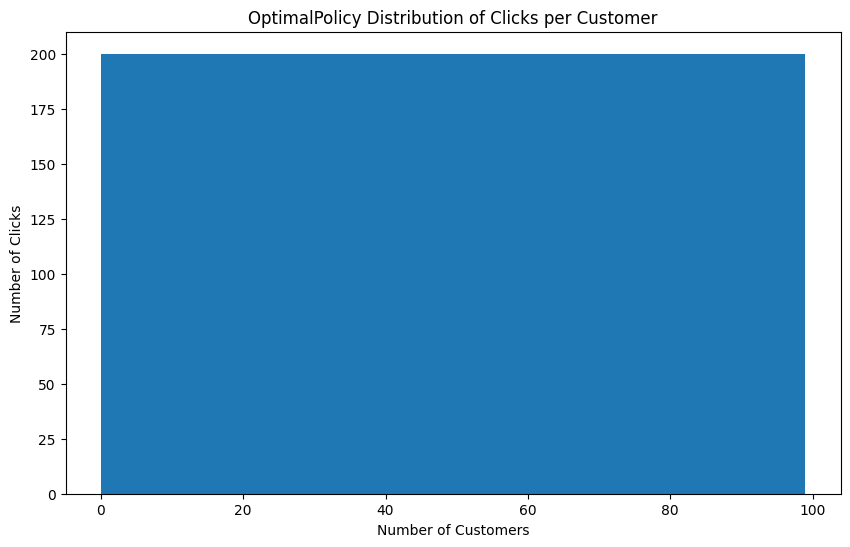


Results for EpsilonGreedy:


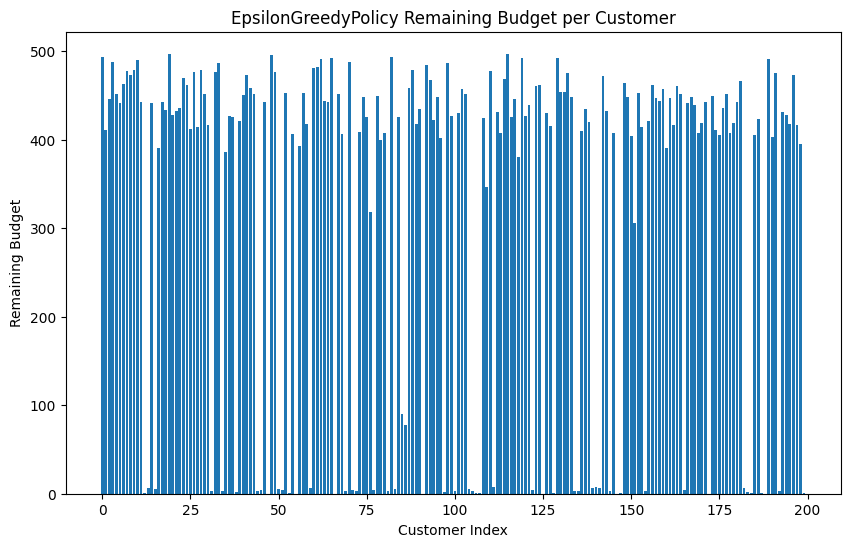

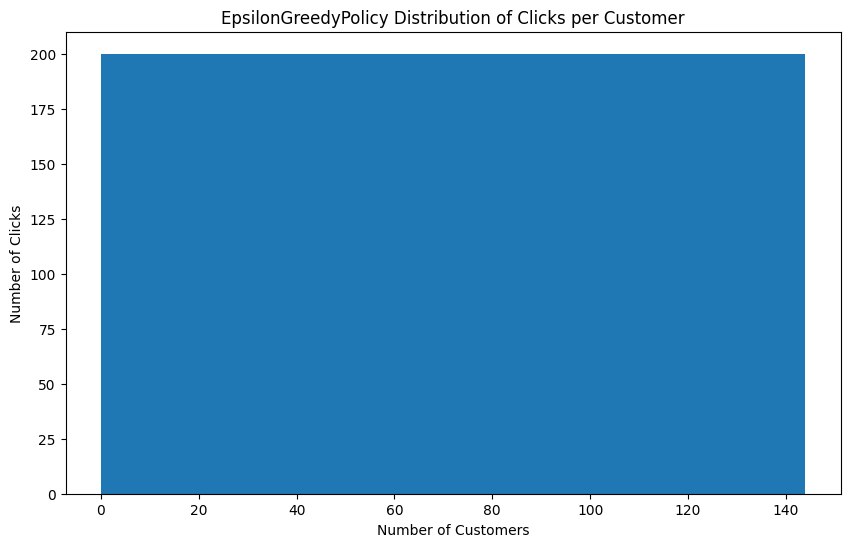


Results for AdaptiveEpsilonGreedy:


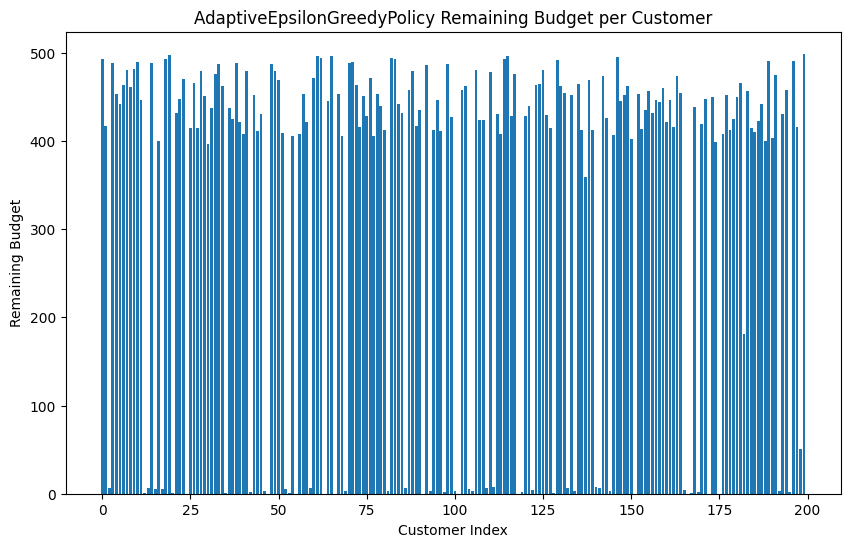

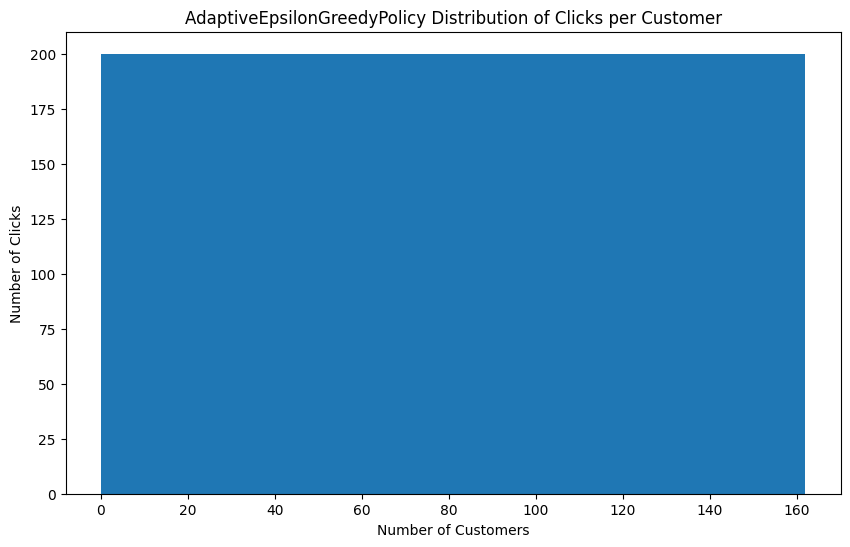


Results for UCB:


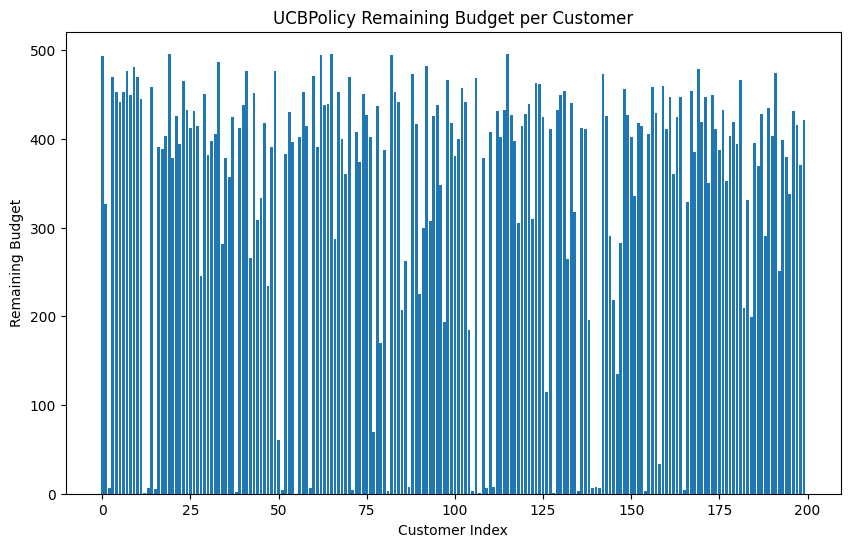

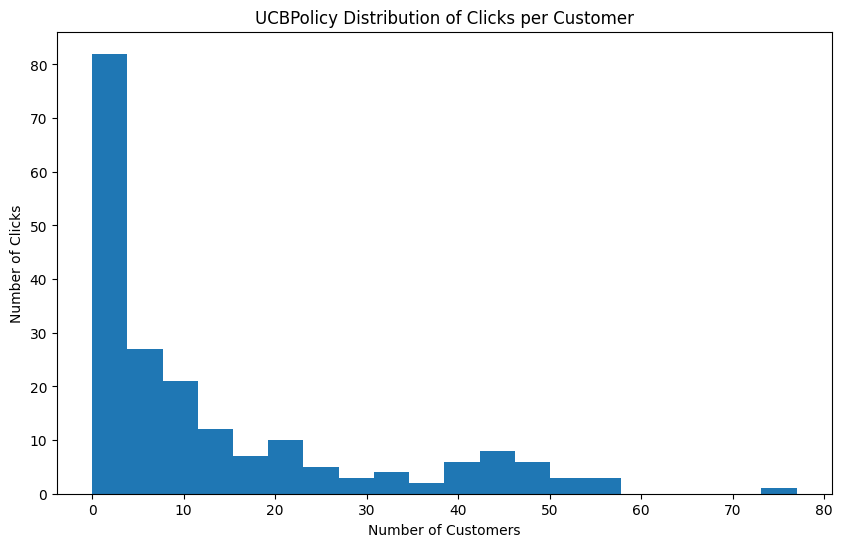


Results for ThompsonSampling:


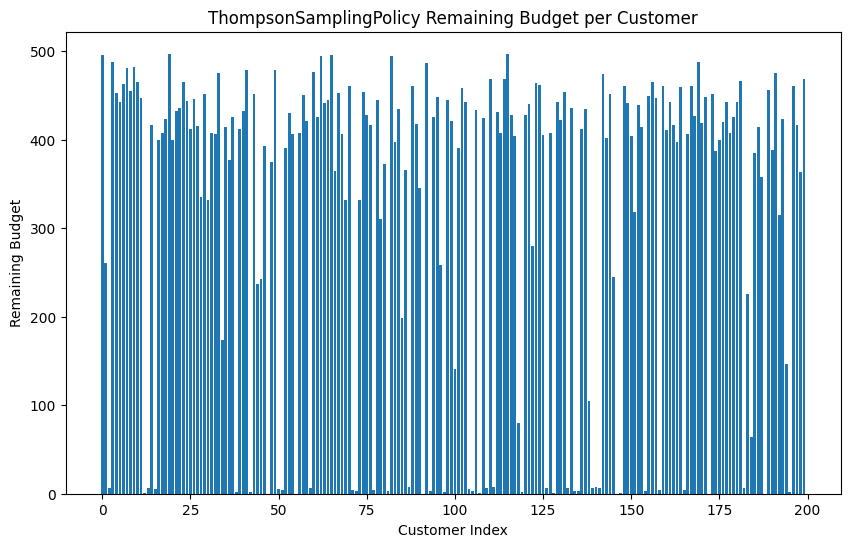

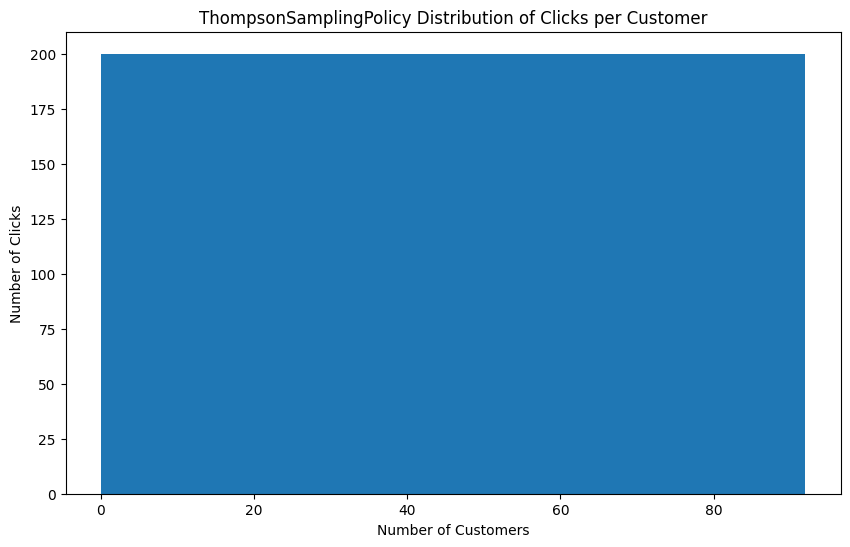


Running experiment with k=200, l=10, d=10


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


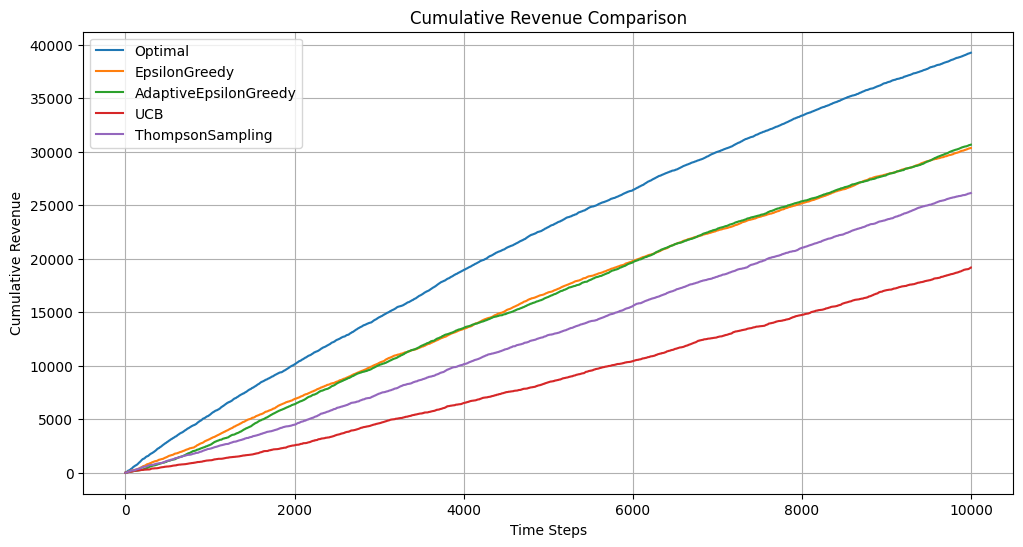

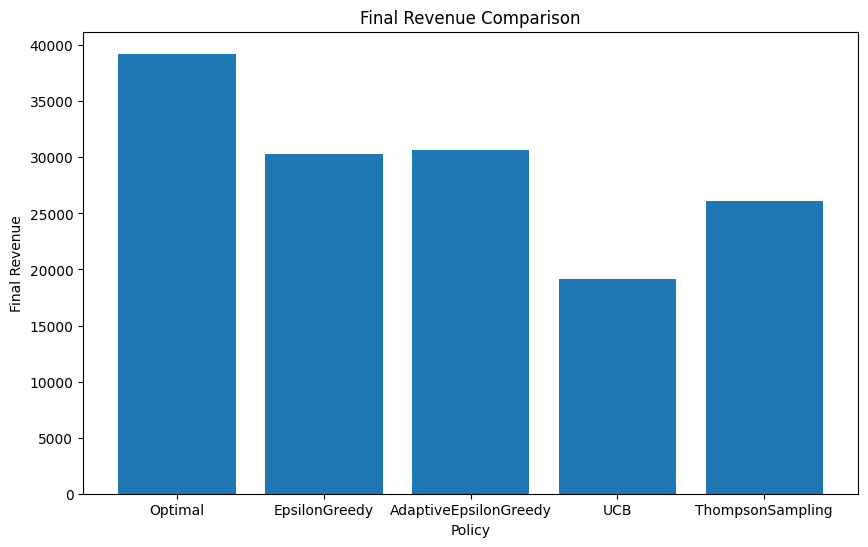

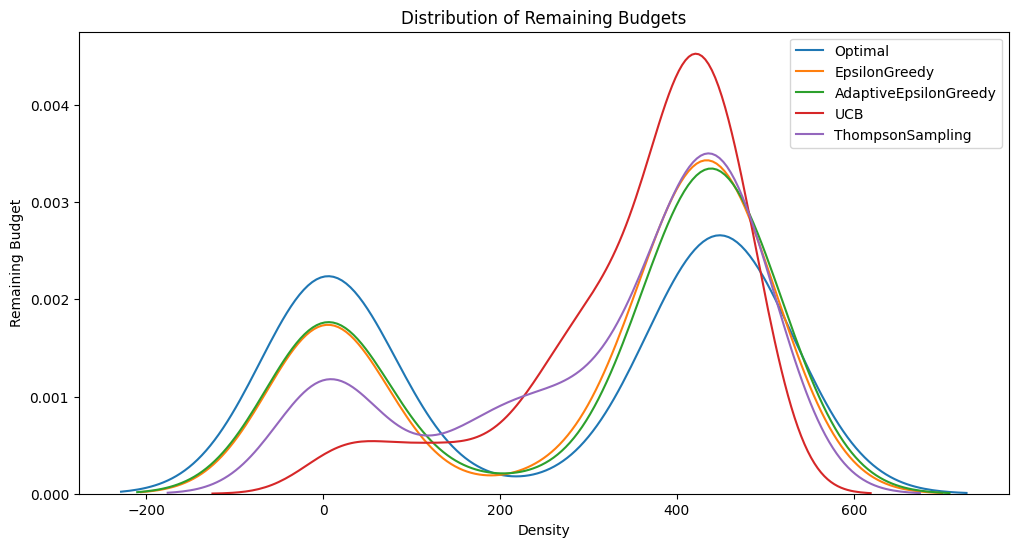

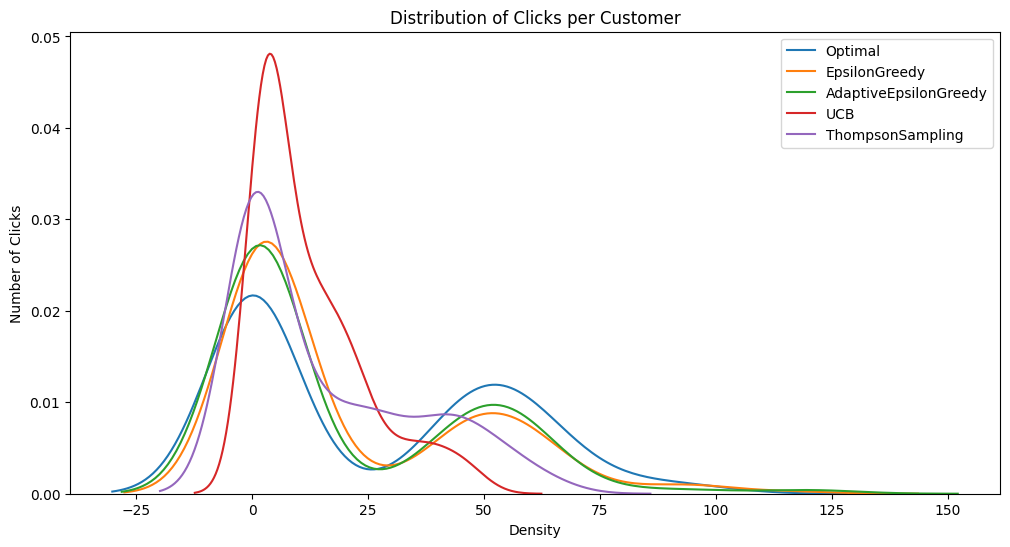

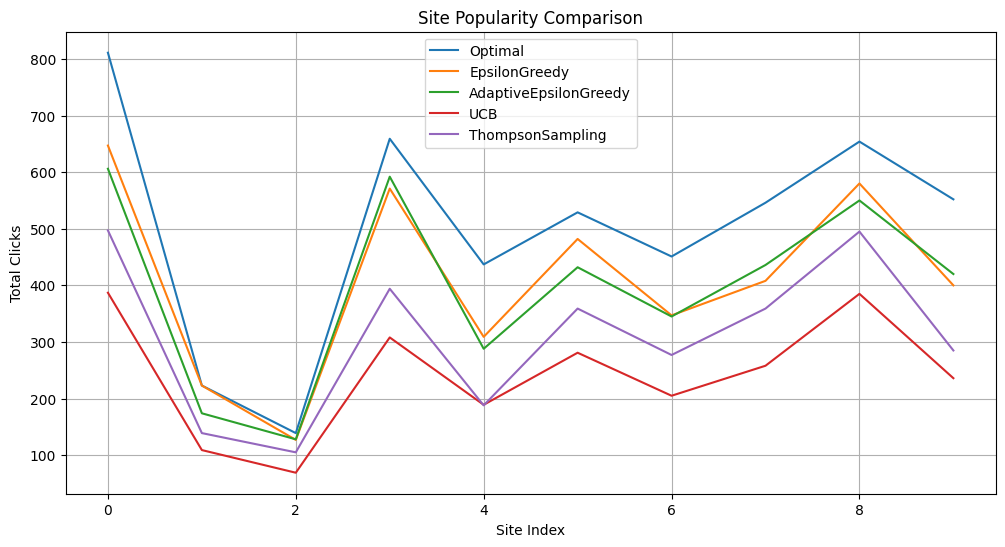


Results for Optimal:


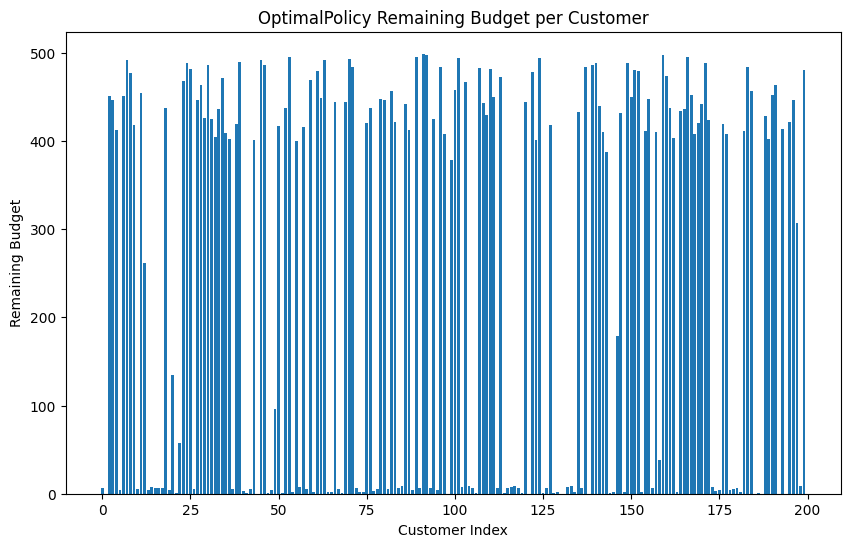

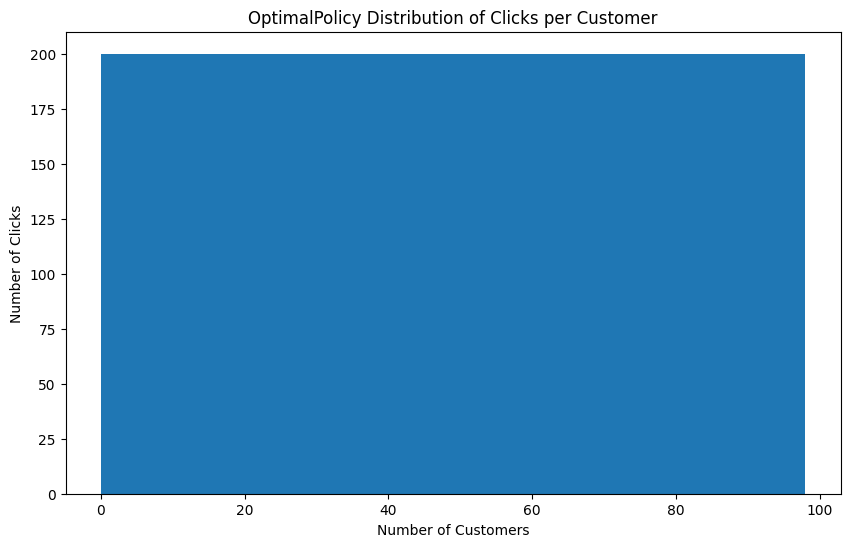


Results for EpsilonGreedy:


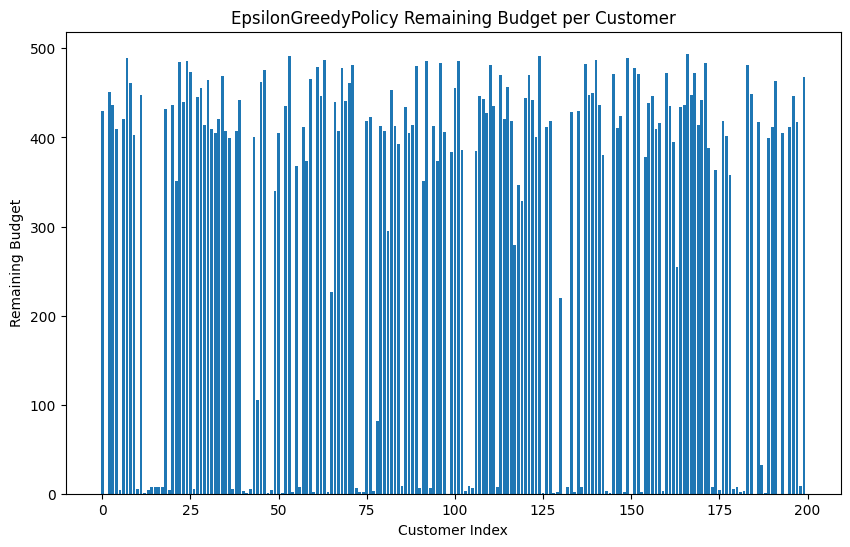

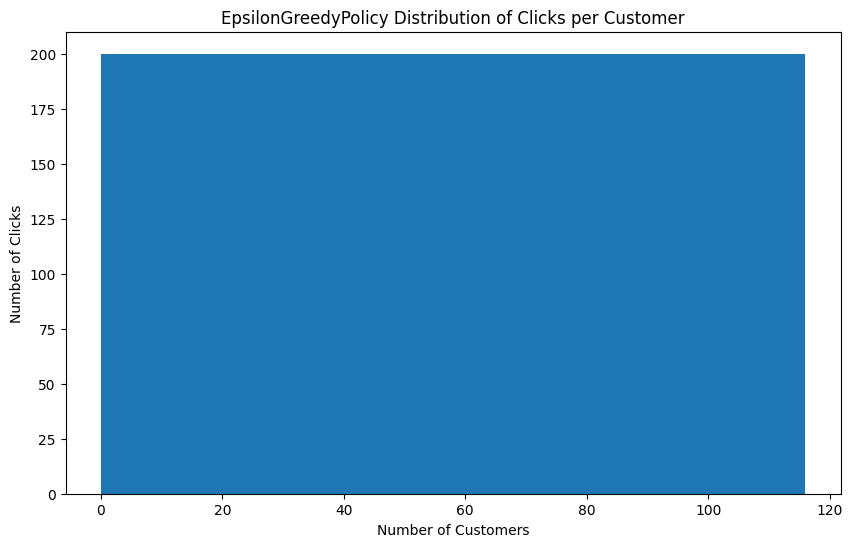


Results for AdaptiveEpsilonGreedy:


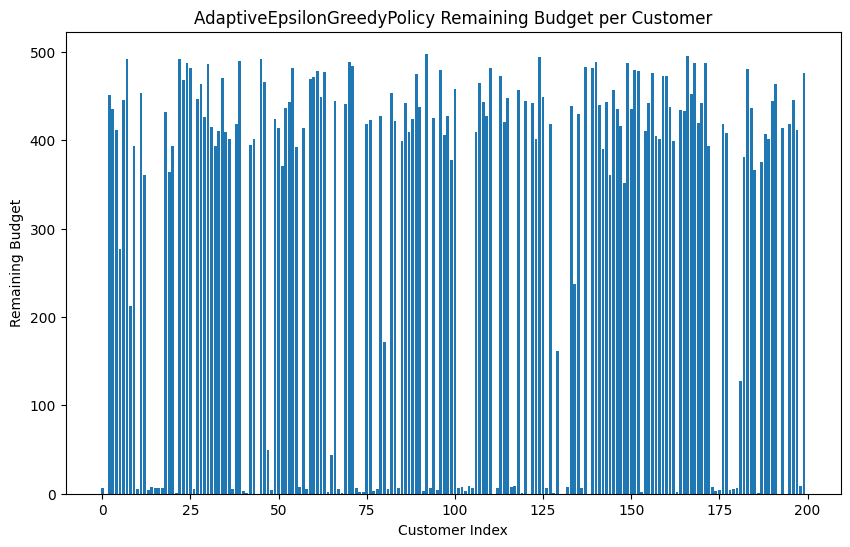

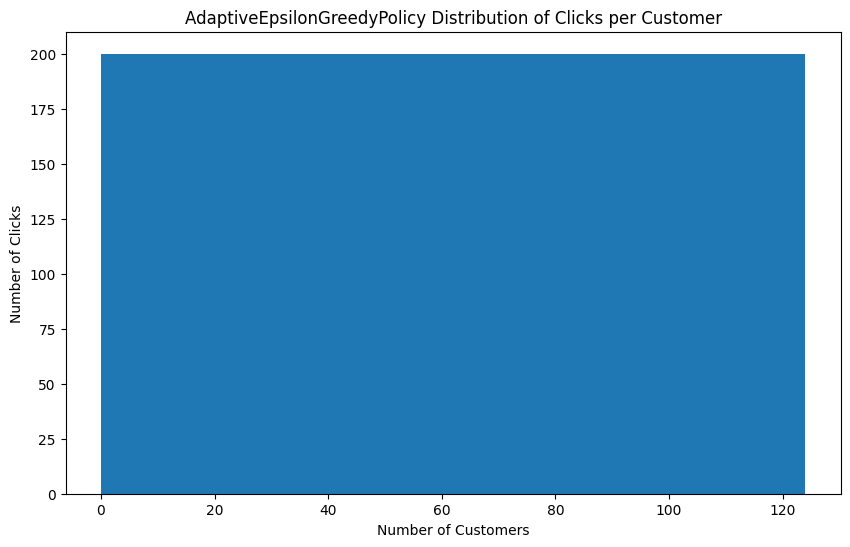


Results for UCB:


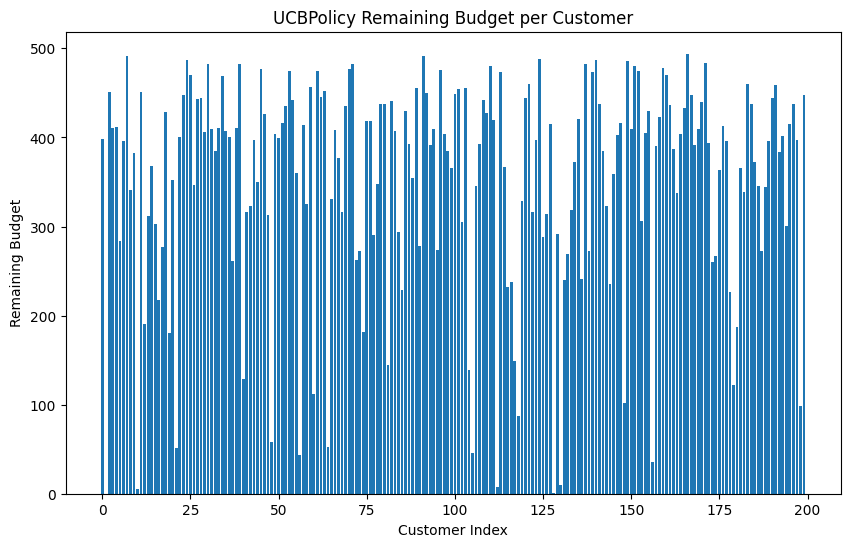

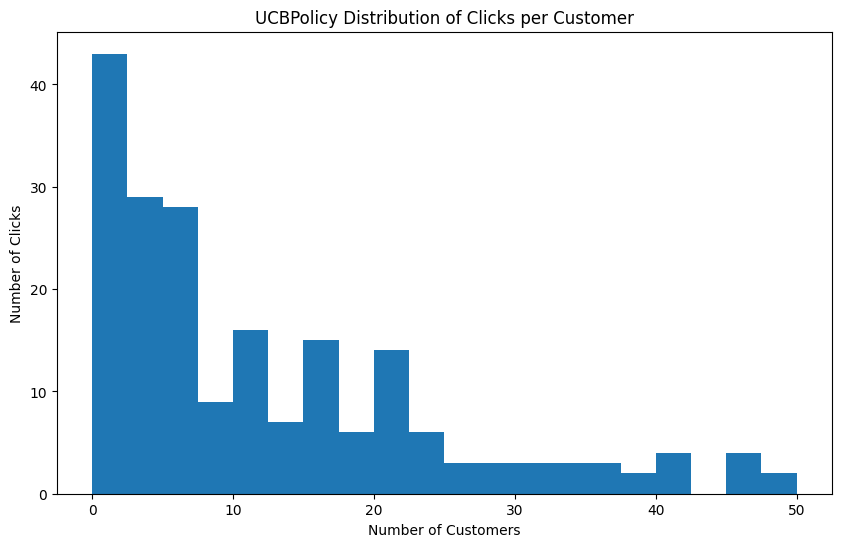


Results for ThompsonSampling:


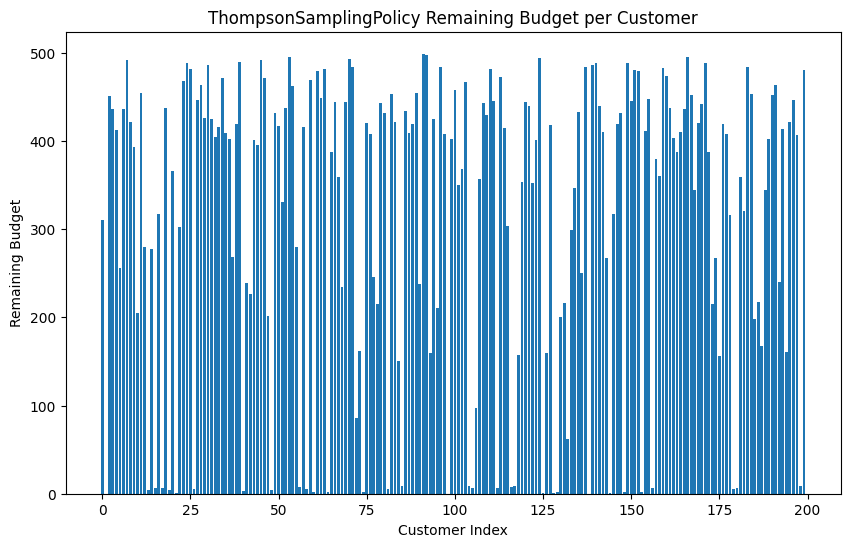

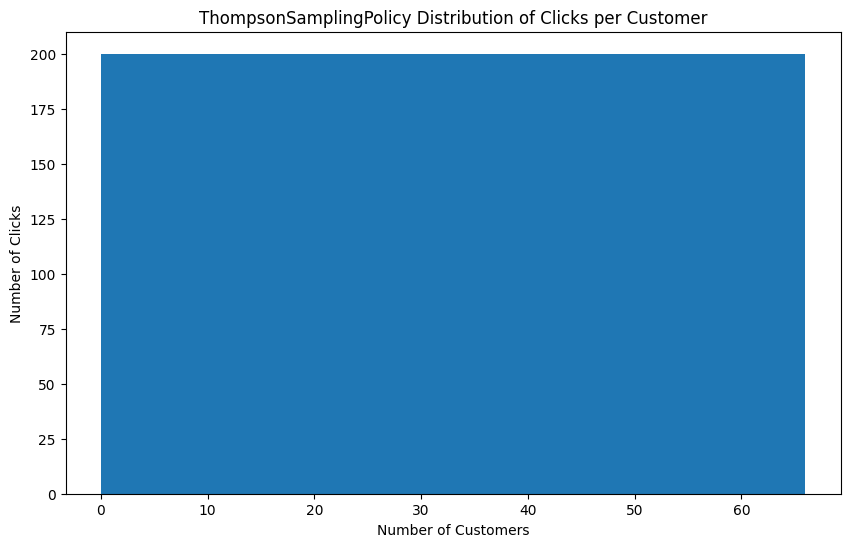


Running experiment with k=200, l=20, d=10


<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-16-dc23f1d6808d>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays


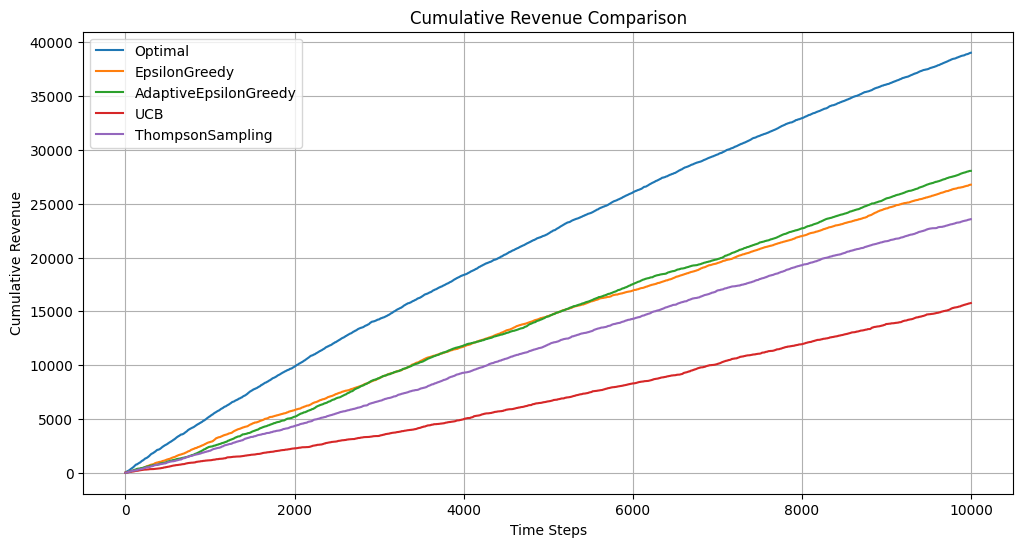

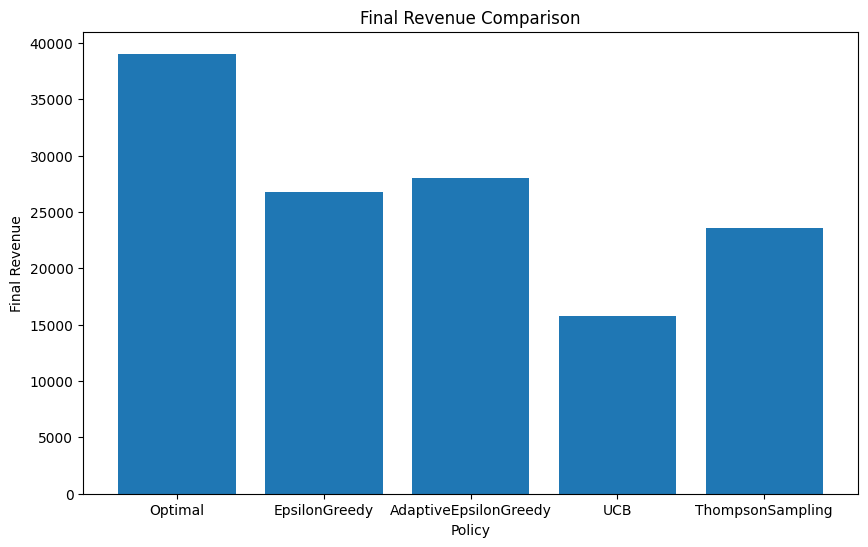

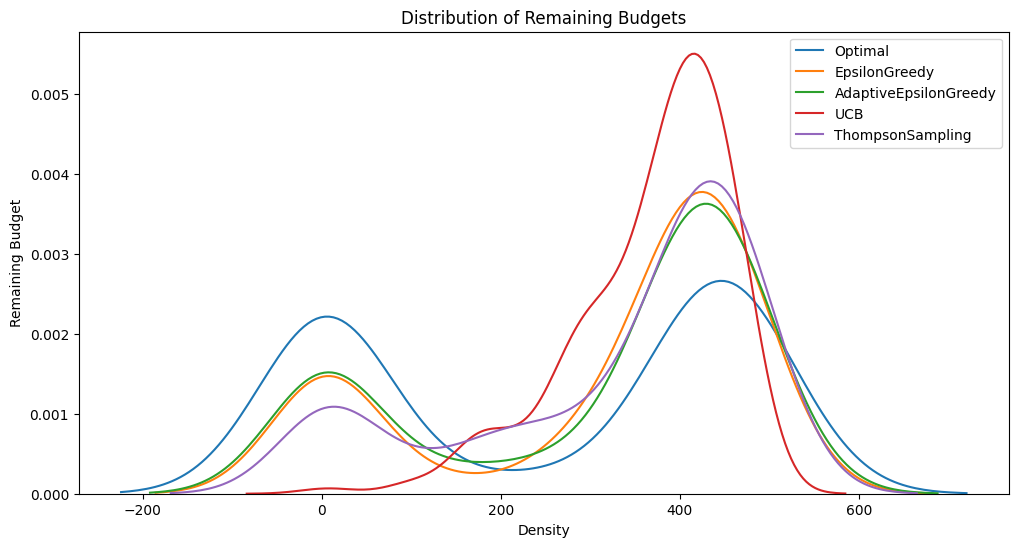

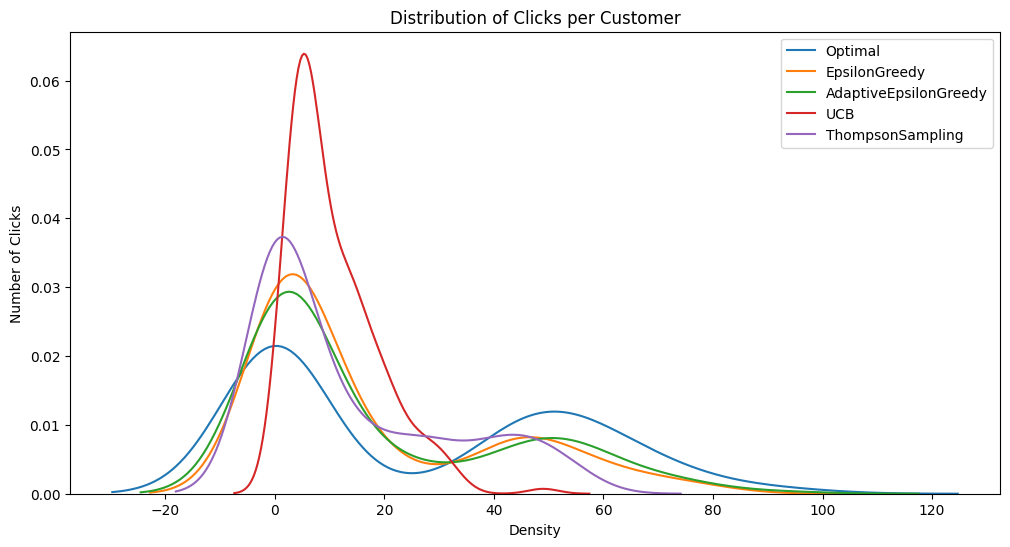

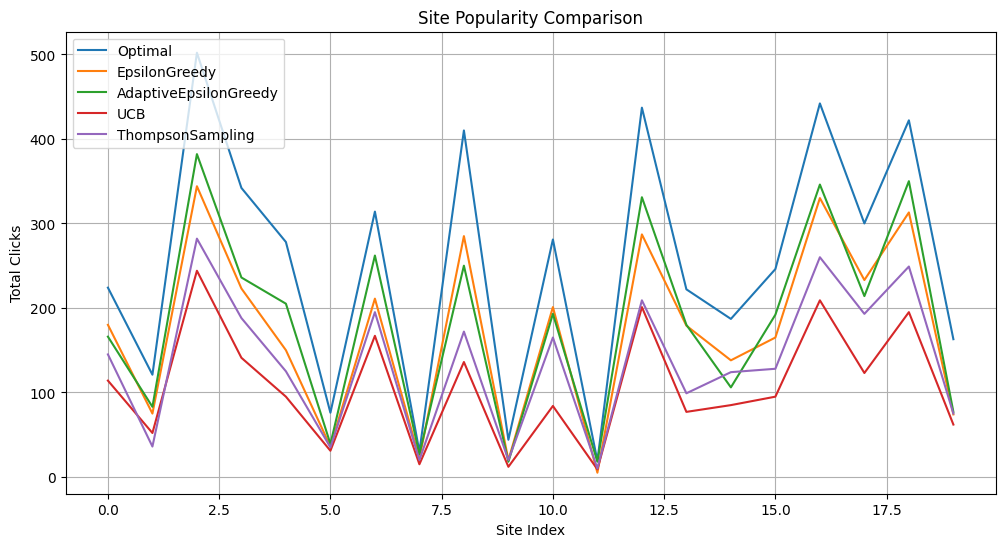


Results for Optimal:


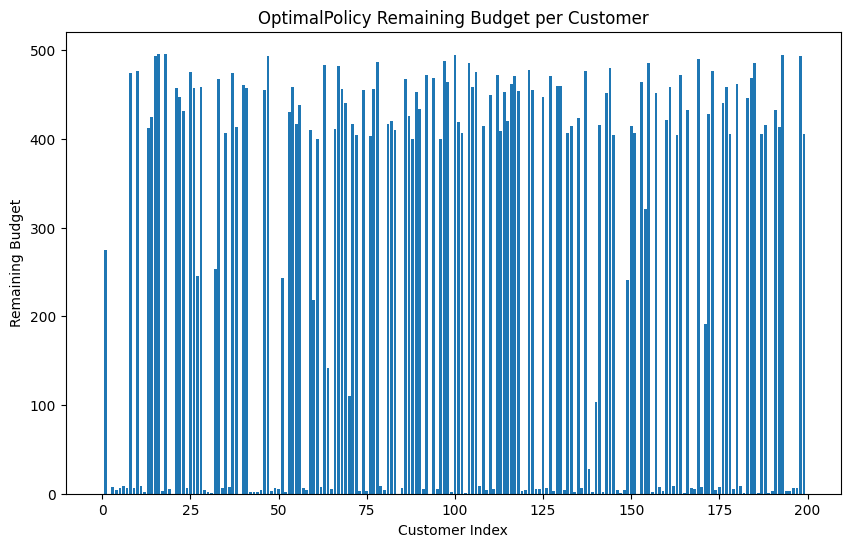

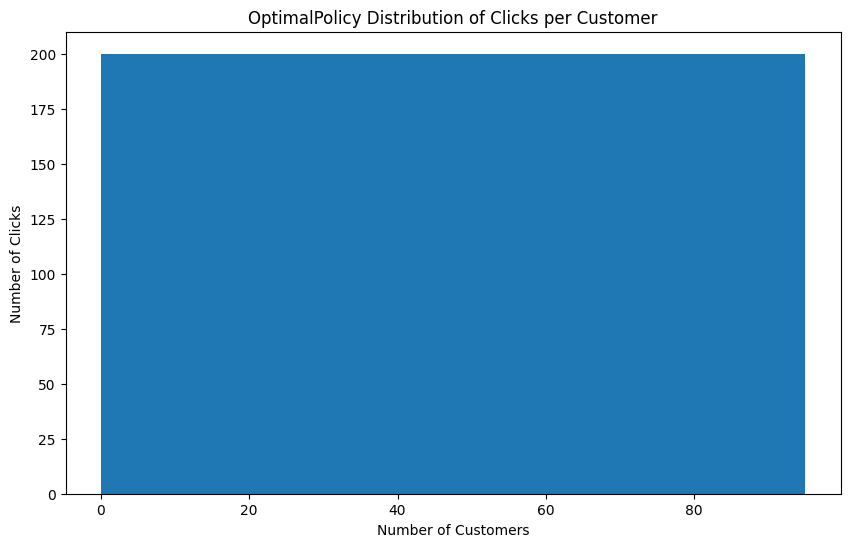


Results for EpsilonGreedy:


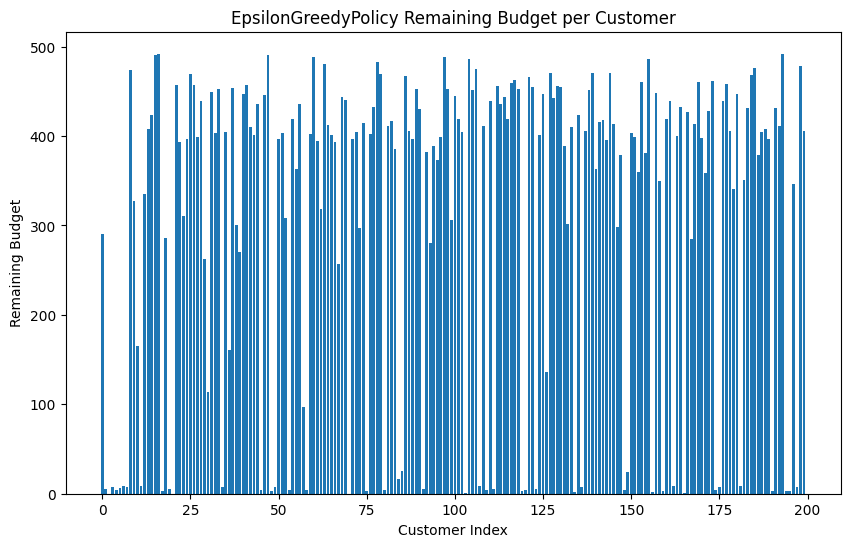

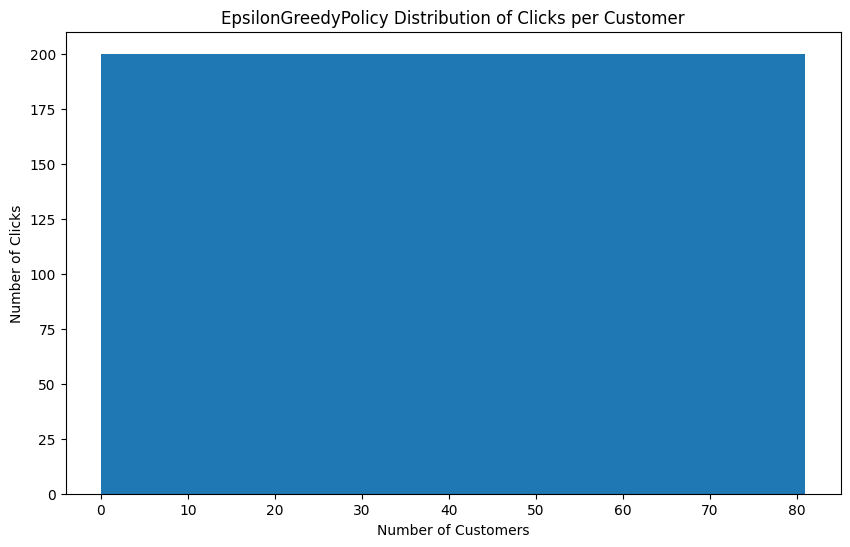


Results for AdaptiveEpsilonGreedy:


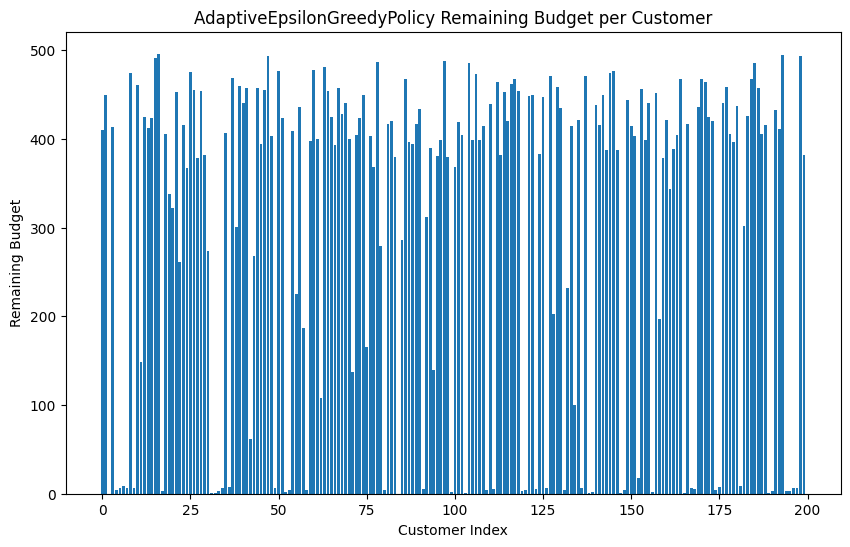

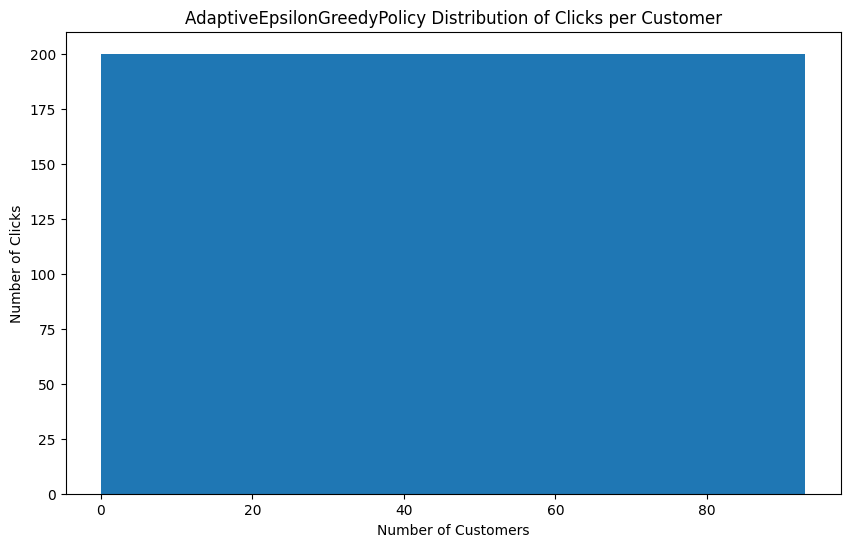


Results for UCB:


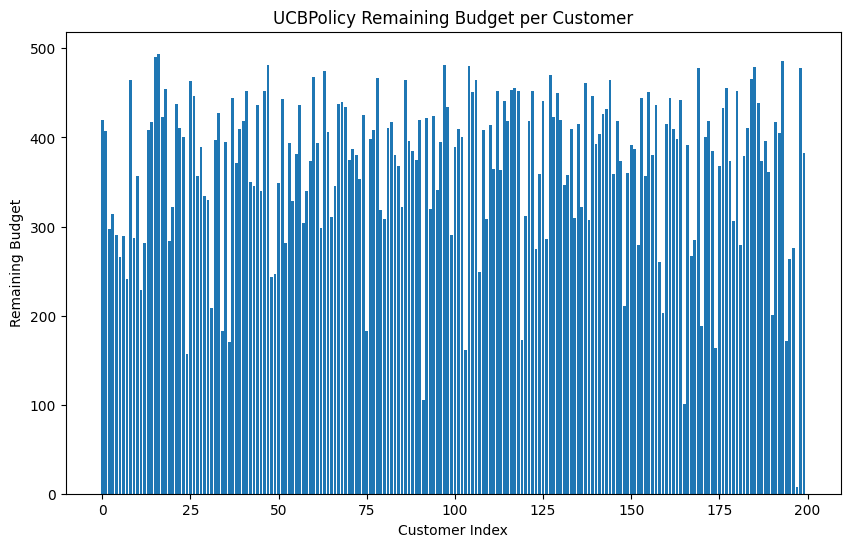

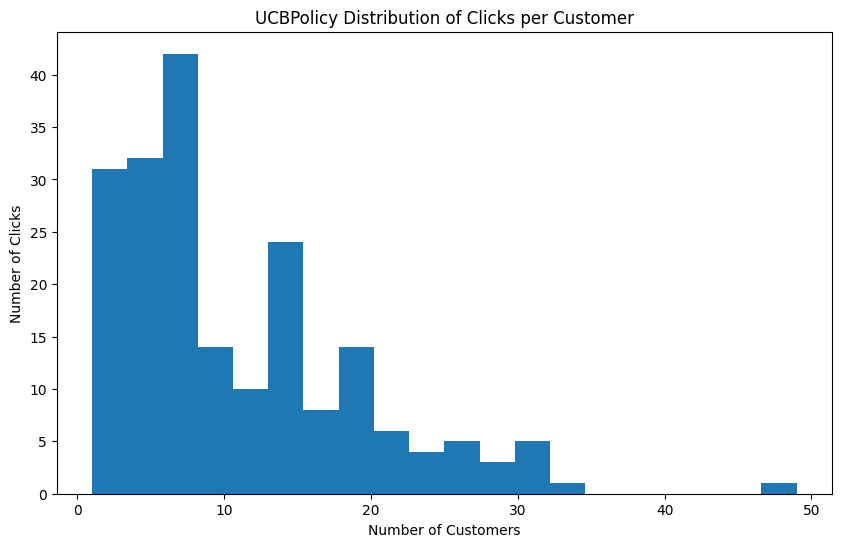


Results for ThompsonSampling:


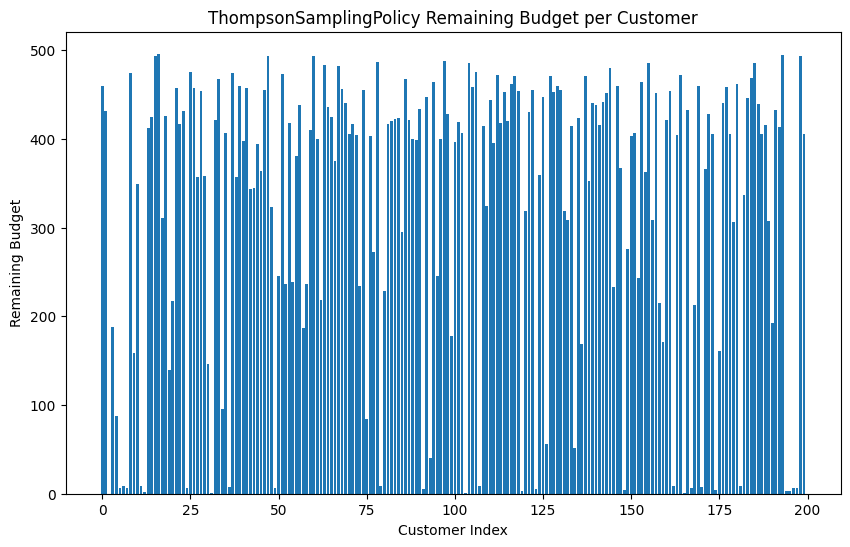

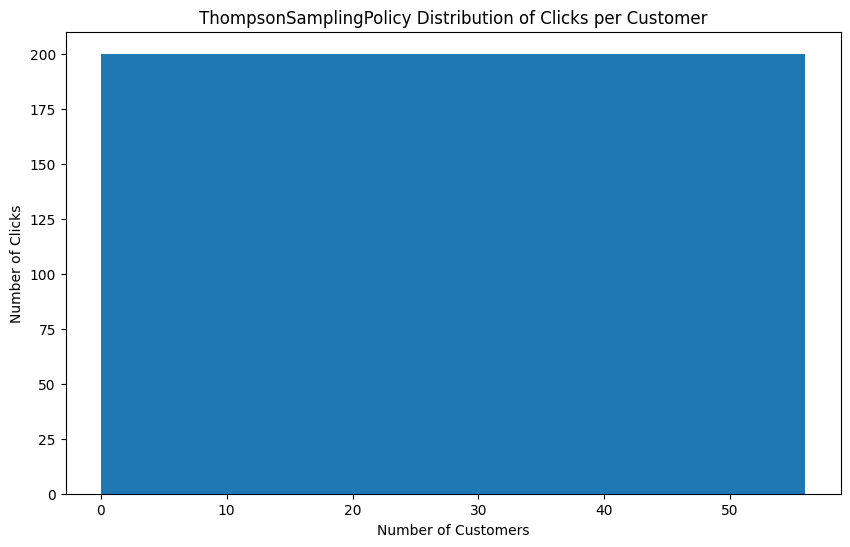

In [ ]:
class ModelRunner:
    def __init__(self, init_data, policies):
        self.init_data = init_data
        self.policies = policies
        self.results = {}

    def run_all_policies(self):
        for name, PolicyClass in self.policies.items():
            policy = PolicyClass(self.init_data)
            policy.run_simulation()
            self.results[name] = policy

    def draw_cumulative_revenue(self):
        plt.figure(figsize=(12, 6))
        for name, policy in self.results.items():
            plt.plot(policy.cumulative_revenue, label=name)
        plt.title("Cumulative Revenue Comparison")
        plt.xlabel("Time Steps")
        plt.ylabel("Cumulative Revenue")
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_final_revenue_comparison(self):
        final_revenues = {name: policy.current_cumulative_revenue for name, policy in self.results.items()}
        plt.figure(figsize=(10, 6))
        plt.bar(final_revenues.keys(), final_revenues.values())
        plt.title("Final Revenue Comparison")
        plt.xlabel("Policy")
        plt.ylabel("Final Revenue")
        plt.show()

    def draw_remaining_budgets_comparison(self):
        plt.figure(figsize=(12, 6))
        for name, policy in self.results.items():
            sns.kdeplot(policy.customer_budgets, label=name)
        plt.title("Distribution of Remaining Budgets")
        plt.ylabel("Remaining Budget")
        plt.xlabel("Density")
        plt.legend()
        plt.show()

    def draw_click_distributions_comparison(self):
        plt.figure(figsize=(12, 6))
        for name, policy in self.results.items():
            total_clicks = policy.customer_clicks.sum(axis=1)
            sns.kdeplot(total_clicks, label=name)
        plt.title("Distribution of Clicks per Customer")
        plt.ylabel("Number of Clicks")
        plt.xlabel("Density")
        plt.legend()
        plt.show()

    def draw_site_popularity(self):
        plt.figure(figsize=(12, 6))
        for name, policy in self.results.items():
            site_clicks = policy.customer_clicks.sum(axis=0)
            plt.plot(range(policy.l), site_clicks, label=name)
        plt.title("Site Popularity Comparison")
        plt.xlabel("Site Index")
        plt.ylabel("Total Clicks")
        plt.legend()
        plt.grid(True)
        plt.show()

    def run_and_visualize(self):
        self.run_all_policies()
        self.draw_cumulative_revenue()
        self.draw_final_revenue_comparison()
        self.draw_remaining_budgets_comparison()
        self.draw_click_distributions_comparison()
        self.draw_site_popularity()

        for name, policy in self.results.items():
            print(f"\nResults for {name}:")
            policy.draw_remaining_budget()
            policy.draw_click_distribution()

def run_experiment(k, l, d, num_events=10000):
    init_data = Init(l=l, k=k, d=d, num_events=num_events)

    policies = {
        'Optimal': OptimalPolicy,
        'EpsilonGreedy': EpsilonGreedyPolicy,
        'AdaptiveEpsilonGreedy': AdaptiveEpsilonGreedyPolicy,
        'UCB': UCBPolicy,
        'ThompsonSampling': ThompsonSamplingPolicy
    }

    runner = ModelRunner(init_data, policies)
    runner.run_and_visualize()

if __name__ == '__main__':
    configurations = [
        {'k': 200, 'l': 1, 'd': 1},
        {'k': 200, 'l': 2, 'd': 1},
        {'k': 200, 'l': 10, 'd': 1},
        {'k': 200, 'l': 1, 'd': 2},
        {'k': 200, 'l': 2, 'd': 2},
        {'k': 200, 'l': 10, 'd': 2},
        {'k': 200, 'l': 2, 'd': 10},
        {'k': 200, 'l': 10, 'd': 10},
        {'k': 200, 'l': 20, 'd': 10}
    ]

    for config in configurations:
        print(f"\nRunning experiment with k={config['k']}, l={config['l']}, d={config['d']}")
        run_experiment(**config)

Running experiments for k=200, l=1, d=1:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-29-a60b9ff77669>:22: RuntimeWarning: invalid value encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
<ipython-input-29-a60b9ff77669>:22: RuntimeWarning: divide by zero encountered in divide
  (self.confidence_level * np.log(t + 1)) / total_displays
Running experiments for k=200, l=1, d=1: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


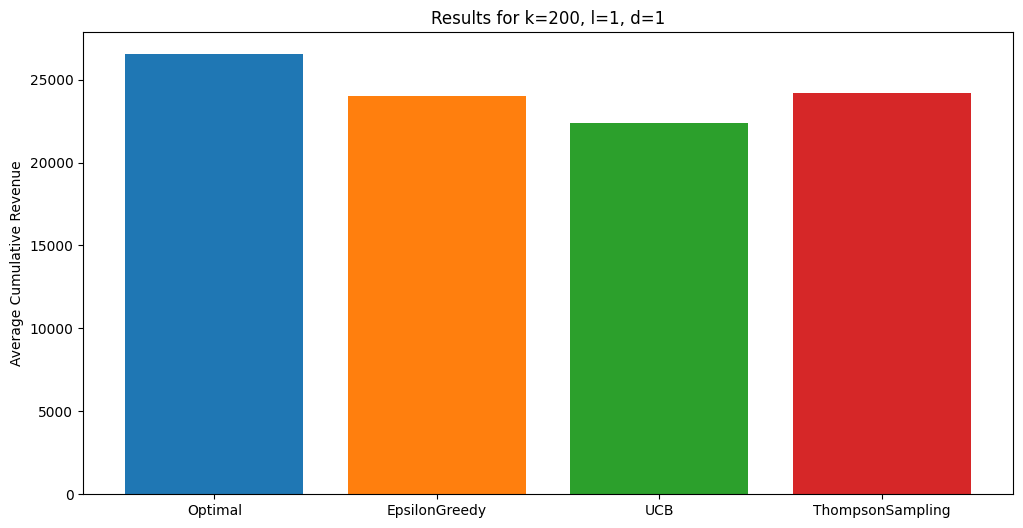

Running experiments for k=200, l=2, d=1: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


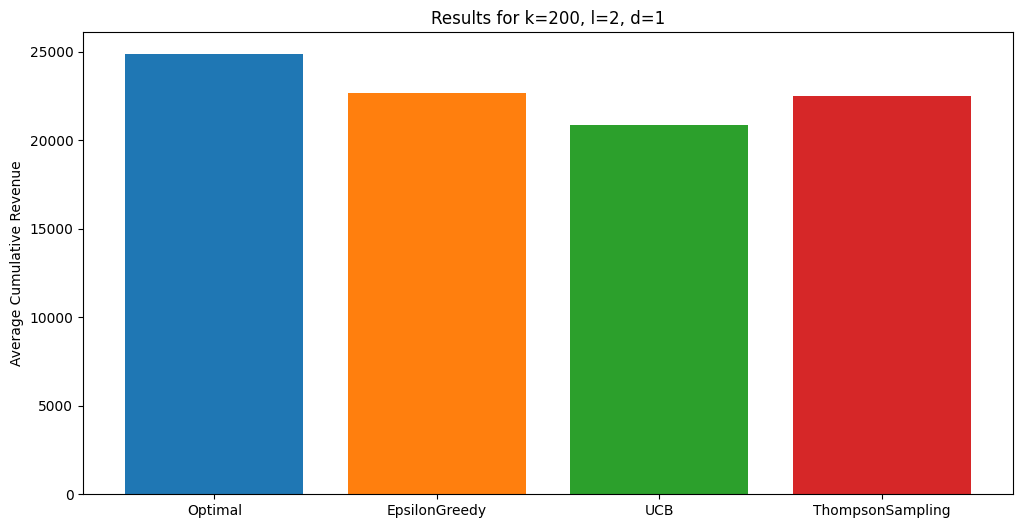

Running experiments for k=200, l=10, d=1: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


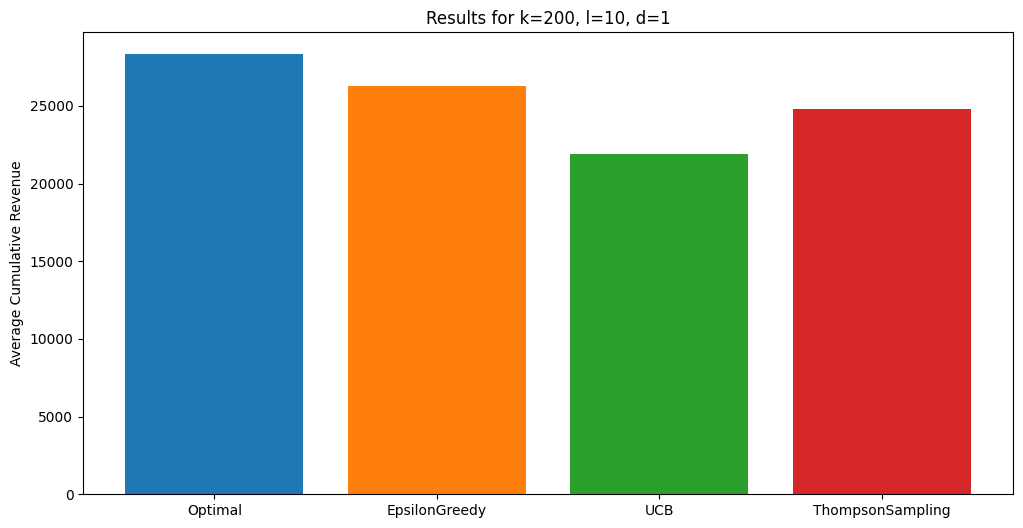

Running experiments for k=200, l=1, d=2: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


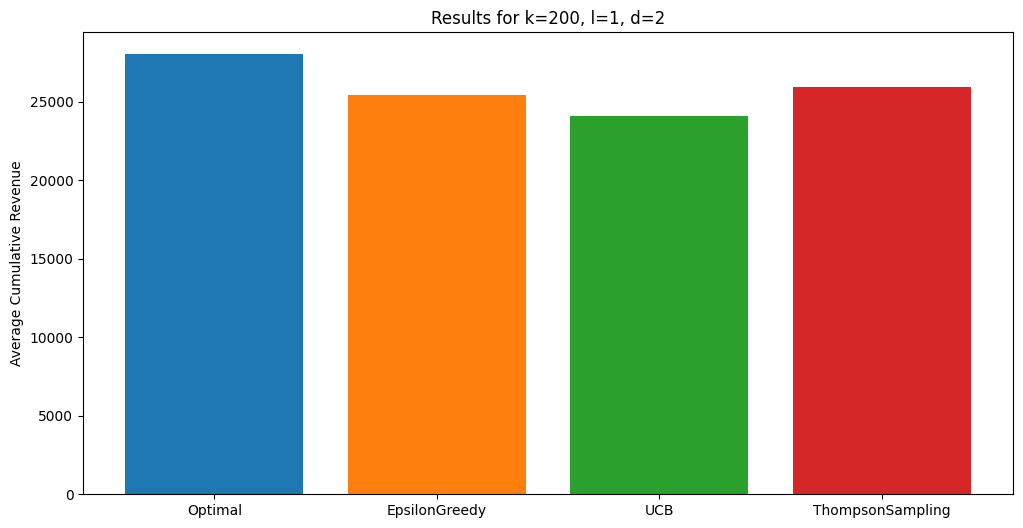

Running experiments for k=200, l=2, d=2: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


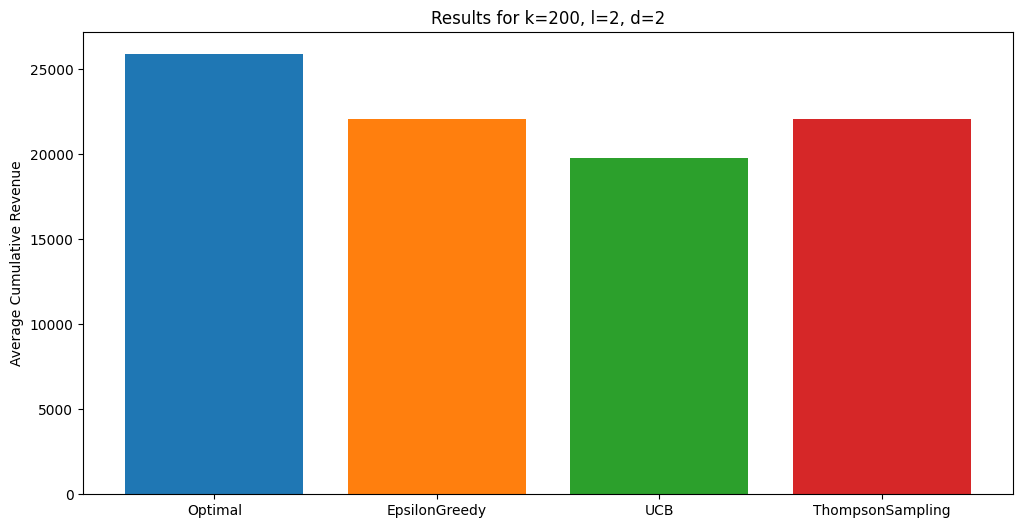

Running experiments for k=200, l=10, d=2: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


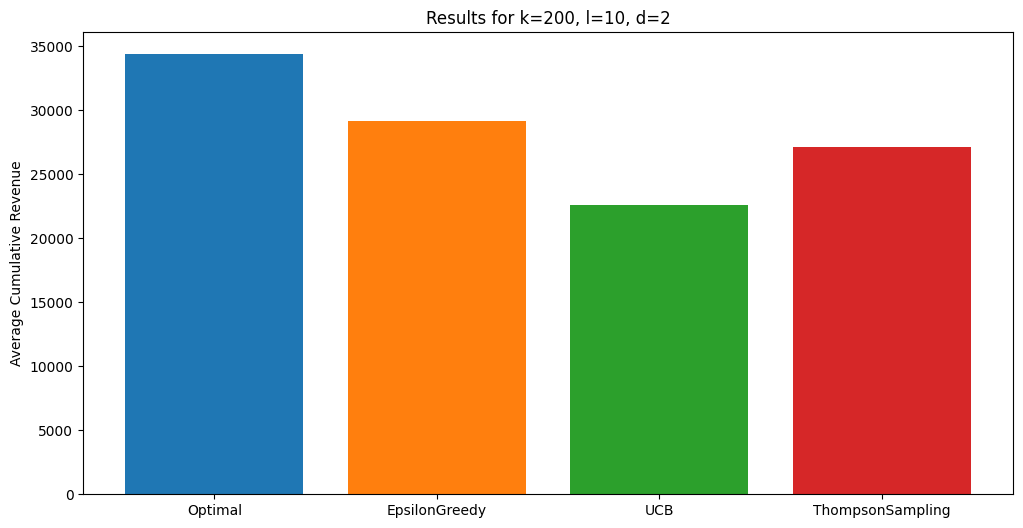

Running experiments for k=200, l=2, d=10: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


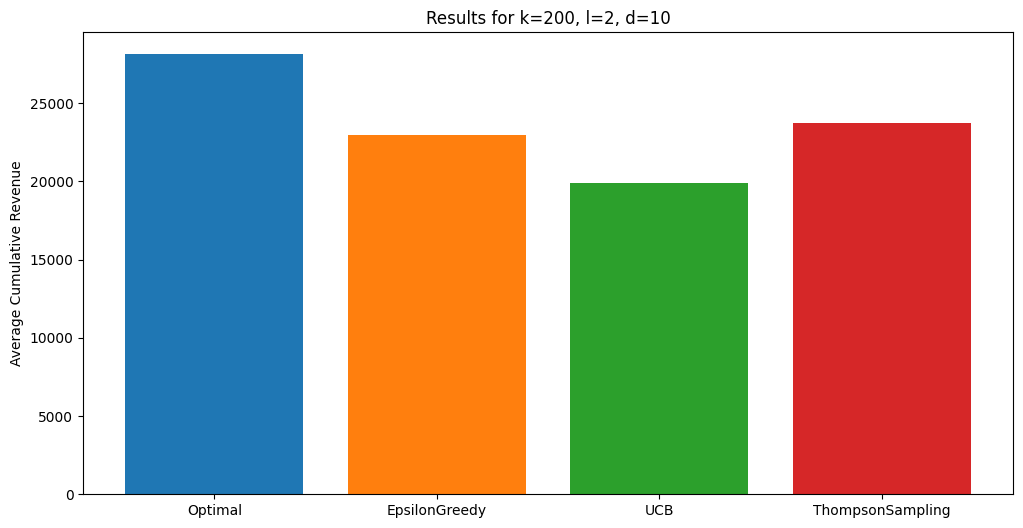

Running experiments for k=200, l=10, d=10: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


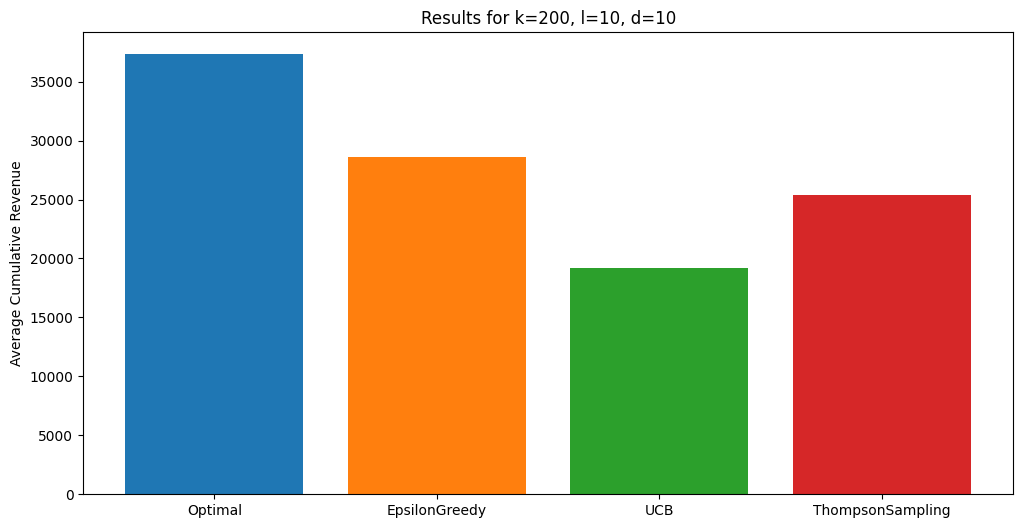

Running experiments for k=200, l=20, d=10: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


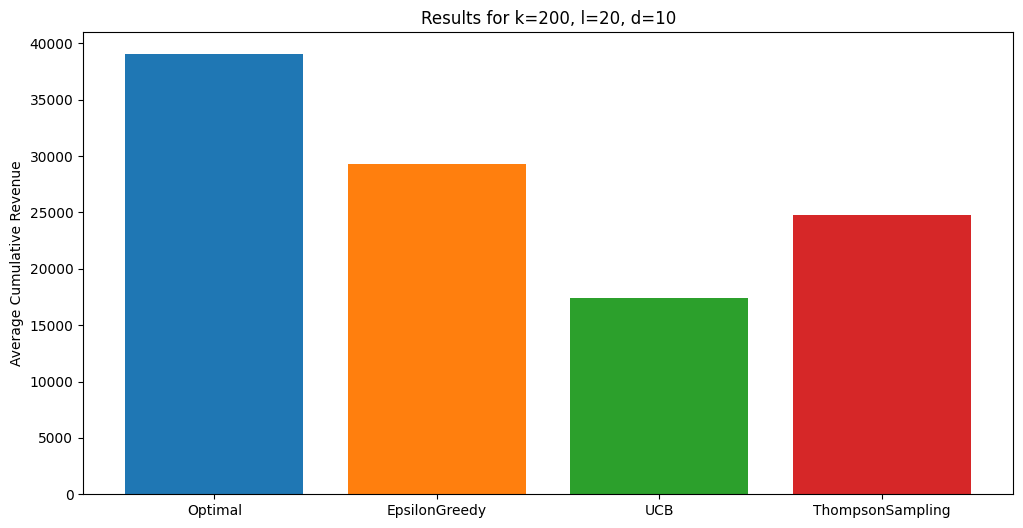

Overall Summary:


Running experiments for k=200, l=1, d=1: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Configuration: k=200, l=1, d=1
  Optimal: 17472.00
  EpsilonGreedy: 15241.80
  UCB: 14501.00
  ThompsonSampling: 16113.40



Running experiments for k=200, l=2, d=1: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Configuration: k=200, l=2, d=1
  Optimal: 22769.20
  EpsilonGreedy: 19963.80
  UCB: 18064.60
  ThompsonSampling: 20150.00



Running experiments for k=200, l=10, d=1: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Configuration: k=200, l=10, d=1
  Optimal: 27100.80
  EpsilonGreedy: 24795.00
  UCB: 20900.40
  ThompsonSampling: 23717.60



Running experiments for k=200, l=1, d=2: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Configuration: k=200, l=1, d=2
  Optimal: 28159.60
  EpsilonGreedy: 25267.00
  UCB: 23944.40
  ThompsonSampling: 25965.00



Running experiments for k=200, l=2, d=2: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Configuration: k=200, l=2, d=2
  Optimal: 32658.60
  EpsilonGreedy: 29153.80
  UCB: 25977.40
  ThompsonSampling: 29015.80



Running experiments for k=200, l=10, d=2: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Configuration: k=200, l=10, d=2
  Optimal: 35741.00
  EpsilonGreedy: 30056.20
  UCB: 23792.00
  ThompsonSampling: 28799.40



Running experiments for k=200, l=2, d=10: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Configuration: k=200, l=2, d=10
  Optimal: 28941.00
  EpsilonGreedy: 24308.80
  UCB: 21651.60
  ThompsonSampling: 24819.20



Running experiments for k=200, l=10, d=10: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Configuration: k=200, l=10, d=10
  Optimal: 37502.80
  EpsilonGreedy: 28327.60
  UCB: 19805.20
  ThompsonSampling: 26385.40



Running experiments for k=200, l=20, d=10: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

Configuration: k=200, l=20, d=10
  Optimal: 39830.60
  EpsilonGreedy: 29404.00
  UCB: 17757.60
  ThompsonSampling: 25319.20



In [ ]:
def run_experiment(k, l, d, num_events=10000, num_runs=5):
    results = {
        'Optimal': [],
        'EpsilonGreedy': [],
        'UCB': [],
        'ThompsonSampling': []
    }

    for _ in tqdm(range(num_runs), desc=f"Running experiments for k={k}, l={l}, d={d}"):
        init_data = Init(l=l, k=k, d=d, num_events=num_events)

        policies = {
            'Optimal': OptimalPolicy(init_data),
            'EpsilonGreedy': EpsilonGreedyPolicy(init_data, epsilon=0.1),
            'UCB': UCBPolicy(init_data, confidence_level=2),
            'ThompsonSampling': ThompsonSamplingPolicy(init_data)
        }

        for name, policy in policies.items():
            policy.run_simulation()
            results[name].append(policy.current_cumulative_revenue)

    return {name: np.mean(revenues) for name, revenues in results.items()}


def plot_results(results, title):
    plt.figure(figsize=(12, 6))
    for name, revenue in results.items():
        plt.bar(name, revenue)
    plt.title(title)
    plt.ylabel('Average Cumulative Revenue')
    plt.show()


# Run experiments for different configurations
configurations = [
    {'k': 200, 'l': 1, 'd': 1},
    {'k': 200, 'l': 2, 'd': 1},
    {'k': 200, 'l': 10, 'd': 1},
    {'k': 200, 'l': 1, 'd': 2},
    {'k': 200, 'l': 2, 'd': 2},
    {'k': 200, 'l': 10, 'd': 2},
    {'k': 200, 'l': 2, 'd': 10},
    {'k': 200, 'l': 10, 'd': 10},
    {'k': 200, 'l': 20, 'd': 10}
]

for config in configurations:
    results = run_experiment(**config)
    plot_results(results, f"Results for k={config['k']}, l={config['l']}, d={config['d']}")

# Print overall summary
print("Overall Summary:")
for config in configurations:
    results = run_experiment(**config)
    print(f"Configuration: k={config['k']}, l={config['l']}, d={config['d']}")
    for name, revenue in results.items():
        print(f"  {name}: {revenue:.2f}")
    print()